# Evolving Networks Presentation Plots

Analyze data from evolving networks toward target functions
Compile these into presentable results

Both with and without oscillations 

Sept 26, 2018 

Sam Goldman





In [5]:
import sys
import os
sys.path.append("../Classes")
from HomGraph import *
from SFGraph import *
from sighelp import *

from AttractorGraph import * 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import pickle
import json 
from collections import * 

import time
from scipy.sparse import csr_matrix

from matplotlib import rcParams
sns.set(context='paper',font_scale = 7,
        rc = {'figure.figsize' : (20,10), 'legend.frameon':True, 
              'legend.loc': 'upper right', "xtick.major.size": 10,"ytick.major.size": 10,
             "xtick.minor.size": 6,"ytick.minor.size": 6, 
              "xtick.major.width": 3, "ytick.major.width": 3,
             "xtick.minor.width": 1, "ytick.minor.width": 1, 'lines.linewidth':7})

# sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("coolwarm")
plt.rc("axes.spines", top=False, right=False)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


In [25]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def get_results(filename): 
    '''
        Helper function for pickling 
    '''
    with open(filename, "rb") as k: 
        res = pickle.load(k)
    return res

def get_x_vals(ar):
    '''
        Given numpy array, generate the appropriate time series values 
        to shift it by one for plotting in log scale
    '''
    return np.arange(1, ar.shape[0] + 1)

def convert_to_avg(x): 
    '''
        Helper function to convert the multiplexed learning into something to compare with simultaneous learning
        We average over each learning cycle
    '''
    
    
    ### Check stable state assumption
    if 'selection_delay' in x: 
        
        avg_num = int(x['selection_delay'])
    else: 
        avg_num = len(x['target_lengths'])


    # USE THIS TO ENSURE EARLY STOPPING CONDITIONS MET ON EARLIER DATA
    threshold = 100 * avg_num
    for row in range(x['scores'].shape[0]):
        current_sum = 0
        cur_row = x['scores'][row]
        for index in range(cur_row.shape[0]):
            if np.abs(cur_row[index] - 1) < 0.0001:
                current_sum += 1
                if current_sum >= threshold:
                    cur_row[index:] = 1
                    break
            else:
                current_sum = 0
        
    test = 1 - np.average(x['scores'], axis=0)
#     print(avg_num)
    new_ar = np.zeros(len(test) // avg_num)
    running_sum = 0
    for index, i in enumerate(test): 
        if (index % avg_num == avg_num - 1):
            running_sum += i / avg_num
            new_ar[index // avg_num] = running_sum
            running_sum = 0
        else:
            running_sum += i / avg_num
    return np.arange(1,len(new_ar)+1),new_ar



def convert_to_std(x,ddof=1): 
    '''
        Similar to previosu function.. first average across the different functions learned, then var across trials

    '''
    num_trials = x["trials"]
    if 'selection_delay' in x: 
        
        avg_num = int(x['selection_delay'])
    else: 
        avg_num = len(x['target_lengths'])
    new_ar = np.zeros((num_trials, len(x['scores'][0]) // avg_num))
    
    for trial in range(num_trials): 
        running_sum = 0
        test = 1 - x['scores'][trial]
        for index, i in enumerate(test): 
            if (index % avg_num == avg_num - 1):
                running_sum += i / avg_num
                new_ar[trial, index // avg_num] = running_sum
                running_sum = 0
            else:
                running_sum += i / avg_num

    # USE THIS TO ENSURE EARLY STOPPING CONDITIONS MET ON EARLIER DATA
    threshold = 100
    for row in range(new_ar.shape[0]):
        current_sum = 0
        cur_row =new_ar[row]
        for index in range(cur_row.shape[0]):
            if np.abs(cur_row[index]) < 0.0001:
                current_sum += 1
                if current_sum >= threshold:
                    cur_row[index:] = 0
                    break
            else:
                current_sum = 0
                
    return np.arange(1,len(x['scores'][0]) // avg_num + 1), np.std(new_ar, axis=0, ddof=ddof)


def convert_to_horiz_avg(x): 
    '''
        Similar to previosu function.. this one returns the horizontal avgs not vertical procesd
    '''
    num_trials = x["trials"]
    if 'selection_delay' in x: 
        
        avg_num = int(x['selection_delay'])
    else: 
        avg_num = len(x['target_lengths'])
    new_ar = np.zeros((num_trials, len(x['scores'][0]) // avg_num))
    
    for trial in range(num_trials): 
        running_sum = 0
        test = 1 - x['scores'][trial]
        for index, i in enumerate(test): 
            if (index % avg_num == avg_num - 1):
                running_sum += i / avg_num
                new_ar[trial, index // avg_num] = running_sum
                running_sum = 0
            else:
                running_sum += i / avg_num
                
    # USE THIS TO ENSURE EARLY STOPPING CONDITIONS MET ON EARLIER DATA
    threshold = 100
    for row in range(new_ar.shape[0]):
        current_sum = 0
        cur_row =new_ar[row]
        for index in range(cur_row.shape[0]):
            if np.abs(cur_row[index]) < 0.0001:
                current_sum += 1
                if current_sum >= threshold:
                    cur_row[index:] = 0
                    break
            else:
                current_sum = 0
                
    return np.arange(1,len(x['scores'][0]) // avg_num + 1),new_ar



def break_out_into_tracks(x):
    '''
        Break out x into its component frequencies learned over iteration
    '''
    #     ### 
    generations = x['generations']
    target_lengths = x['target_lengths']
    start_time = 0
    colors = sns.color_palette("coolwarm", len(target_lengths))#plt.cm.jet(np.linspace(0,1,len(target_lengths)))
    for j in range(len(target_lengths)):
        indices = [i for i in np.arange(0,generations) if i % len(target_lengths) == j]
        plt.semilogx(range(1,len(indices)+1), 1 - np.mean(x['scores'], axis=0)[indices][start_time:], 
                 label=f'{target_lengths[j]}', alpha=0.8, c = colors[j])
        # Note, investigate what we're actually plotting here
        plt.xlabel("Generations")
        plt.ylabel("1 - Fitness")
#     plt.title("Learning trajectories for individual periods: %d functions" % len(target_lengths))
    legend = plt.legend(fontsize=40, title="Target Length",  loc=(0.7,0.25))
    legend.get_title().set_fontsize(48)

    
    plt.ylim([0,0.6])
    plt.xlim([1,4000])

## Networks can learn multiple functions for different oscillations


In [4]:
### Note: This used to be hidden and tucked away in select delay

prefix = "../../Results/NetworkEvolutions/periodic_limit_learning/"
files = [f"oscil_500_1.9_sf_graph_{i}_targets.p" for i in range(1,8)]
res = [] 
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))







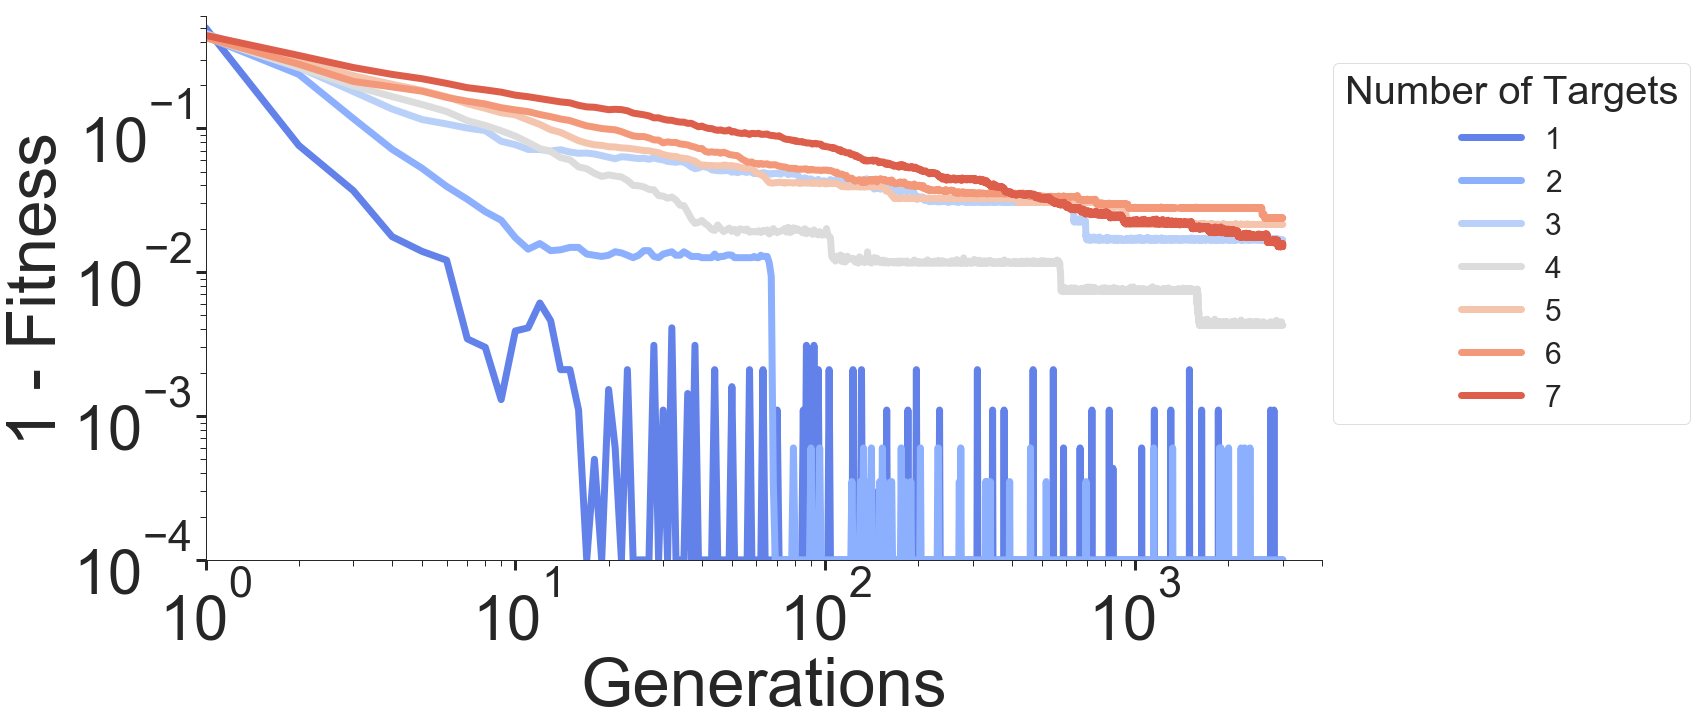

In [24]:
# cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
# num_targets = range(1,8)
# for index, q in enumerate(res):
#     x,y = convert_to_avg(q)
#     plt.semilogx(x,y, label=num_targets[index], c = cols[index])
# plt.xlabel("Generations")
# plt.ylabel("1 - Fitness")
# legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))
# plt.ylim([0,0.6])
# plt.xlim([1,4000])
# plt.savefig("/Users/samgoldman/Desktop/fixed_multi_target.pdf", bbox_inches="tight")
# plt.show()


cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,8)
for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    plt.loglog(x,y+0.0001, label=num_targets[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=30, title="Number of Targets", loc=(1.01,0.25))
legend.get_title().set_fontsize(40)
plt.ylim([0.0001,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/oscil_multi_target.pdf", bbox_inches="tight")
plt.show()



### Putting this sidebyside with the fixed learning example

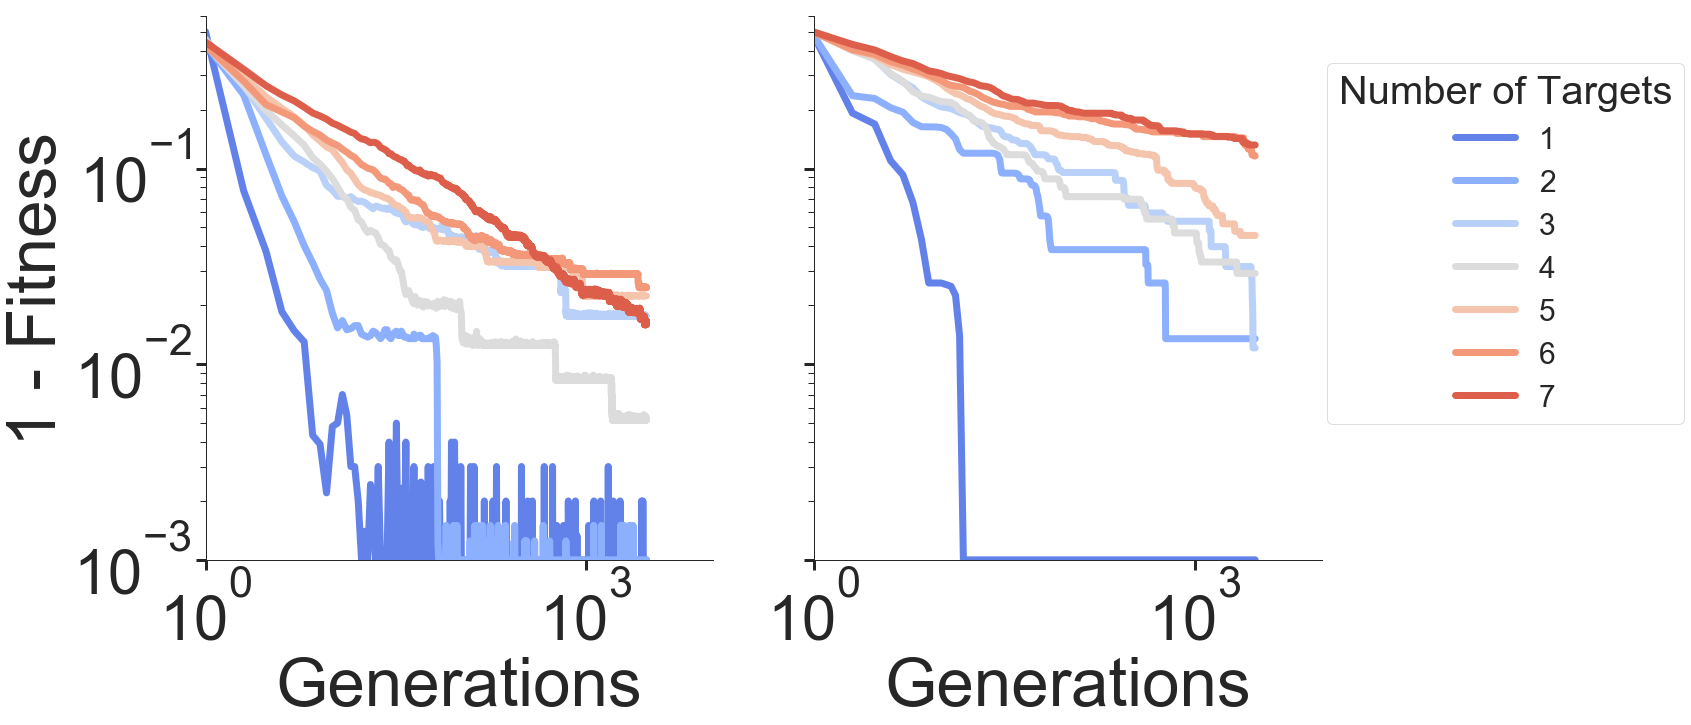

In [41]:

prefix = "../../Results/NetworkEvolutions/periodic_limit_learning/"
files = [f"oscil_500_1.9_sf_graph_{i}_targets.p" for i in range(1,8)]
res1 = [] 
for i in files:
    temp_file = prefix + i
    res1.append(get_results(temp_file))
    

prefix = "../../Results/NetworkEvolutions/fixed_start_limit_learning/"
files = [f"fixed_start_multiplex_evolution_run_500_1.9_sf_graph_{i}_targets.p" for i in range(1,8)]
res2 = [] 
for i in files:
    temp_file = prefix + i
    res2.append(get_results(temp_file))



fig, axes = plt.subplots(nrows=1,ncols=2, sharey=True)
    

results = [res1, res2]
titles = ["Oscillating Single Input", "Static Input"]
cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,8)
plt.sca(axes[0])
plt.ylabel("1 - Fitness")
for ind, ax in enumerate(axes): 
    plt.sca(ax)
    for index, q in enumerate(results[ind]):
        x,y = convert_to_avg(q)
        plt.loglog(x,y+0.001, label=num_targets[index], c = cols[index])
    plt.xlabel("Generations")
    ax.set_xlim([1,10000])
plt.ylim([0.001,0.6])
legend = plt.legend(fontsize=30, title="Number of Targets", loc=(1.01,0.25))
legend.get_title().set_fontsize(40)
plt.savefig("/Users/samgoldman/Desktop/oscil_multi_target.pdf", bbox_inches="tight")
plt.show()



Also make the point that when we get to 7, certain functions are learned poorly

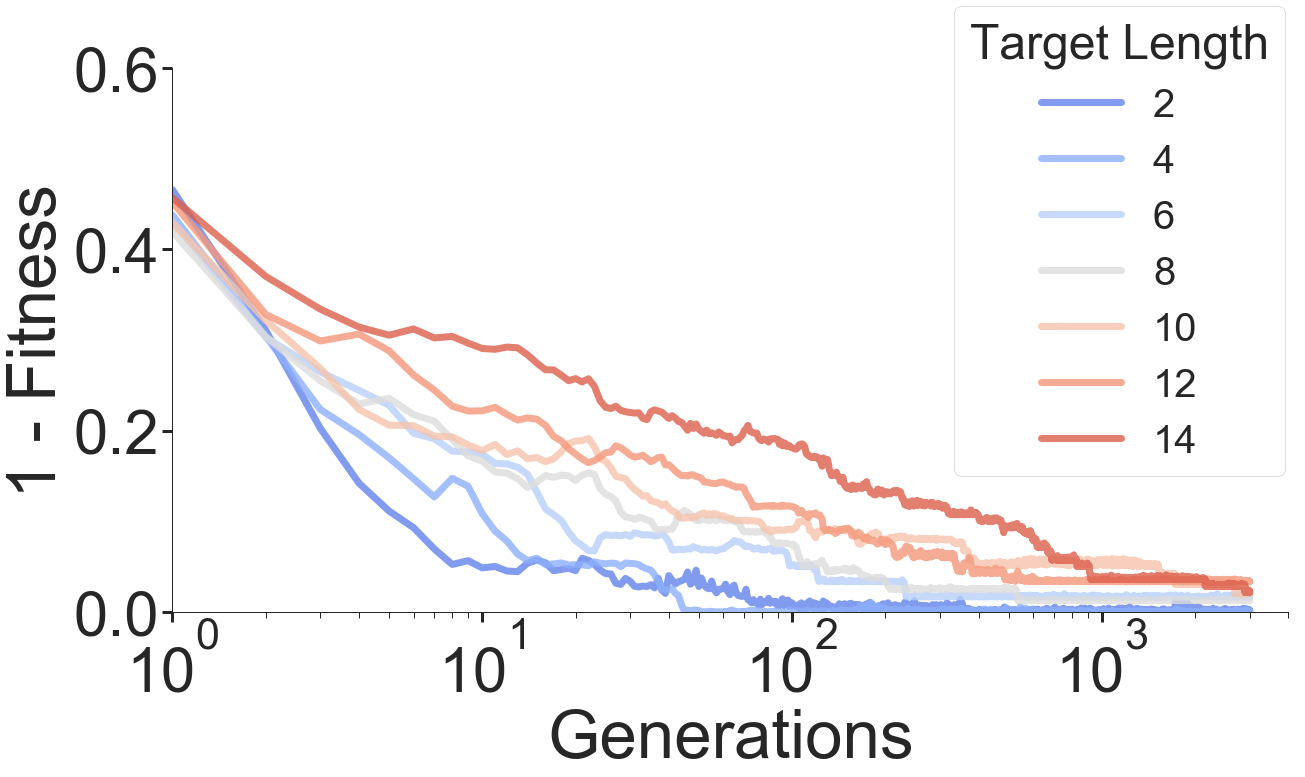

In [10]:
break_out_into_tracks(res[-1])
plt.savefig("/Users/samgoldman/Desktop/one_run_7_targets.pdf", bbox_inches="tight")

## Trying to learn multiple functions with stereotyped

In [3]:
prefix = "../../Results/NetworkEvolutions/stereotyped_limit_learning/"



In [4]:
ls $prefix

stereotyped_500_1.9_sf_graph_1_targets.p
stereotyped_500_1.9_sf_graph_2_targets.p
stereotyped_500_1.9_sf_graph_3_targets.p
stereotyped_500_1.9_sf_graph_4_targets.p
stereotyped_500_1.9_sf_graph_5_targets.p
stereotyped_500_1.9_sf_graph_6_targets.p
stereotyped_500_1.9_sf_graph_7_targets.p


In [10]:
num_targets = [1,2,3,4,5,6,7]
res = []
for i in num_targets:
    temp_file = prefix + f"stereotyped_500_1.9_sf_graph_{i}_targets.p"
    res.append(get_results(temp_file))
#     print(res[i-1])

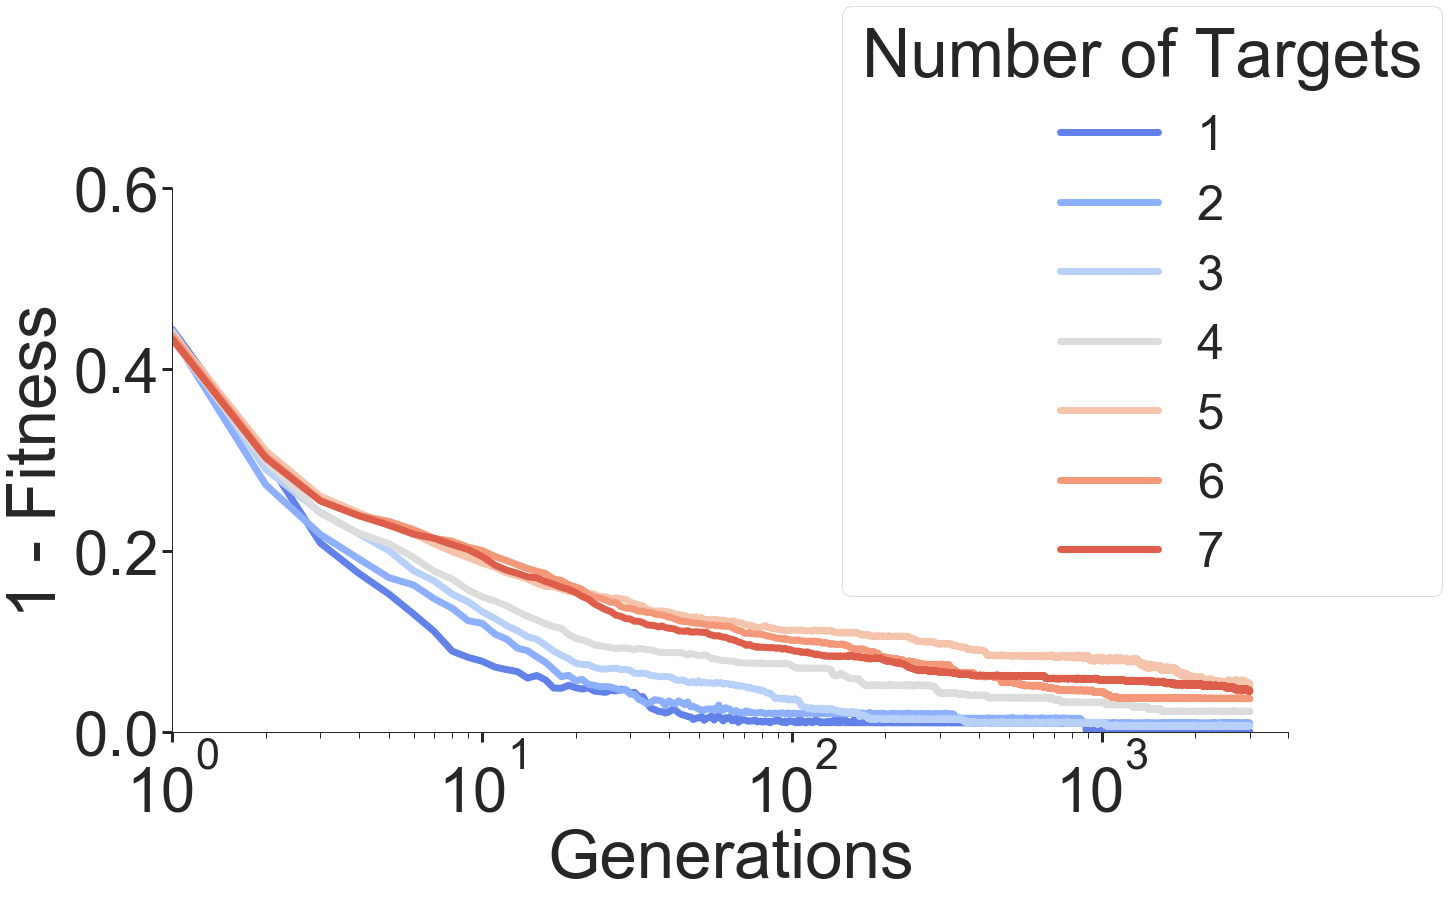

In [15]:
cols = sns.color_palette("coolwarm", len(res))
for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=num_targets[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/stereotyped_multi_target.pdf", bbox_inches="tight")
plt.show()

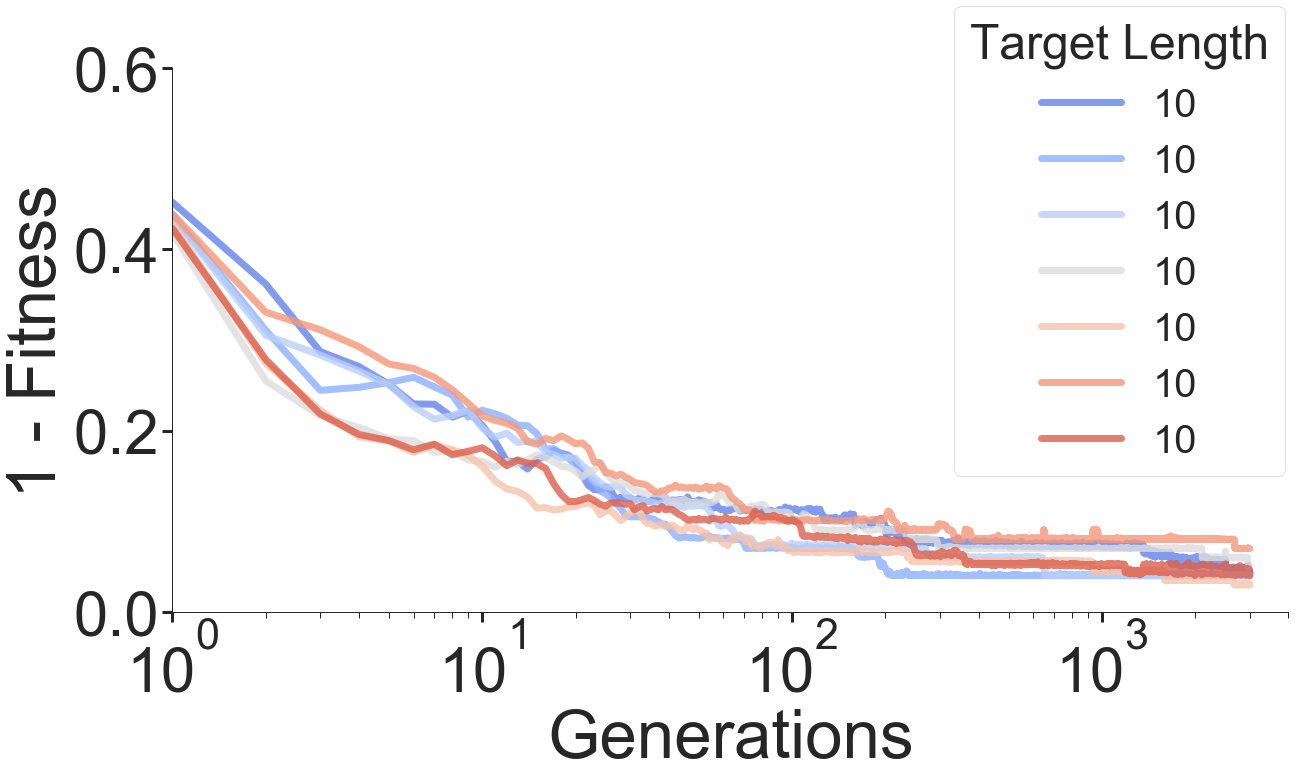

In [32]:
break_out_into_tracks(res[-1])
plt.savefig("/Users/samgoldman/Desktop/one_run_7_targets.pdf", bbox_inches="tight")

## Block Learning (SI) Does not work well

In [54]:
prefix = "../../Results/NetworkEvolutions/BlockLearning/"
f3_blocked = "three_targets_all_results.p"
sf_blocked_3 = get_results(prefix+f3_blocked)

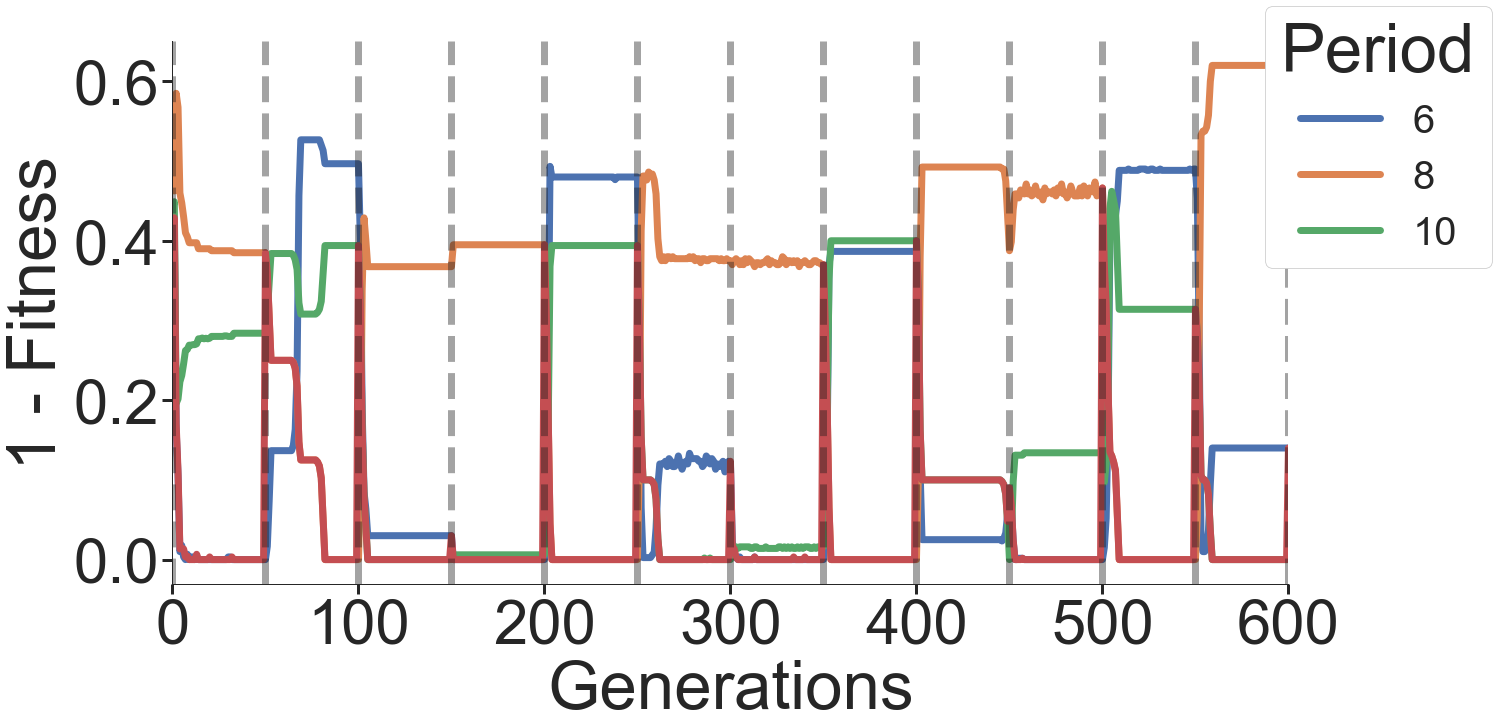

In [78]:
### Average across all trials and blocks...
blocked_three = np.mean(sf_blocked_3['all_results'], 0)
periods = sf_blocked_3['periods']
for i in range(len(periods)):
    plt.plot(1 - blocked_three[:,i], label=f"{periods[i]}")
plt.legend(title="Period", framealpha=1, loc = "upper right", fontsize=40, 
          bbox_to_anchor=(1.2, 1.1))
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
plt.plot(1 - sf_blocked_3['scores'][0])
plt.xlim([0,600])
xposition = [i for i in range(1000) if i % 50 == 0]
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--', alpha=0.4)
plt.savefig("/Users/samgoldman/Desktop/learning_strategies.pdf", bbox_inches="tight")
# plt.show()

## Switching target functions midway through iterations

10^4 iterations, targets 8,10,12;
Averaged over 10 trials;
Do we see that it learns quicker second time around?;



In [3]:
prefix = "../../Results/NetworkEvolutions/same_networks_new_targets/"
file = prefix + "oscil_multiplex_8_10_12_midway_switch.p"
# file = prefix + "oscil_multiplex_2_4_6_8_10_midway_switch.p"


res = get_results(file)






In [15]:
x,y = convert_to_avg(res)
avg_gens = len(x)

midway_pt = int(avg_gens / 2)

x1, y1 = x[:midway_pt], y[:midway_pt]
x2, y2 = x[midway_pt:], y[midway_pt:]



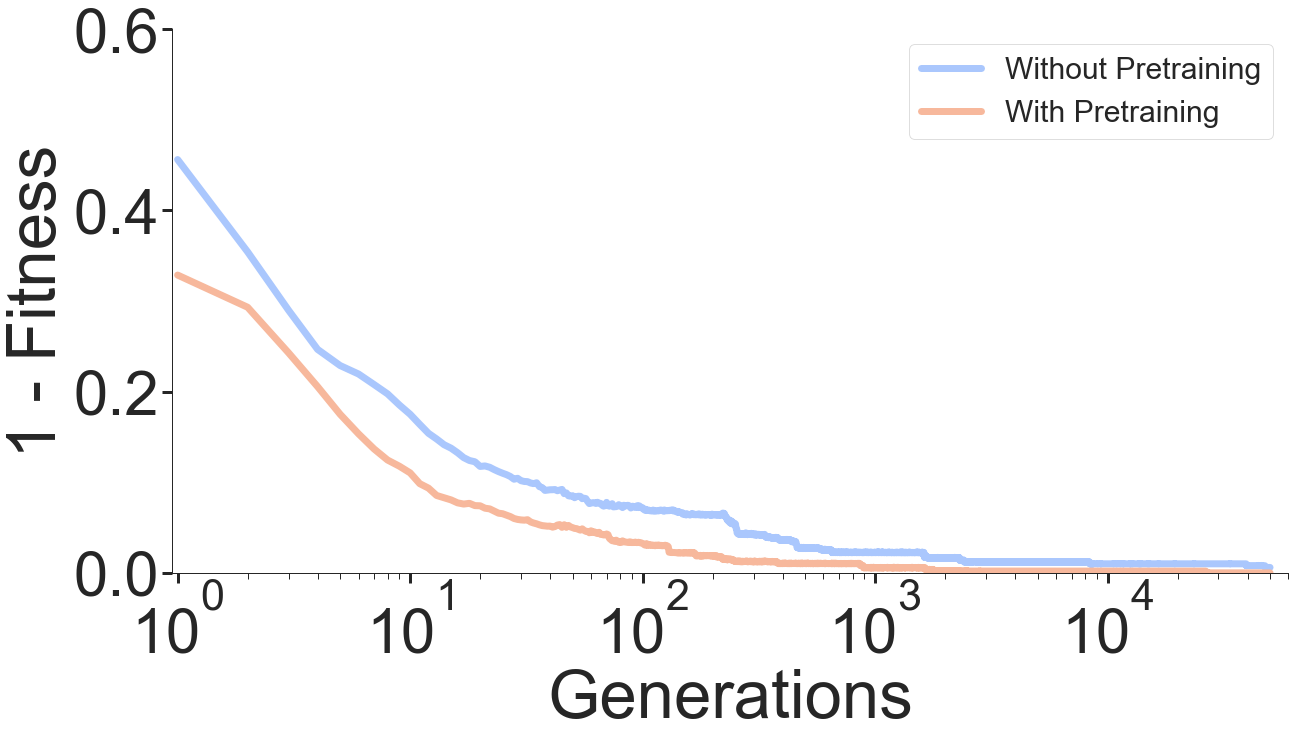

In [16]:
cols = sns.color_palette("coolwarm", 2)
plt.semilogx(x1,y1, label="Without Pretraining", c = cols[0])
plt.semilogx(x1,y2, label="With Pretraining", c = cols[1])


plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=30, title="", loc="upper right")
legend.get_title().set_fontsize(40)
plt.ylim([0,0.6])
plt.xlim([0.95,60000])
plt.savefig("/Users/samgoldman/Desktop/pretraining_3_fns.pdf", bbox_inches="tight")
plt.show()

## Learning scales with N 

In [8]:
prefix = "../../Results/NetworkEvolutions/StereotypedNoise/"
f500 = "../../Results/NetworkEvolutions/Multiplexing/three_multiplex/three_multiplex_simul.p"
f100 = "../../Results/NetworkEvolutions/Multiplexing/three_multiplex/oscil_multiplex_evolution_run_100_1.9_sf_graph_3_targets.p"
f1000 = "../../Results/NetworkEvolutions/Multiplexing/three_multiplex/oscil_multiplex_evolution_run_1000_1.9_sf_graph_3_targets.p"

# 6, 8 , 10
n1000 = get_results(f1000)
n500 = get_results(f500)
n100 = get_results(f100)



In [80]:
n1000

{'n': 1000,
 'control_param': 1.9,
 'generations': 10000,
 'network_type': 'sf_graph',
 'scores': array([[0.60597436, 0.53469444, 0.5866    , ..., 1.        , 1.        ,
         1.        ],
        [0.635     , 0.61920833, 0.57733333, ..., 1.        , 1.        ,
         1.        ],
        [0.56333333, 0.58469697, 0.5867619 , ..., 1.        , 0.9       ,
         1.        ],
        ...,
        [0.58114286, 0.50583333, 0.547     , ..., 1.        , 1.        ,
         1.        ],
        [0.56733333, 0.54183333, 0.483     , ..., 1.        , 1.        ,
         1.        ],
        [0.57083333, 0.536     , 0.56483333, ..., 1.        , 1.        ,
         1.        ]]),
 'description': 'Try to learn via a different N value! How does this scale??',
 'periods': array([ 6,  8, 10], dtype=int32),
 'target_lengths': array([ 6,  8, 10], dtype=int32),
 'trials': 10,
 'simulation_type': 'evolve_multiplex_oscil',
 'sort_first': False,
 'selection_delay': 3,
 'Mean Squared Error': True,

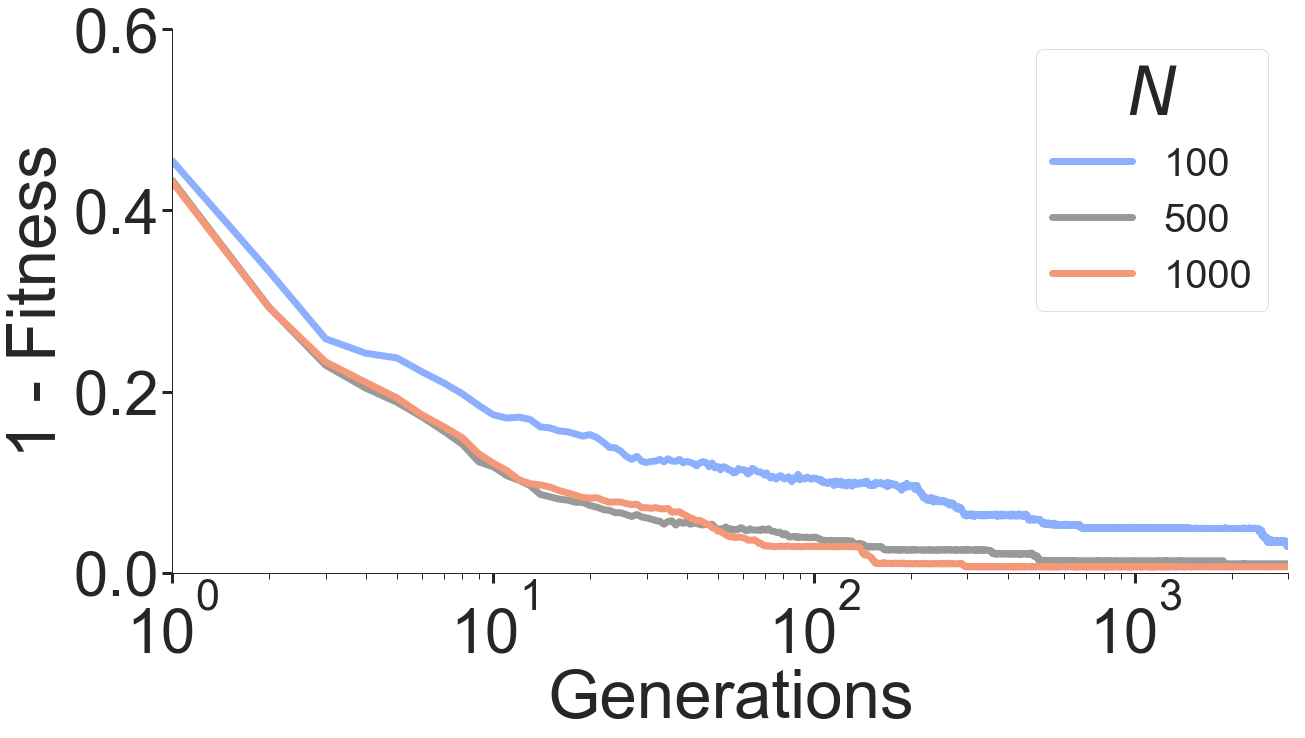

In [22]:
cols = sns.color_palette("coolwarm", 3) #plt.cm.jet(np.linspace(0,1,len(res)))
cols[1] = (0.6,0.6,0.6)
my_list = [n100, n500, n1000]
for ind, q in enumerate(my_list):
    n_ = q['n']
    x,y = convert_to_avg(q)
    plt.semilogx(x[1:] - 1,y[1:], label="%d" % n_, c=cols[ind])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
plt.legend(fontsize=40, title="$N$", loc="upper right")
plt.ylim([0,0.6])
plt.xlim([1,3000])
plt.savefig("/Users/samgoldman/Desktop/learning_with_N.pdf", bbox_inches="tight")
plt.show()

## Frequency coded inputs are learned quicker

In [5]:
prefix = "../../Results/NetworkEvolutions/StereotypedNoise/"

# No mini cycles
# "../../Results/NetworkEvolutions/Multiplexing/three_multiplex/three_multiplex_simul_8_10_12.p"
# Mini cycles... 
f_multiplex_three = "../../Results/NetworkEvolutions/Multiplexing/three_multiplex/three_multiplex_simul_8_10_12_mini_cycles.p"
## Note, this could use more trials...
f_stereotyped = "../../Results/NetworkEvolutions/StereotypedNoise/stereotyped_3_freq_3_targets.p"
fno_freq = "../../Results/NetworkEvolutions/no_frequency/no_frequency_3_targets_8_10_12.p"


# 8, 10, 12

stereotyped_freq = get_results(f_stereotyped)
freq = get_results(f_multiplex_three)
no_freq = get_results(fno_freq)

In [3]:
# no_freq, freq, stereotyped_freq

In [67]:
## Learning targets 8, 10, 12 with inputs 8,10,12 for the two frequecnies

In [13]:
colors[1]

(0.8674276350862745, 0.864376599772549, 0.8626024620196079)

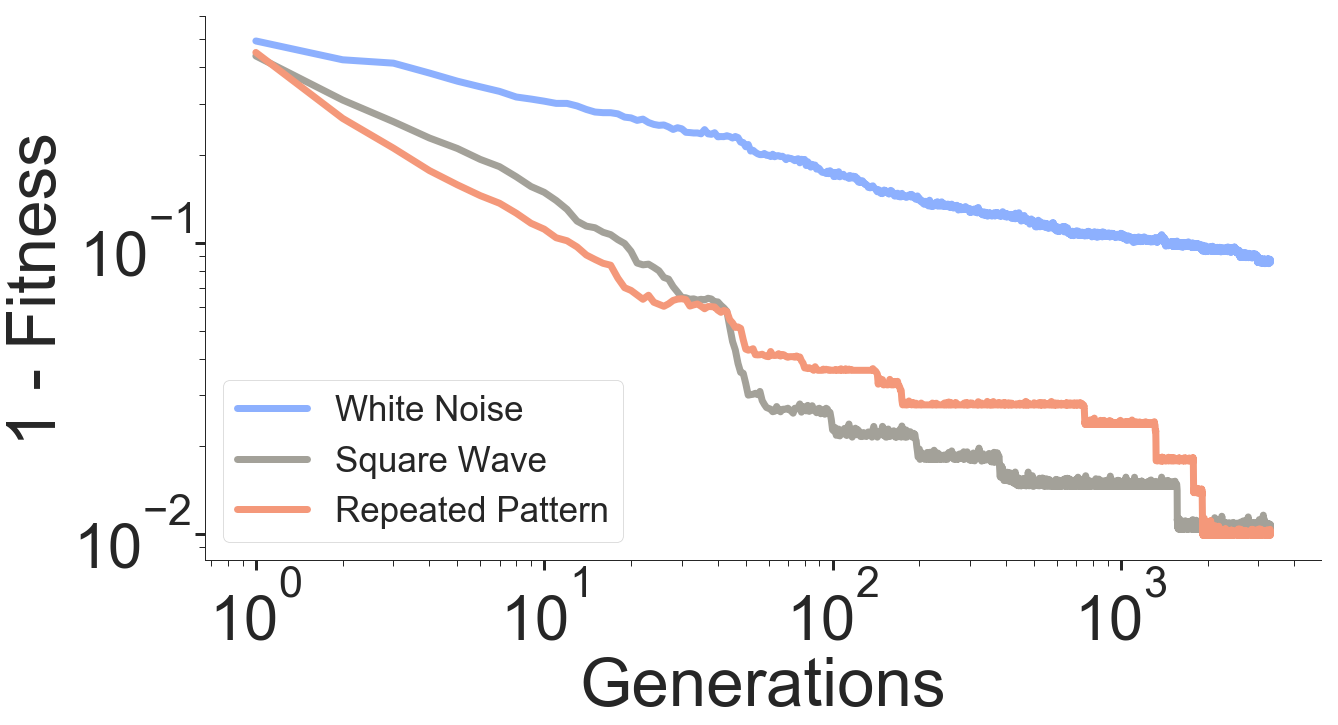

In [17]:
my_list = [no_freq, freq, stereotyped_freq]
colors = sns.color_palette("coolwarm", 3) #plt.cm.jet(np.linspace(0,1,len(my_list)))
colors[1] = (0.639, 0.631, 0.6)
name = ["White Noise", "Square Wave", "Repeated Pattern"] 
for index, q in enumerate(my_list):
#     n_ = q['n']
    x,y = convert_to_avg(q)
    plt.loglog(x[:3300],y[:3300], label=name[index], c=colors[index], alpha=1)
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
plt.legend(loc="lower left", fontsize=35)
plt.savefig("/Users/samgoldman/Desktop/diff_patterns.pdf", bbox_inches="tight")
plt.show()

####  Noise patterns

In [23]:
# White noise 
seq_length = 40 
pulse_length = 5
rnd_gen = lambda x: np.random.randint(0,2, x)
white_noise = rnd_gen(seq_length)
oscil = np.array([0 if ((i // pulse_length) % 2) == 0 else 1 
                  for i in range(seq_length)])
stereotyped = np.tile(rnd_gen(pulse_length *2), int(seq_length / (pulse_length*2)))
current_palette = sns.color_palette()
current_palette = colors



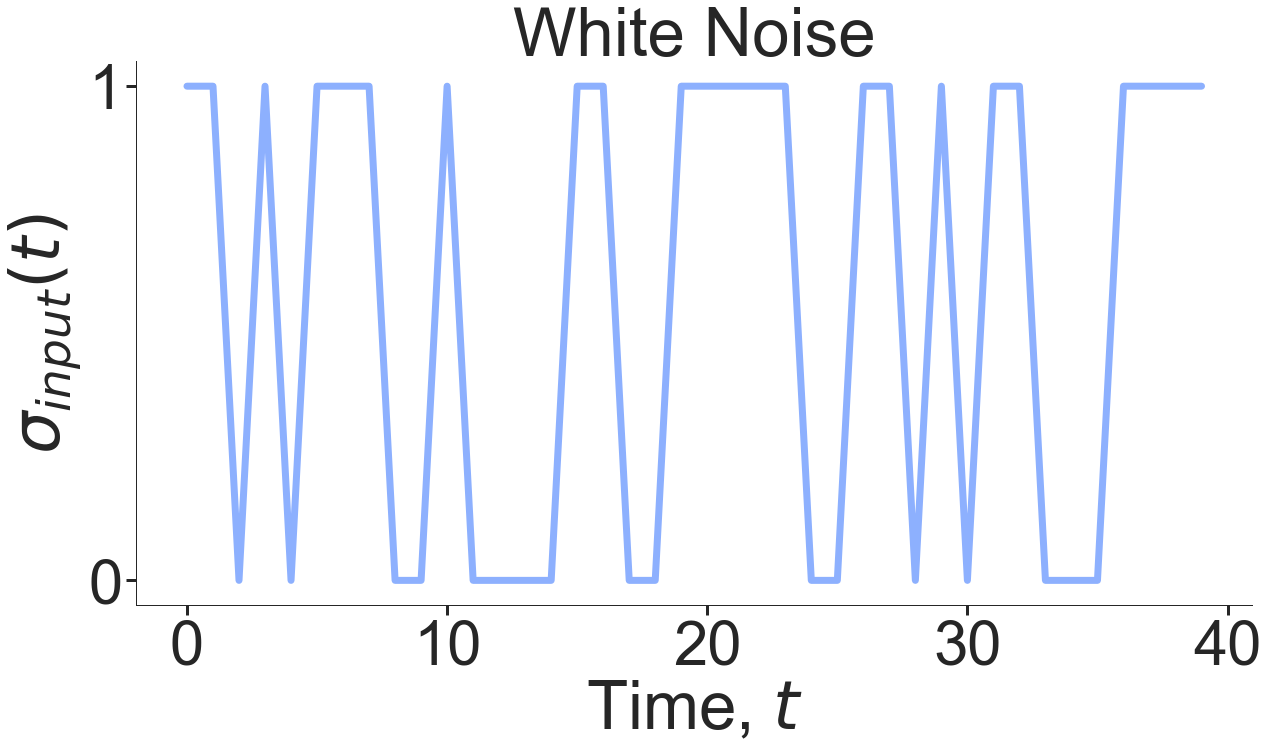

In [24]:
plt.plot(white_noise, c= current_palette[0])
plt.title("White Noise")
plt.xlabel("Time, $t$")
plt.ylabel("$\sigma_{input}(t)$")
plt.yticks([0,1])
plt.savefig("/Users/samgoldman/Desktop/white_noise.pdf", bbox_inches="tight")

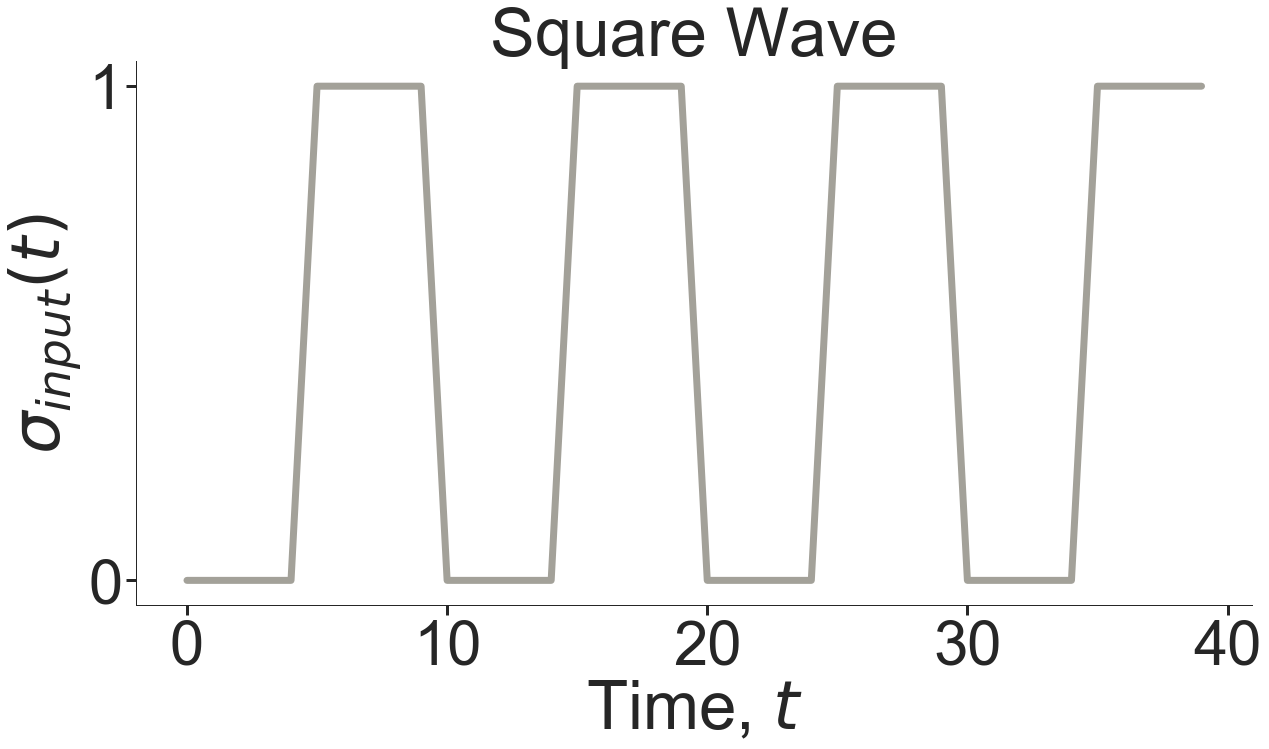

In [25]:
plt.plot(oscil, c= current_palette[1])
plt.title("Square Wave")
plt.xlabel("Time, $t$")
plt.ylabel("$\sigma_{input}(t)$")
plt.yticks([0,1])
plt.savefig("/Users/samgoldman/Desktop/single_frequency.pdf", bbox_inches="tight")

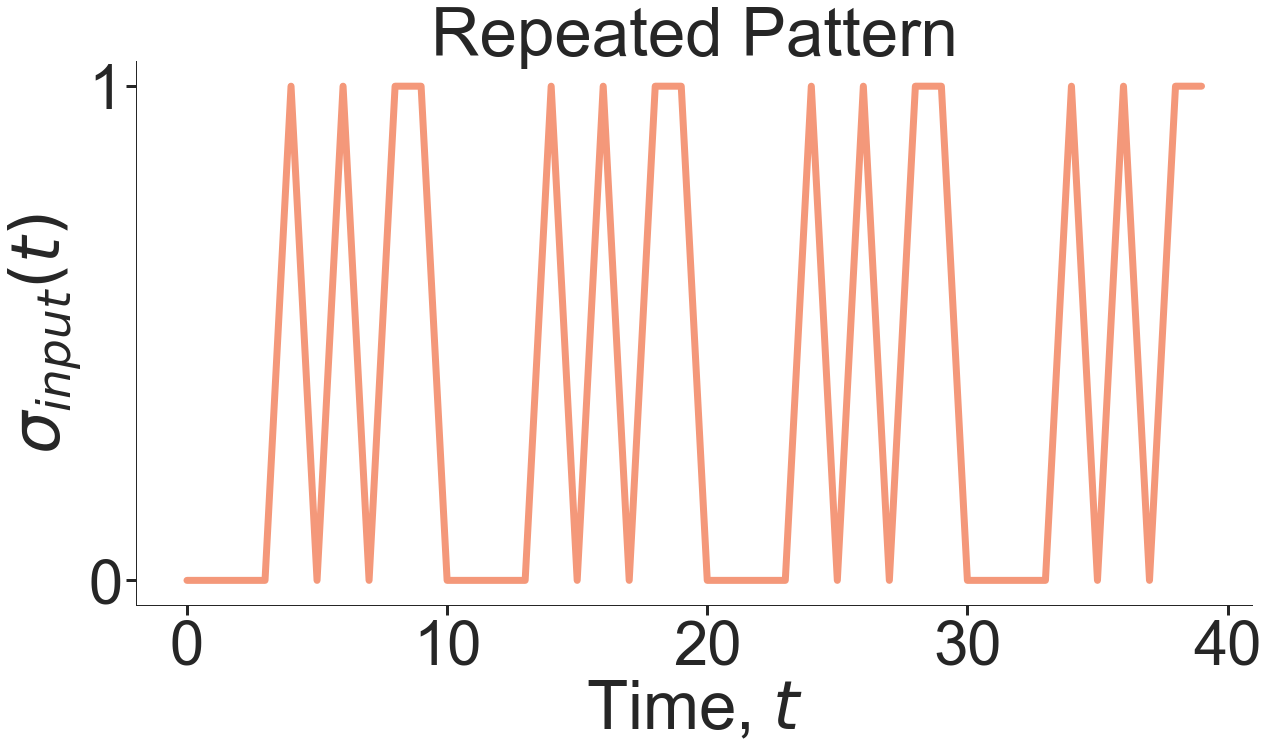

In [26]:
plt.plot(stereotyped, c= current_palette[2])
plt.title("Repeated Pattern")
plt.xlabel("Time, $t$")
plt.ylabel("$\sigma_{input}(t)$")
plt.yticks([0,1])
plt.savefig("/Users/samgoldman/Desktop/stereotyped_frequency.pdf", bbox_inches="tight")

## Learning multiple targets of the same length

Note, we don't include the input in these simulations and we allow checking for mini cycles

In [24]:
prefix = "../../Results/NetworkEvolutions/per_targ_mismatch/"

In [ ]:
ls $prefix

### Single target, varied input -> looking at impact of uneven timescale

In [25]:
f1 = prefix + "input_10_target_10_oscil_evolution_500_1.9_sf_graph.p"
f2 = prefix + "input_10_target_8_oscil_evolution_500_1.9_sf_graph.p"
f3 = prefix + "input_8_target_10_oscil_evolution_500_1.9_sf_graph.p"
f4 = prefix + "input_2_target_10_oscil_evolution_500_1.9_sf_graph.p"


f1_res = get_results(f1)
f2_res = get_results(f2)
f3_res = get_results(f3)
f4_res = get_results(f4)

In [26]:
f4_res

{'n': 500,
 'control_param': 1.9,
 'generations': 3000,
 'pop_size': 50,
 'num_replicates': 3,
 'network_type': 'sf_graph',
 'scores': array([[0.49572727, 0.596     , 0.6       , ..., 1.        , 1.        ,
         1.        ],
        [0.517     , 0.59      , 0.6       , ..., 1.        , 1.        ,
         1.        ],
        [0.568     , 0.7585    , 0.794     , ..., 1.        , 1.        ,
         1.        ],
        ...,
        [0.513     , 0.54578571, 0.588     , ..., 1.        , 1.        ,
         1.        ],
        [0.51466667, 0.598     , 0.63      , ..., 1.        , 1.        ,
         1.        ],
        [0.49347619, 0.5845    , 0.5975    , ..., 1.        , 1.        ,
         1.        ]]),
 'description': '',
 'periods': array([2], dtype=int32),
 'target_lengths': array([10], dtype=int32),
 'trials': 10,
 'simulation_type': 'evolve_multiplex_oscil',
 'sort_first': False,
 'selection_delay': 1,
 'Mean Squared Error': True,
 'Learning Blocks': 1,
 'learning_rota

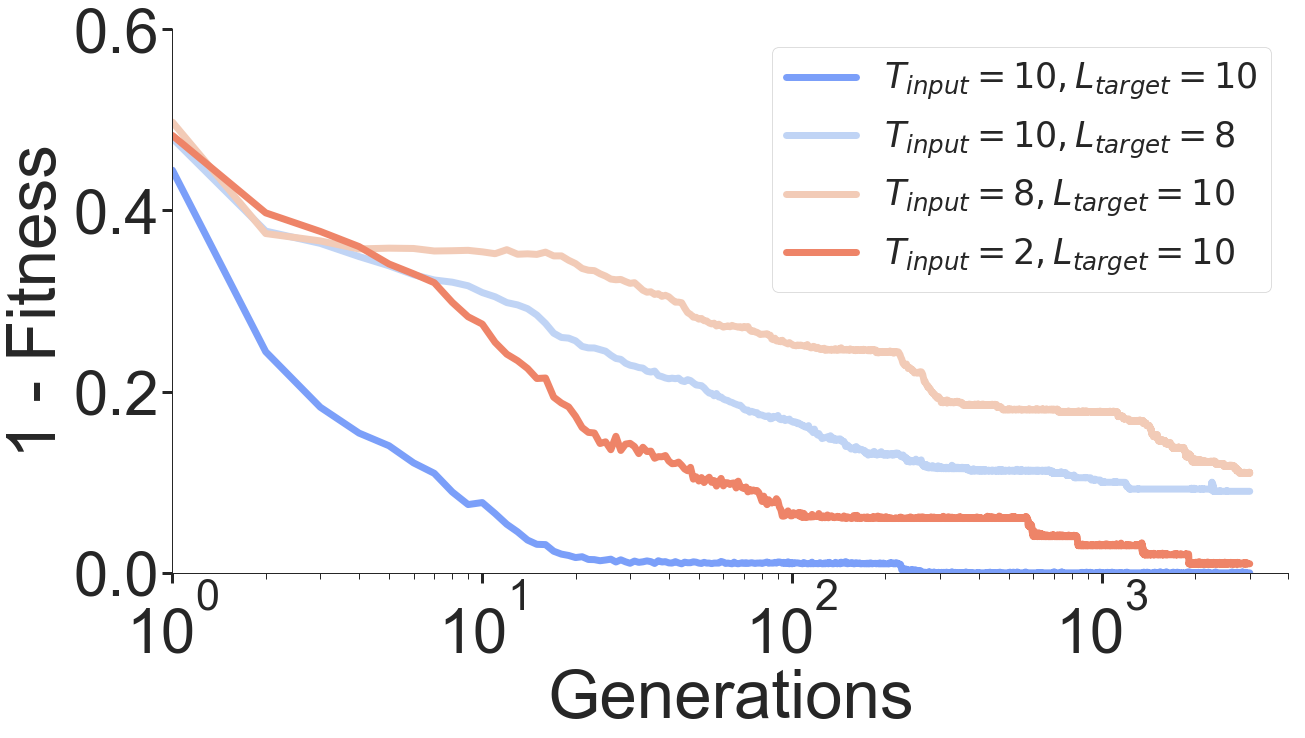

In [14]:
my_list = [f1_res, f2_res, f3_res, f4_res]
cols = sns.color_palette("coolwarm", len(my_list))
name = ["$T_{input}=10, L_{target}=10$", "$T_{input}=10, L_{target}=8$", "$T_{input}=8, L_{target}=10$", "$T_{input}=2, L_{target}=10$"] 
for index, q in enumerate(my_list):
#     n_ = q['n']
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=name[index], c=cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
plt.legend(loc="upper right", fontsize=35)
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/varied_input_output.pdf", bbox_inches="tight")
plt.show()

### Stacking multiple periods..

In [15]:
prefix = "../../Results/NetworkEvolutions/same_size_target/"

In [16]:
target_nums = [1, 2,3,4,5,6,7]

{'n': 500, 'control_param': 1.9, 'generations': 3000, 'pop_size': 50, 'num_replicates': 3, 'network_type': 'sf_graph', 'scores': array([[0.592     , 0.766     , 0.808     , ..., 1.        , 1.        ,
        1.        ],
       [0.558     , 0.719     , 0.79066667, ..., 1.        , 1.        ,
        1.        ],
       [0.566     , 0.692     , 0.74266667, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.49166667, 0.78      , 0.87      , ..., 1.        , 1.        ,
        1.        ],
       [0.543     , 0.7       , 0.786     , ..., 1.        , 1.        ,
        1.        ],
       [0.48733333, 0.804     , 0.796     , ..., 1.        , 1.        ,
        1.        ]]), 'description': '', 'periods': array([10], dtype=int32), 'target_lengths': array([10], dtype=int32), 'trials': 10, 'simulation_type': 'evolve_multiplex_oscil', 'sort_first': False, 'selection_delay': 1, 'Mean Squared Error': True, 'Learning Blocks': 1, 'learning_rotation': None, 'DateTime': 'J

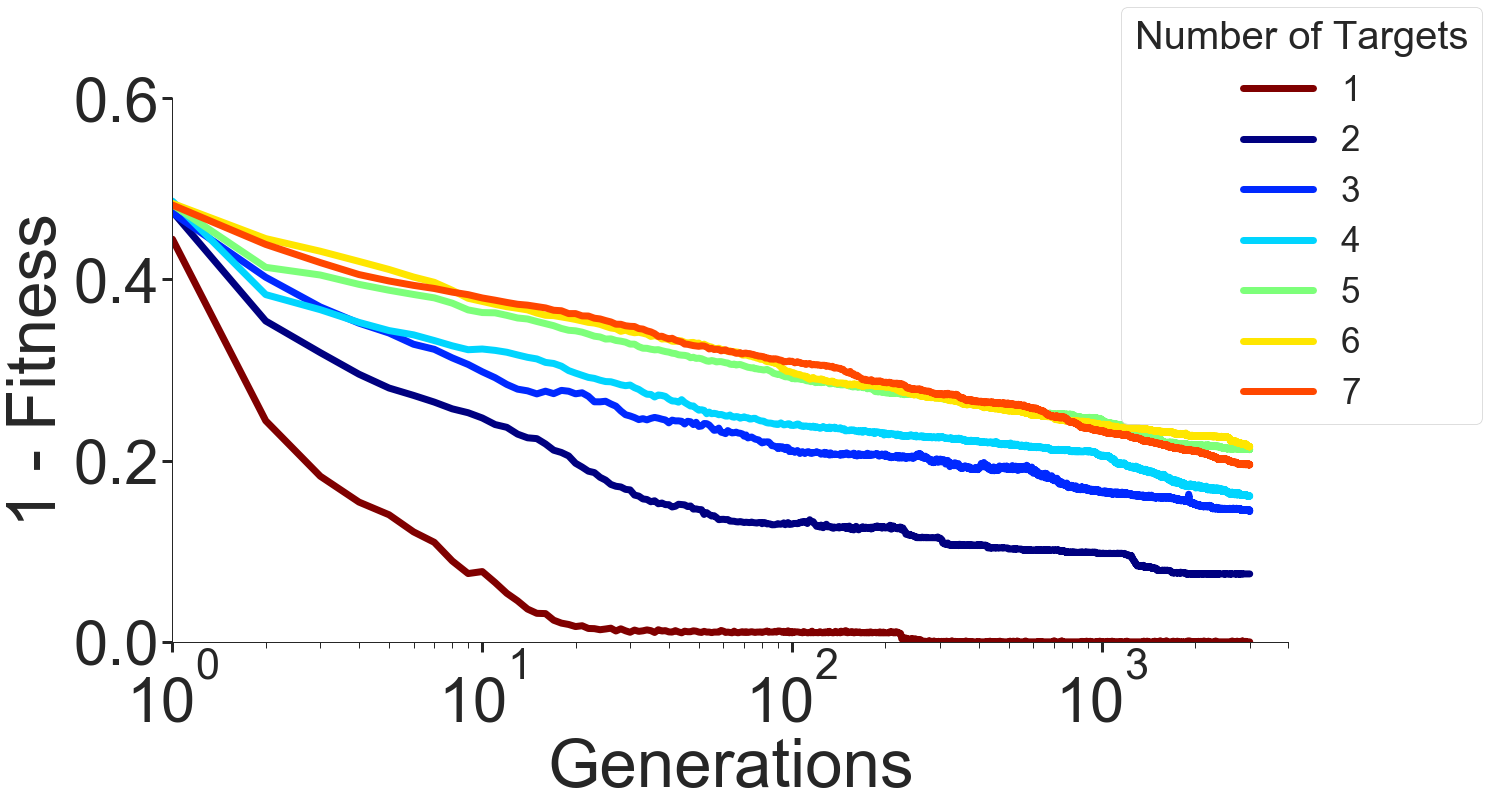

In [18]:
colors = plt.cm.jet(np.linspace(0,1,len(target_nums)))


for index in (target_nums):
    file_string = prefix + f"oscil_multiplex_evolution_run_500_1.9_sf_graph_{index}_targets.p"
    res = get_results(file_string)
    x,y = convert_to_avg(res)
    print(res)
    plt.semilogx(x,y, label=index, c= colors[index-2])
    
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(loc=(0.85,0.4), fontsize=35, title="Number of Targets")
legend.get_title().set_fontsize(40)
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/various_target_lens.pdf", bbox_inches="tight")
plt.show()

## Timescales of one network

In [7]:
prefix = "../../Results/NetworkEvolutions/learning_timescale_limits/"



In [34]:
ls $prefix

oscil_period_30_500_1.9_sf_graph_1_target.p
oscil_period_40_500_1.9_sf_graph_1_target.p
oscil_period_6_500_1.9_sf_graph_1_target.p


In [8]:
f1 = prefix + "oscil_period_6_500_1.9_sf_graph_1_target.p"
f2 = prefix + "oscil_period_30_500_1.9_sf_graph_1_target.p"
f3 = prefix + "oscil_period_40_500_1.9_sf_graph_1_target.p"

f1_res = get_results(f1)
f2_res = get_results(f2)
f3_res = get_results(f3)

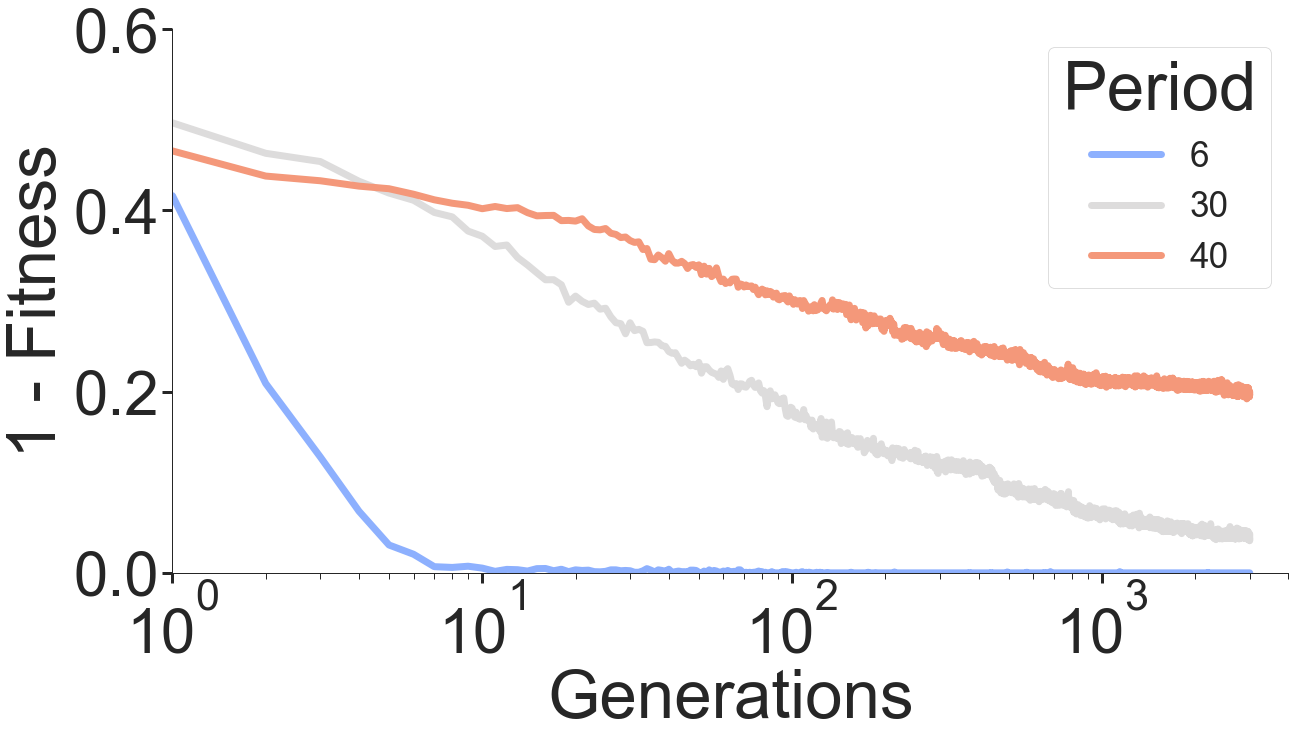

In [9]:
cols = sns.color_palette("coolwarm", 3)
my_list = [f1_res, f2_res, f3_res]
name = ["6", "30", "40"] 
for index, q in enumerate(my_list):
#     n_ = q['n']
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=name[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
plt.legend(loc="upper right", fontsize=35, title="Period")
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/varied_input_output.pdf", bbox_inches="tight")
plt.show()

## Difference in time scales

In [19]:
prefix = "../../Results/NetworkEvolutions/learning_timescale_gap/"



In [20]:
ls $prefix

oscil_multiplex_ev_run_500_1.9_sf_graph_2_targs_6_20.p
oscil_multiplex_ev_run_500_1.9_sf_graph_2_targs_6_30.p
oscil_multiplex_ev_run_500_1.9_sf_graph_2_targs_6_8.p


In [21]:
f1 = prefix + "oscil_multiplex_ev_run_500_1.9_sf_graph_2_targs_6_8.p"
f2 = prefix + "oscil_multiplex_ev_run_500_1.9_sf_graph_2_targs_6_20.p"
f3 = prefix + "oscil_multiplex_ev_run_500_1.9_sf_graph_2_targs_6_30.p"

f1_res = get_results(f1)
f2_res = get_results(f2)
f3_res = get_results(f3)

In [24]:
f1_res['scores'][:, 0:2]

array([[0.58944444, 0.55541667],
       [0.60652778, 0.5575    ],
       [0.56944444, 0.54875   ],
       [0.57805556, 0.55833333],
       [0.54388889, 0.53770833],
       [0.56766667, 0.48625   ],
       [0.60333333, 0.6       ],
       [0.52666667, 0.3775    ],
       [0.61166667, 0.58645833],
       [0.535     , 0.495     ]])

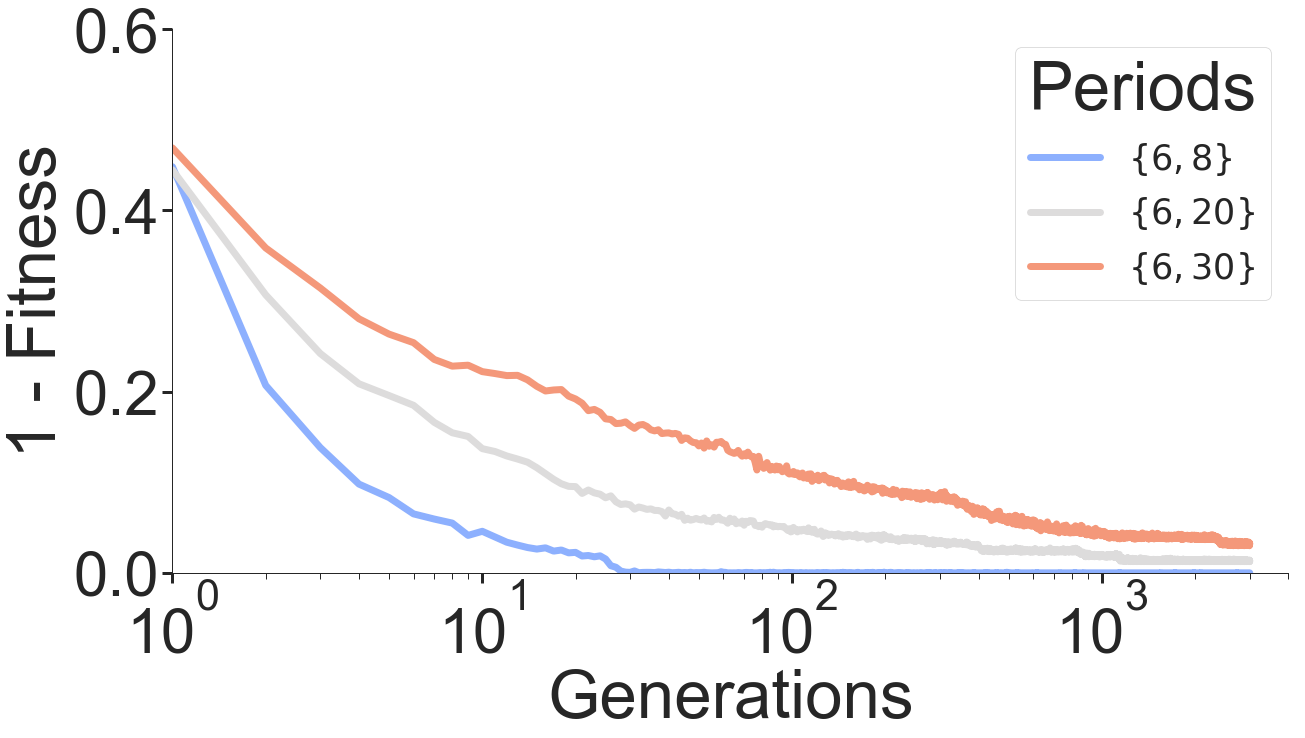

In [30]:
cols = sns.color_palette("coolwarm", 3)
my_list = [f1_res, f2_res, f3_res]
name = ["$\{6,8\}$", "$\{6,20\}$", "$\{6,30\}$"] 
for index, q in enumerate(my_list):
#     n_ = q['n']
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=name[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
plt.legend(loc="upper right", fontsize=35, title="Periods")
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/learning_gap.pdf", bbox_inches="tight")
plt.show()

## Learning vs. gamma
Use different gammas and see how they learn to pair 6,8,10 to targets 6,8,10

In [17]:
### Note: This used to be hidden and tucked away in select delay

prefix = "../../Results/NetworkEvolutions/different_gammas/"
gammas=[1.7,1.8,1.9,2.0,2.2,3.0]
files = [f"oscil_500_{i}_sf_graph_3_targets.p" for i in gammas]
res = [] 
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))








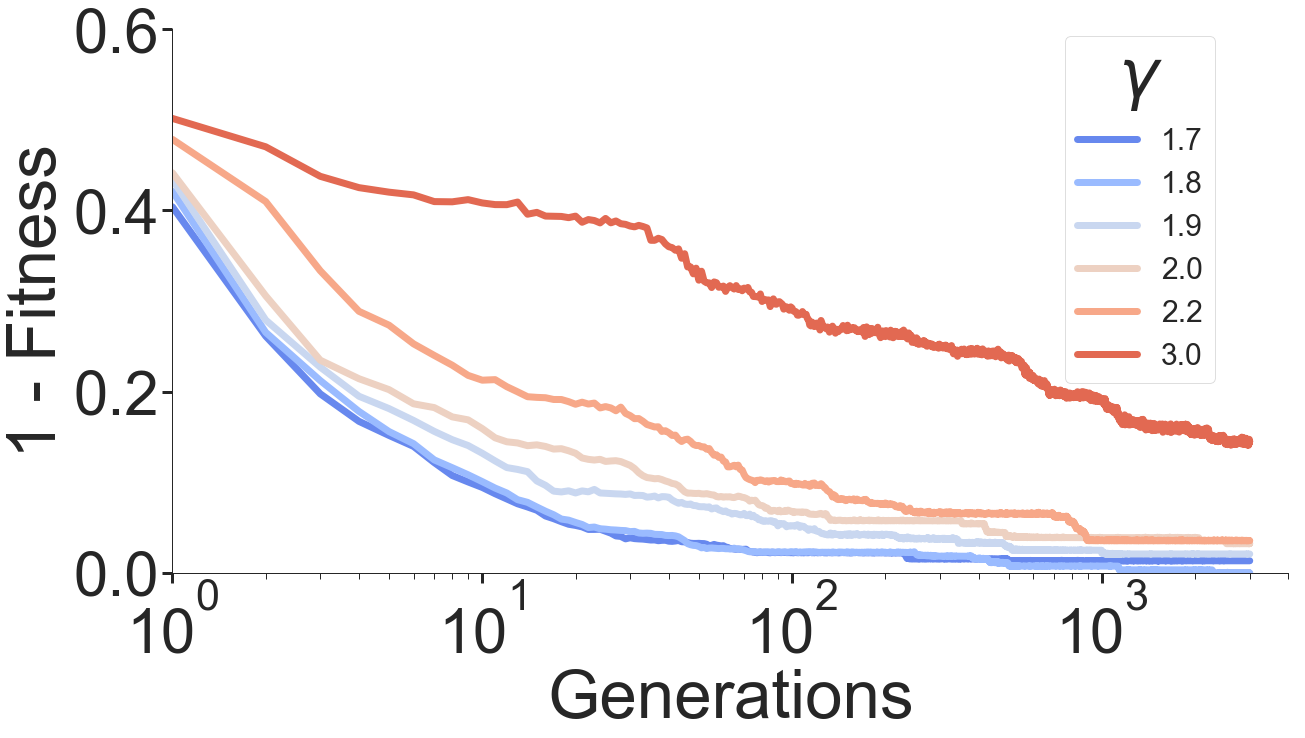

In [21]:
cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))

for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=gammas[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=30, title="$\gamma$", loc=(0.8,0.35))
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/diff_gammas.pdf", bbox_inches="tight")
plt.show()

## Checking if resonance frequency has any effect on the network

We take a network we want to evolve. We sample from one random condition how the network evolves and take the power spectra of each node. We sort by nodes that have the highest response at period $T_{res}=4$, that is power at $f = \frac{1}{T_{res}}$.  We use this node as our target node for the given simulation. 

We run several of these simulations, generating our target node in this form, trying to learn a target of T=10 or T=4 on this node identified using $T_{res}$. As a control, we use an input period of $10$ and choose a random target with target lengths T=10 and T=4. 

In [5]:
prefix = "../../Results/NetworkEvolutions/testing_resonance/"

non_picked = [10,5,4]
picked = [5,4]
res = []
for i in non_picked: 
    res.append(get_results(prefix + f"per_10_targ_{i}_oscil.p"))
for i in picked: 
    res.append(get_results(prefix + f"freq_sel_{i}_per_10_targ_10.p"))
    res.append(get_results(prefix + f"freq_sel_{i}_per_10_targ_{i}.p"))

labels = ["$L_{targ} = 10$",
         "$L_{targ} = 5$",
         "$L_{targ} = 4$",
         "$T_{res} = 5, L_{targ} = 10$",
         "$T_{res} = 5, L_{targ} = 5$",
         "$T_{res} = 4, L_{targ} = 10$",
         "$T_{res} = 4, L_{targ} = 4$"]

cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))

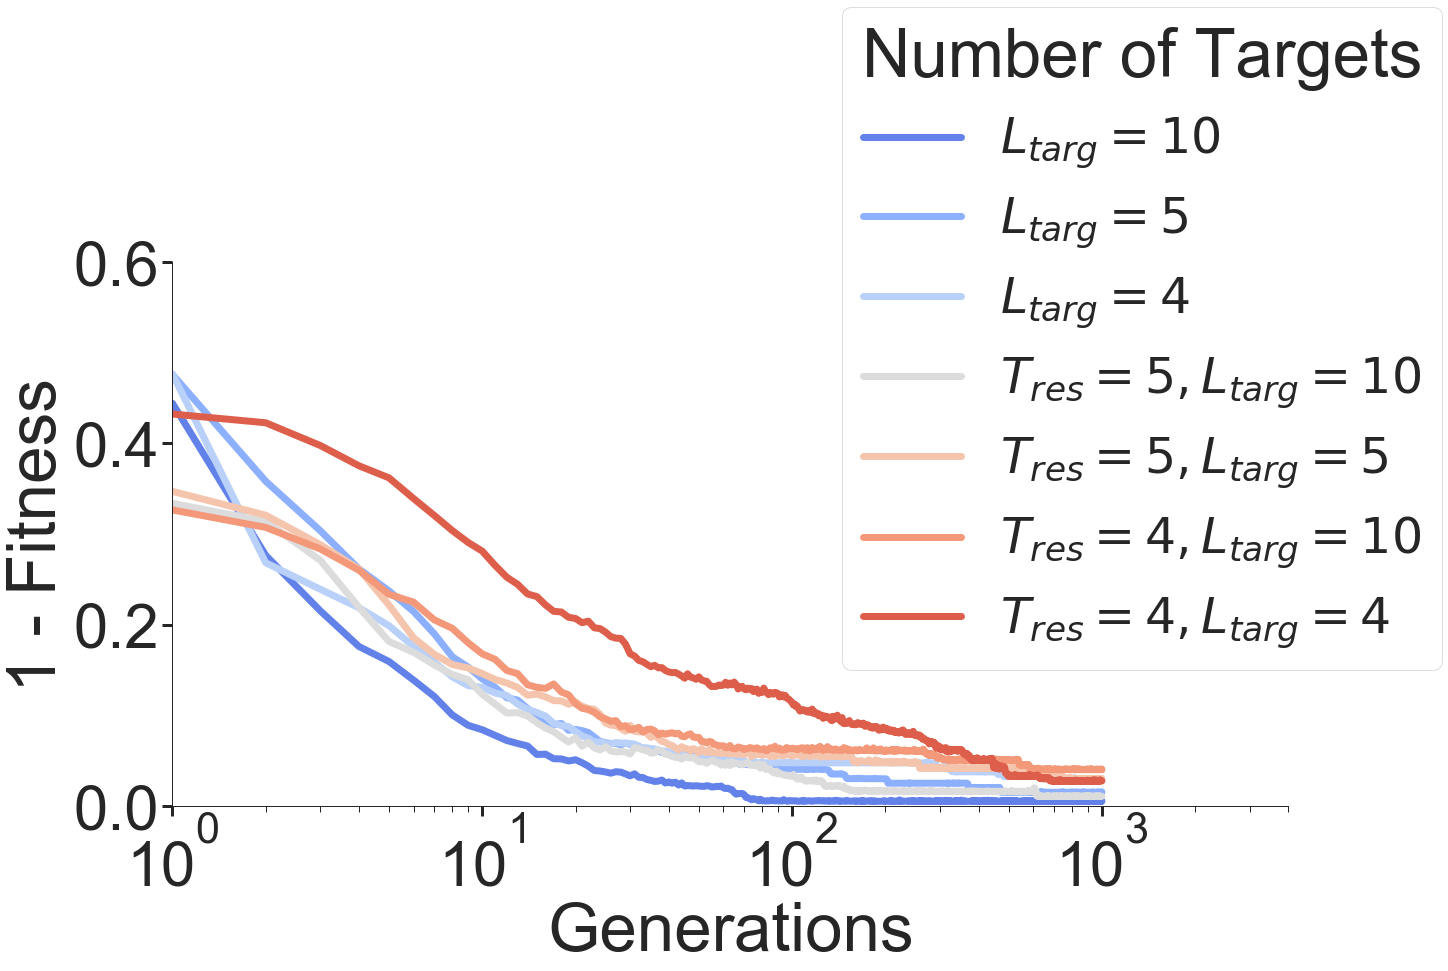

In [7]:



for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=labels[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/oscil_multi_target.pdf", bbox_inches="tight")
plt.show()

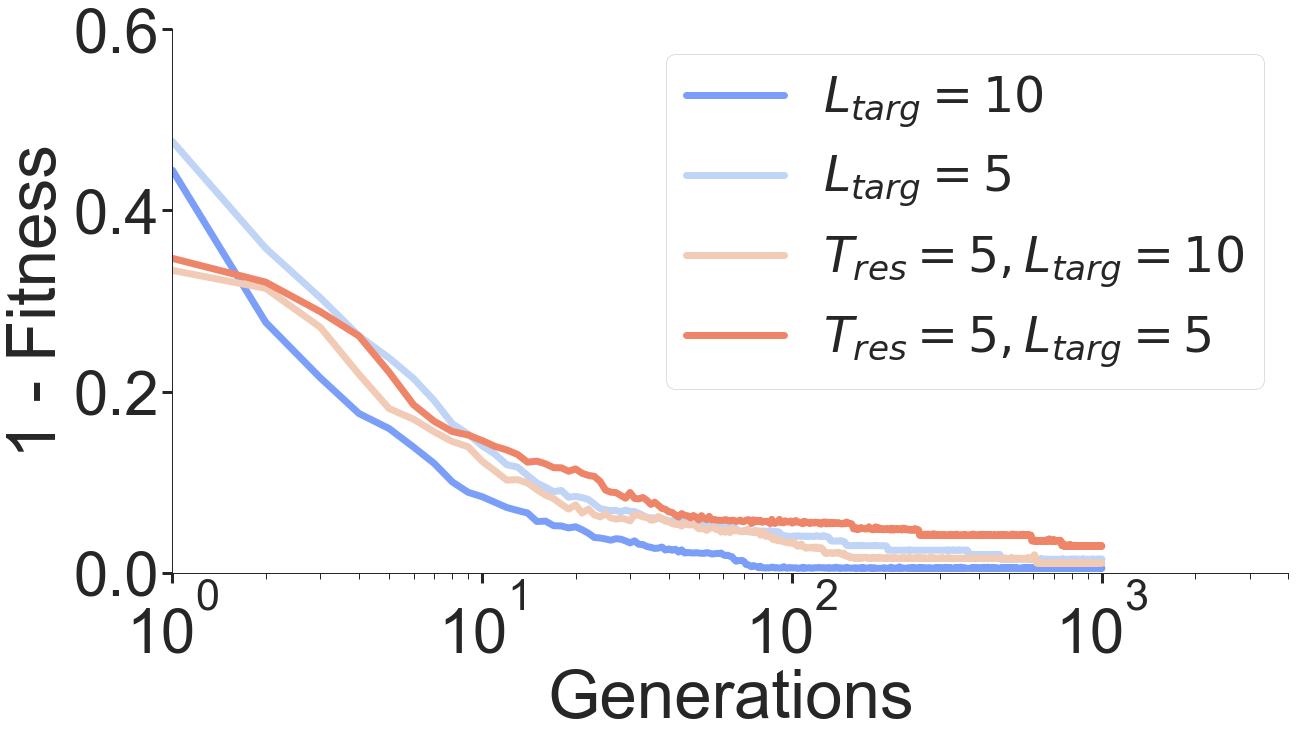

In [7]:

indices = [0,1,3,4]
cols = sns.color_palette("coolwarm", len(indices)) #plt.cm.jet(np.linspace(0,1,len(res)))
for i, index in enumerate(indices):
    q = res[index]
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=labels[index], c = cols[i])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=49)#, loc=(0.6,0.25))
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/oscil_multi_target.pdf", bbox_inches="tight")
plt.show()

## Using fixed input states instead of frequency

### Blocked hub at ON 

In [19]:
### Note: This used to be hidden and tucked away in select delay

prefix = "../../Results/NetworkEvolutions/fixed_start_limit_learning/"
files = [f"fixed_start_multiplex_evolution_run_500_1.9_sf_graph_{i}_targets.p" for i in range(1,8)]
res = [] 
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))




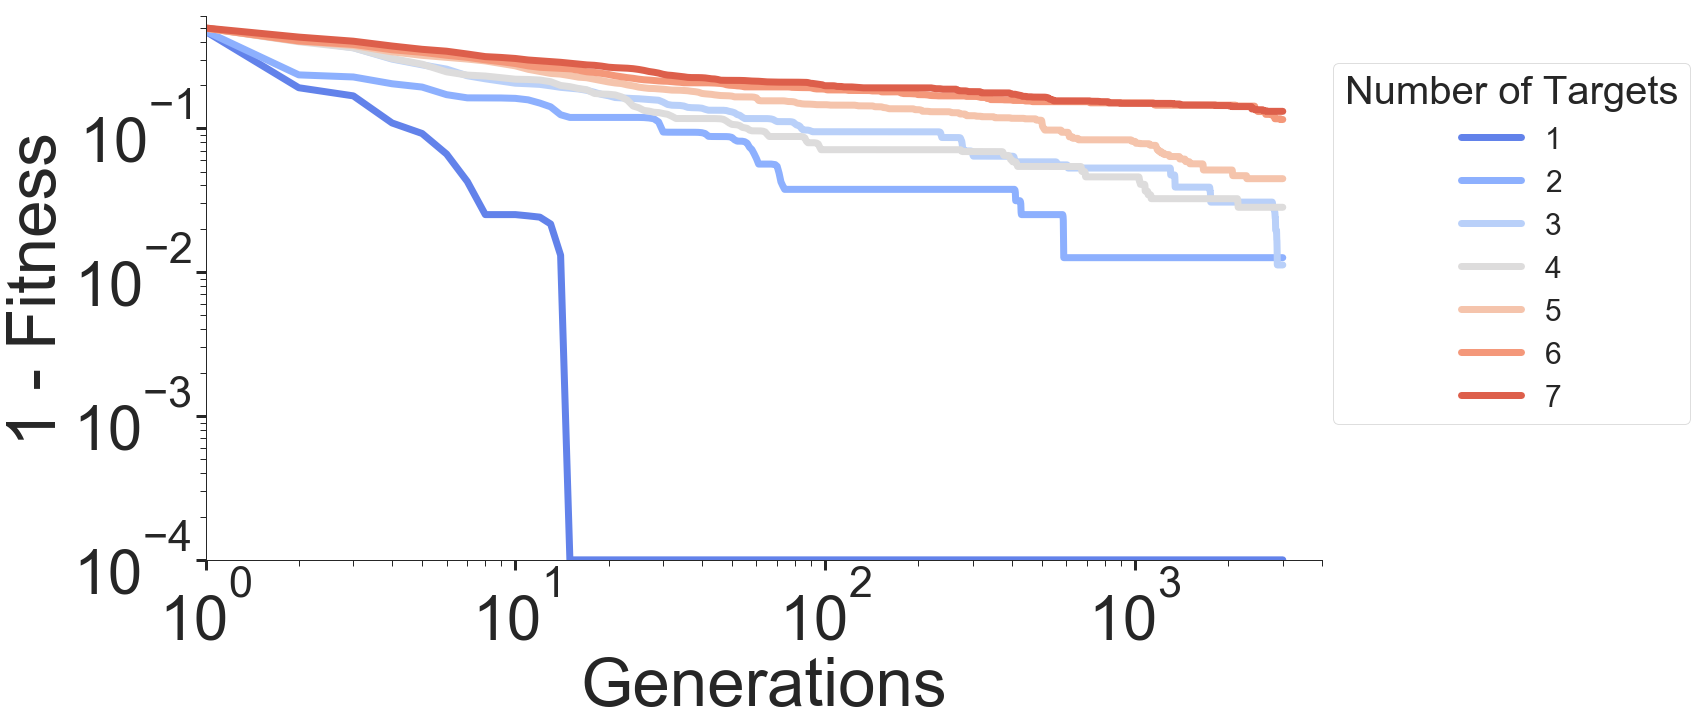

In [21]:
# cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
# num_targets = range(1,8)
# for index, q in enumerate(res):
#     x,y = convert_to_avg(q)
#     plt.semilogx(x,y, label=num_targets[index], c = cols[index])
# plt.xlabel("Generations")
# plt.ylabel("1 - Fitness")
# legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))
# plt.ylim([0,0.6])
# plt.xlim([1,4000])
# plt.savefig("/Users/samgoldman/Desktop/fixed_multi_target.pdf", bbox_inches="tight")
# plt.show()

### Note: This used to be hidden and tucked away in select delay

cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,8)
for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    plt.loglog(x,y+0.0001, label=num_targets[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=30, title="Number of Targets", loc=(1.01,0.25))
legend.get_title().set_fontsize(40)
plt.ylim([0.0001,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/fixed_multi_target.pdf", bbox_inches="tight")
plt.show()

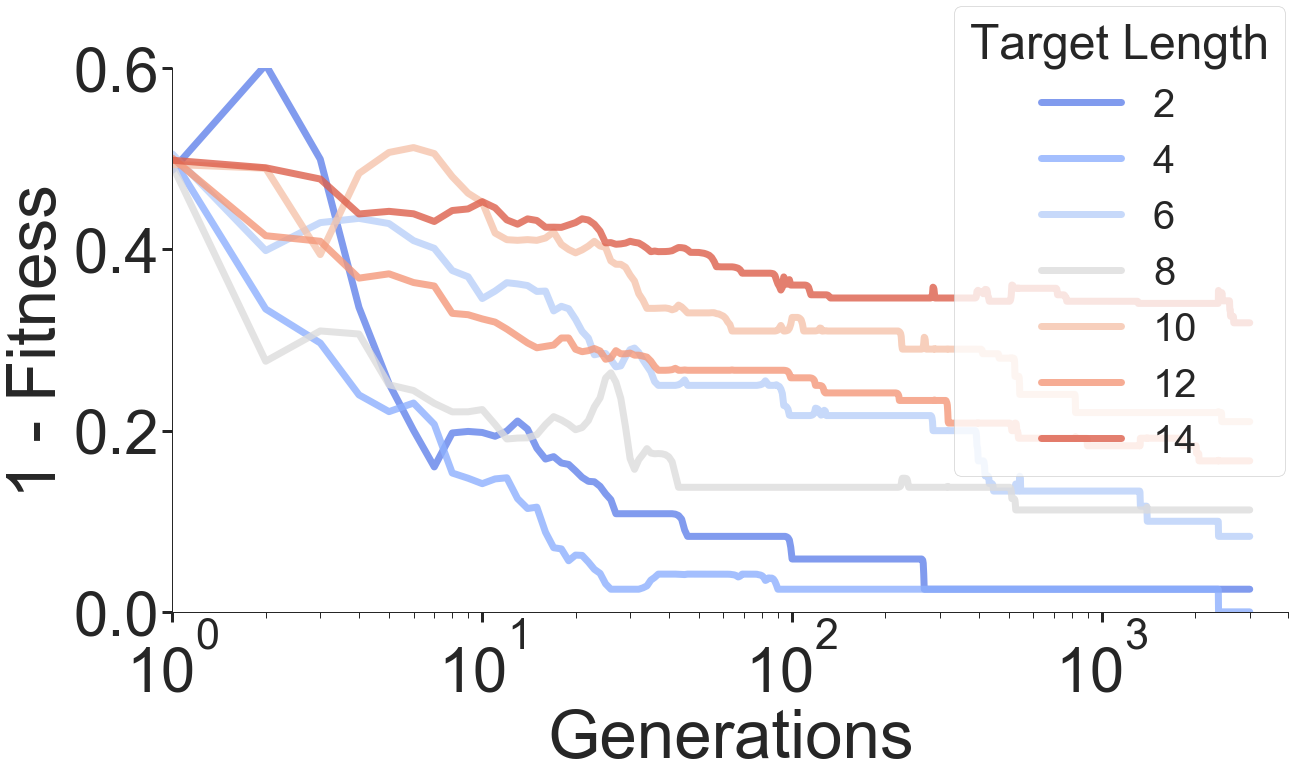

In [13]:
break_out_into_tracks(res[-1])
plt.savefig("/Users/samgoldman/Desktop/one_run_7_targets_fixed.pdf", bbox_inches="tight")

### Free Hub

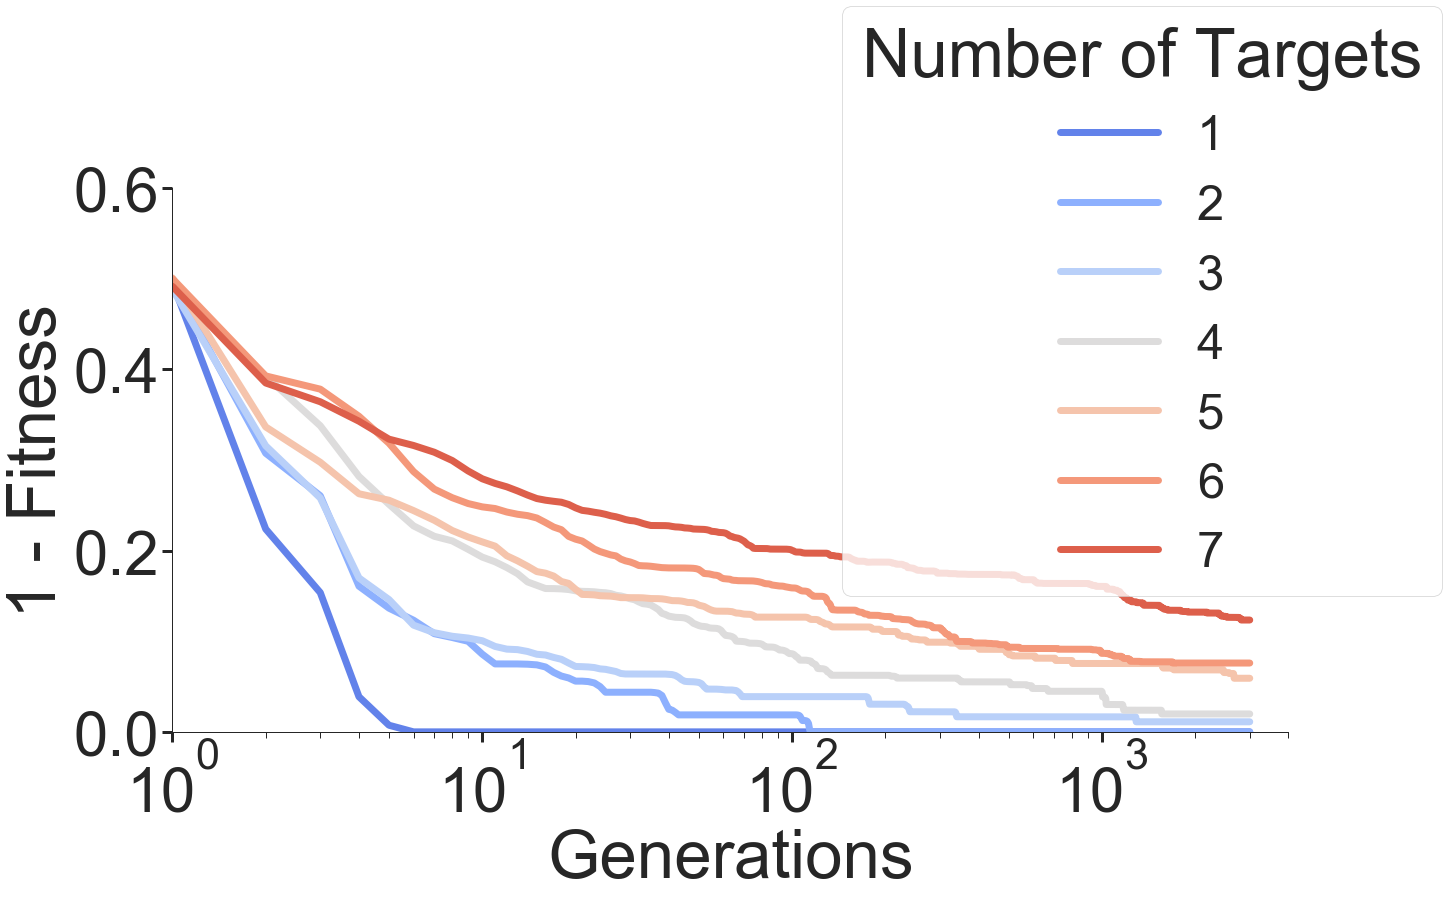

In [44]:
### Note: This used to be hidden and tucked away in select delay

prefix = "../../Results/NetworkEvolutions/fixed_start_free_hub_limit_learning/"
files = [f"fixed_start_multiplex_evolution_run_500_1.9_sf_graph_{i}_targets.p" for i in range(1,8)]
res = [] 
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))




cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,8)
for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=num_targets[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/fixed_start_free_hub_limit_learning.pdf", bbox_inches="tight")
plt.show()

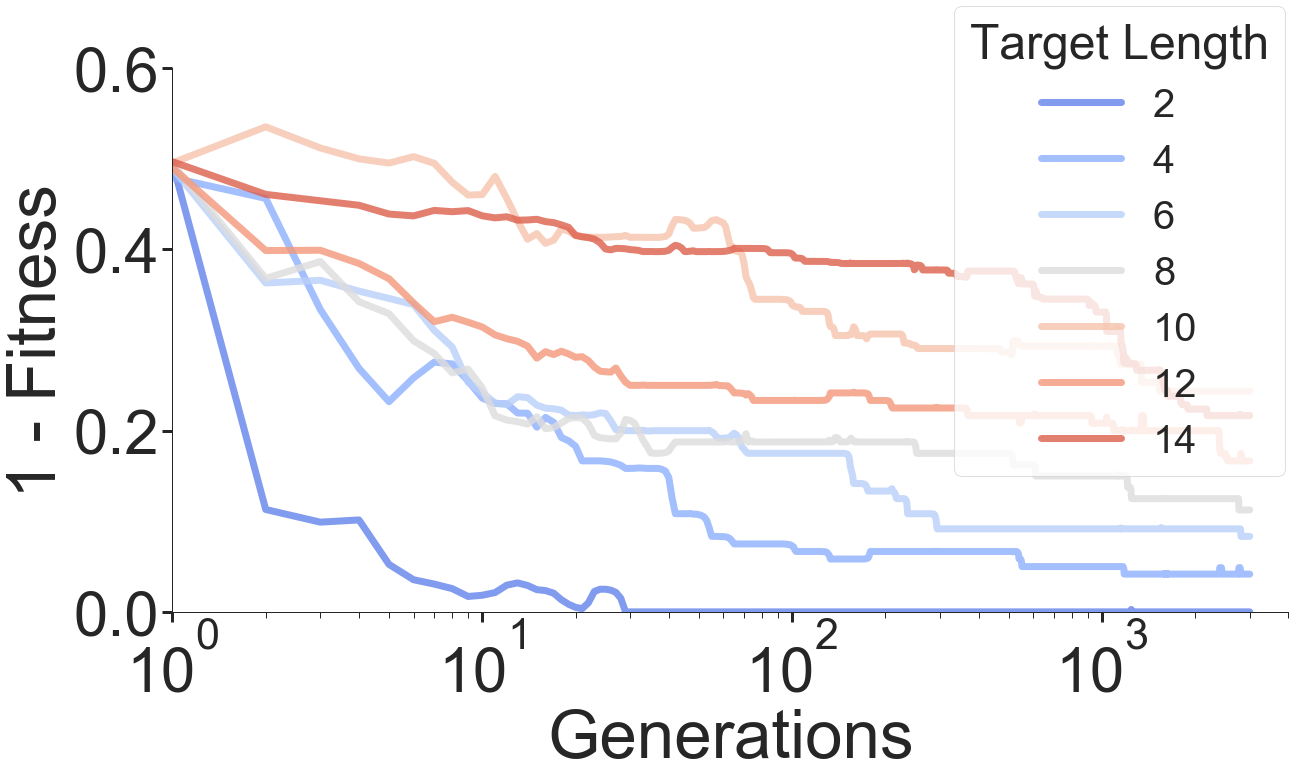

In [45]:
break_out_into_tracks(res[-1])
plt.savefig("/Users/samgoldman/Desktop/one_run_7_targets_fixed_free_Hub.pdf", bbox_inches="tight")

## Same size target..

### Blocked hub at ON

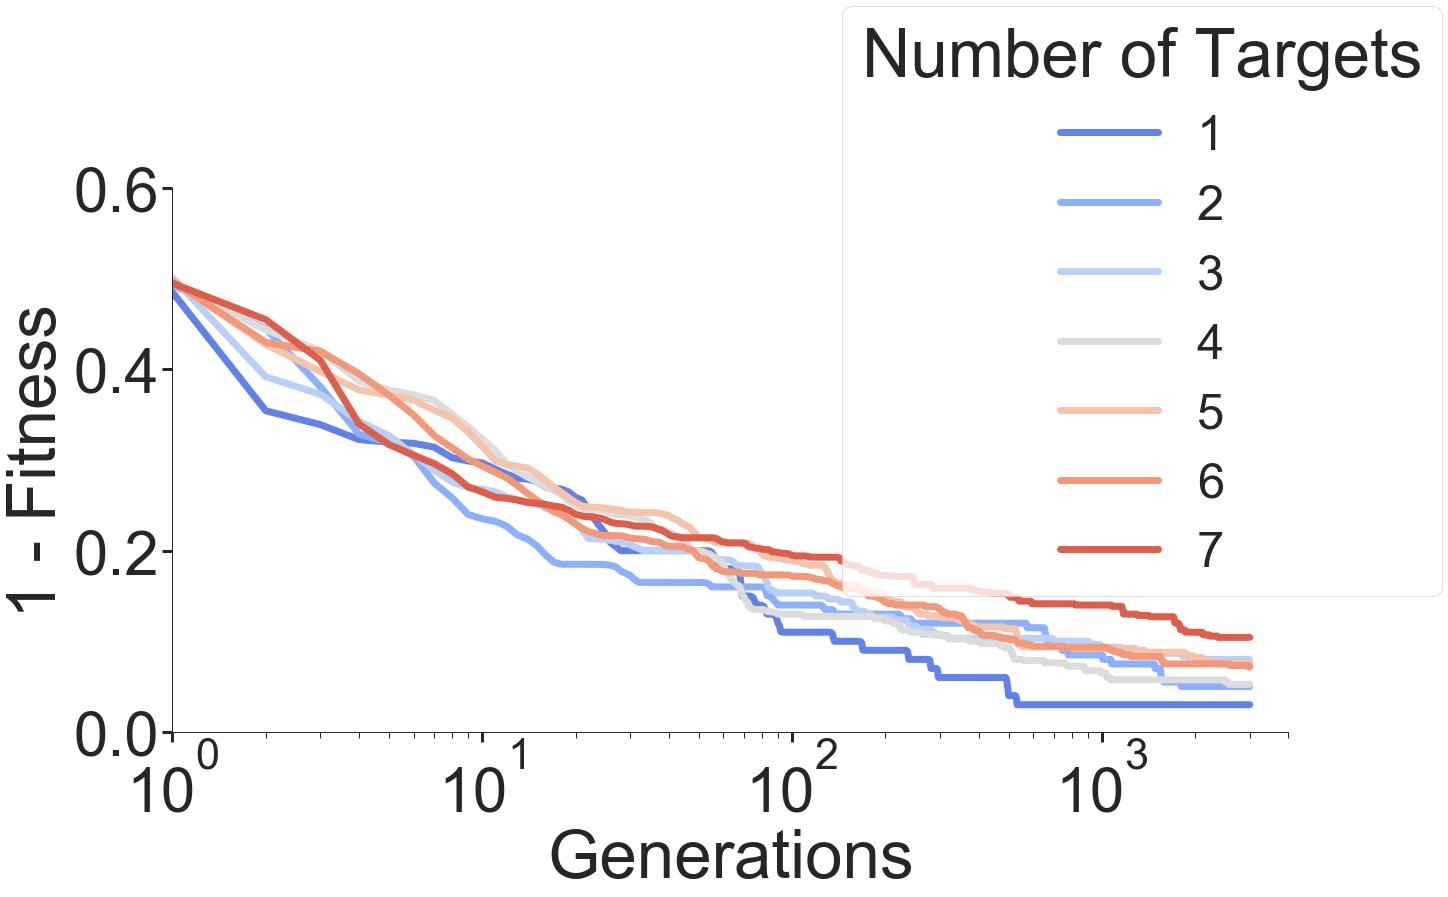

In [14]:
### Note: This used to be hidden and tucked away in select delay

prefix = "../../Results/NetworkEvolutions/fixed_start_same_size_attr/"
files = [f"fixed_start_multiplex_evolution_run_500_1.9_sf_graph_{i}_targets.p" for i in range(1,8)]
res = [] 
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))




cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,8)
for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=num_targets[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/fixed_multi_target.pdf", bbox_inches="tight")
plt.show()

### Blocked hub free

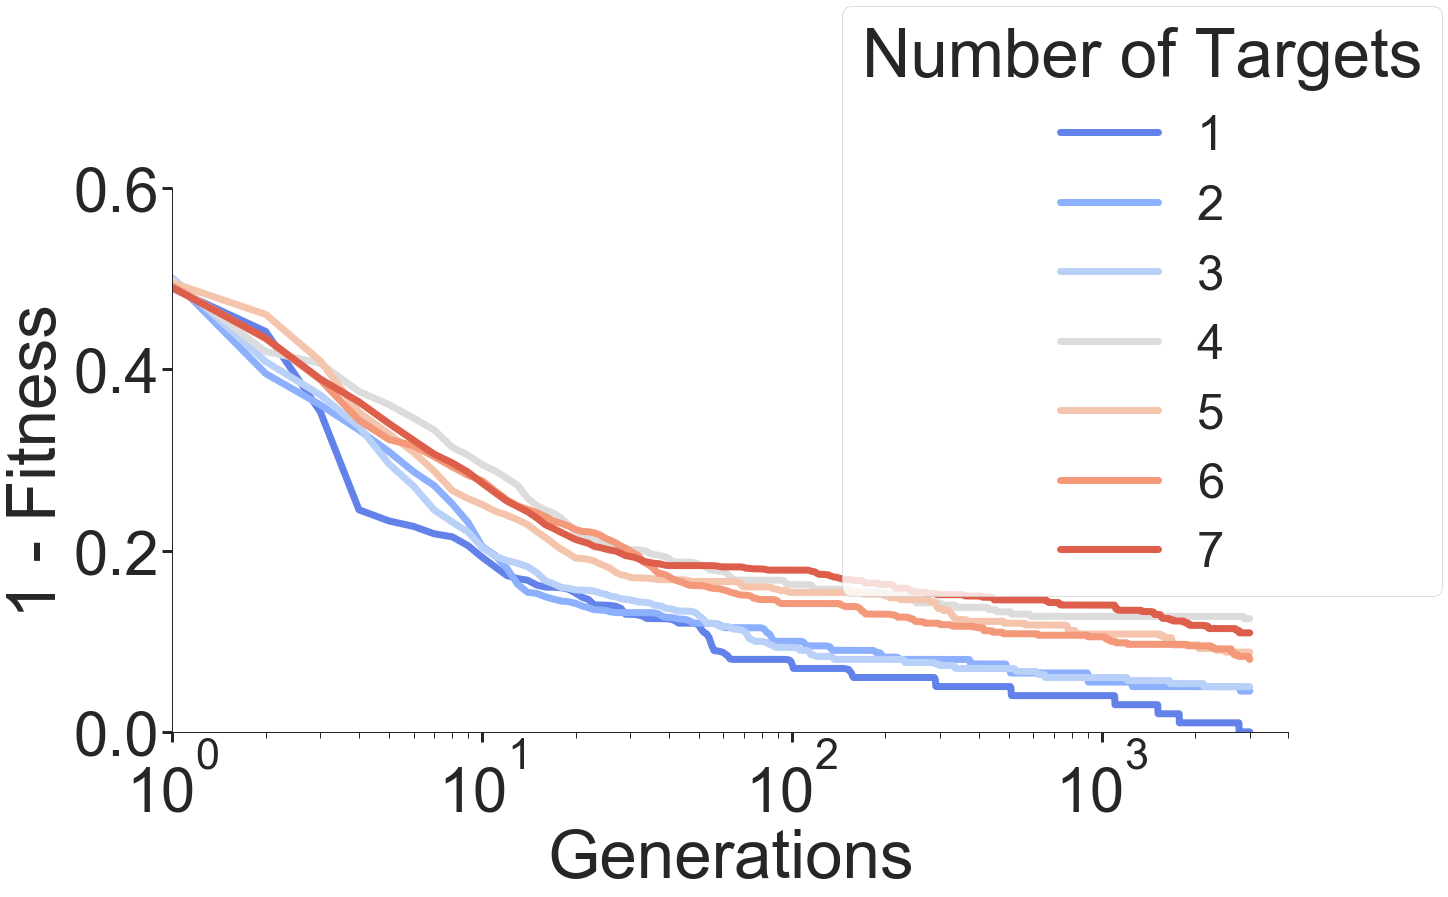

In [46]:
### Note: This used to be hidden and tucked away in select delay

prefix = "../../Results/NetworkEvolutions/fixed_free_hub_same_size_attr/"
files = [f"fixed_start_multiplex_evolution_run_500_1.9_sf_graph_{i}_targets.p" for i in range(1,8)]
res = [] 
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))




cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,8)
for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    plt.semilogx(x,y, label=num_targets[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))
plt.ylim([0,0.6])
plt.xlim([1,4000])
plt.savefig("/Users/samgoldman/Desktop/fixed_free_hub_same_size_attr.pdf", bbox_inches="tight")
plt.show()

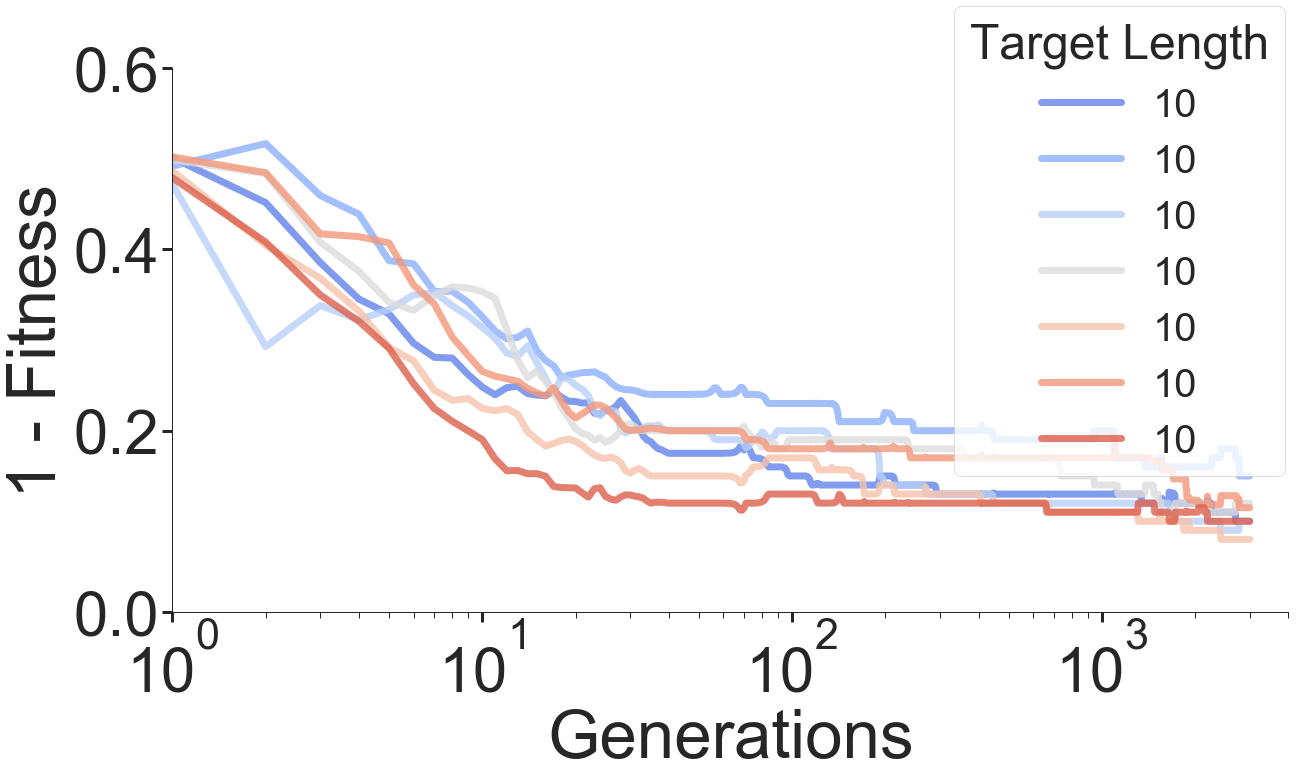

In [47]:
break_out_into_tracks(res[-1])
plt.savefig("/Users/samgoldman/Desktop/one_run_7_targets_fixed_same_size_free.pdf", bbox_inches="tight")

## Long evolutionary trials

In [29]:
num_files = 7
num_files += 1

prefix = "../../Results/NetworkEvolutions/long_ev_runs/"
files = [f"long_oscil_multiplex_{i}_target.p" for i in range(1,num_files)]
res = [] 
res_avged = []
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))
    x,y = convert_to_avg(res[-1])
    res_avged.append((x,y))

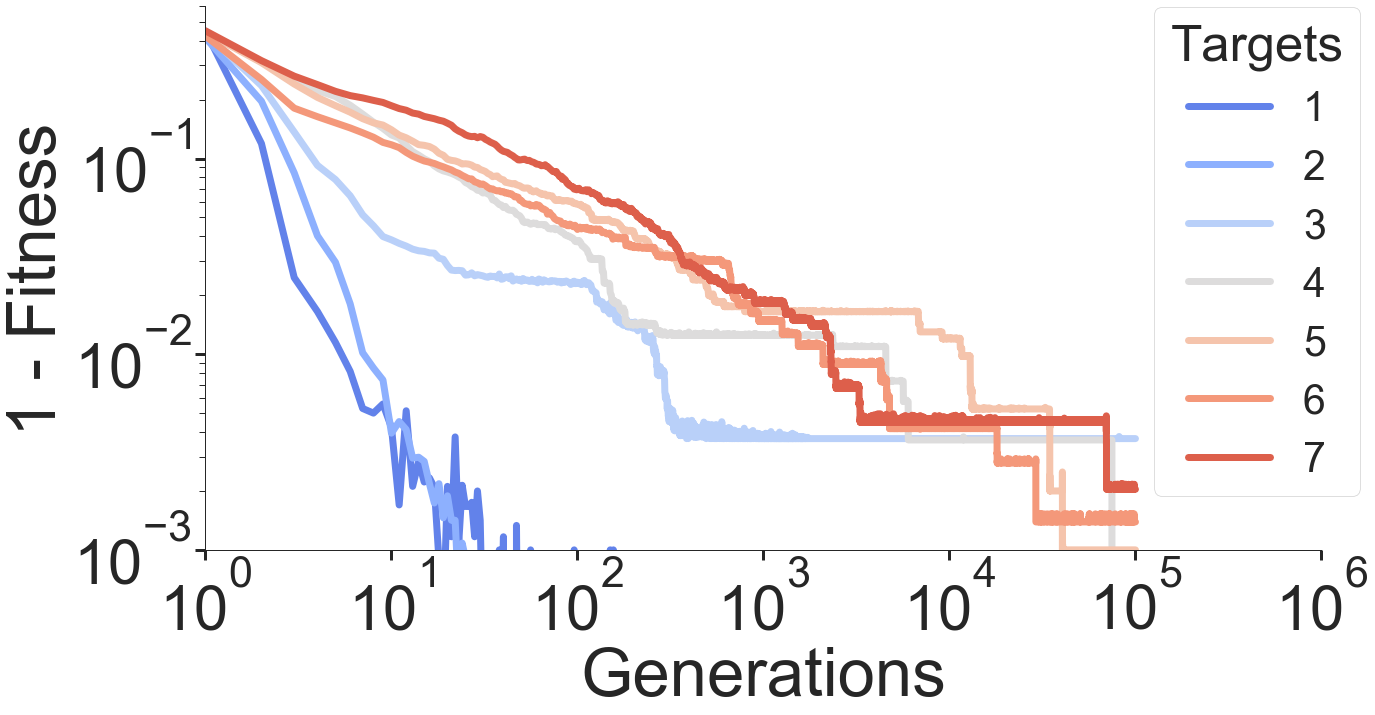

In [30]:

### Note: This used to be hidden and tucked away in select delay



cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,num_files)
for index, (x,y) in enumerate(res_avged):
    #plt.semilogx(x,y, label=num_targets[index], c = cols[index])
    plt.loglog(x,y, label=num_targets[index], c = cols[index])    
    
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
# Semilog
# legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))

# Loglog
font_bump = 16
loc = (0.85, 0.1) # (0.8, 0.4)
legend = plt.legend(fontsize=25+font_bump, title="Targets", loc=loc,
                   #ncol=2
                   ) 
legend.get_title().set_fontsize(35 + font_bump)


# Semilog
# plt.ylim([0,0.6])

## Loglog
plt.ylim([0.001,0.6])
plt.xlim([1,10e5])
plt.xticks([10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6])


# Semilog
# plt.savefig("/Users/samgoldman/Desktop/long_oscil_learning.pdf", bbox_inches="tight")

# loglog
plt.savefig("/Users/samgoldman/Desktop/long_oscil_learning_log_log.pdf", bbox_inches="tight")


plt.show()

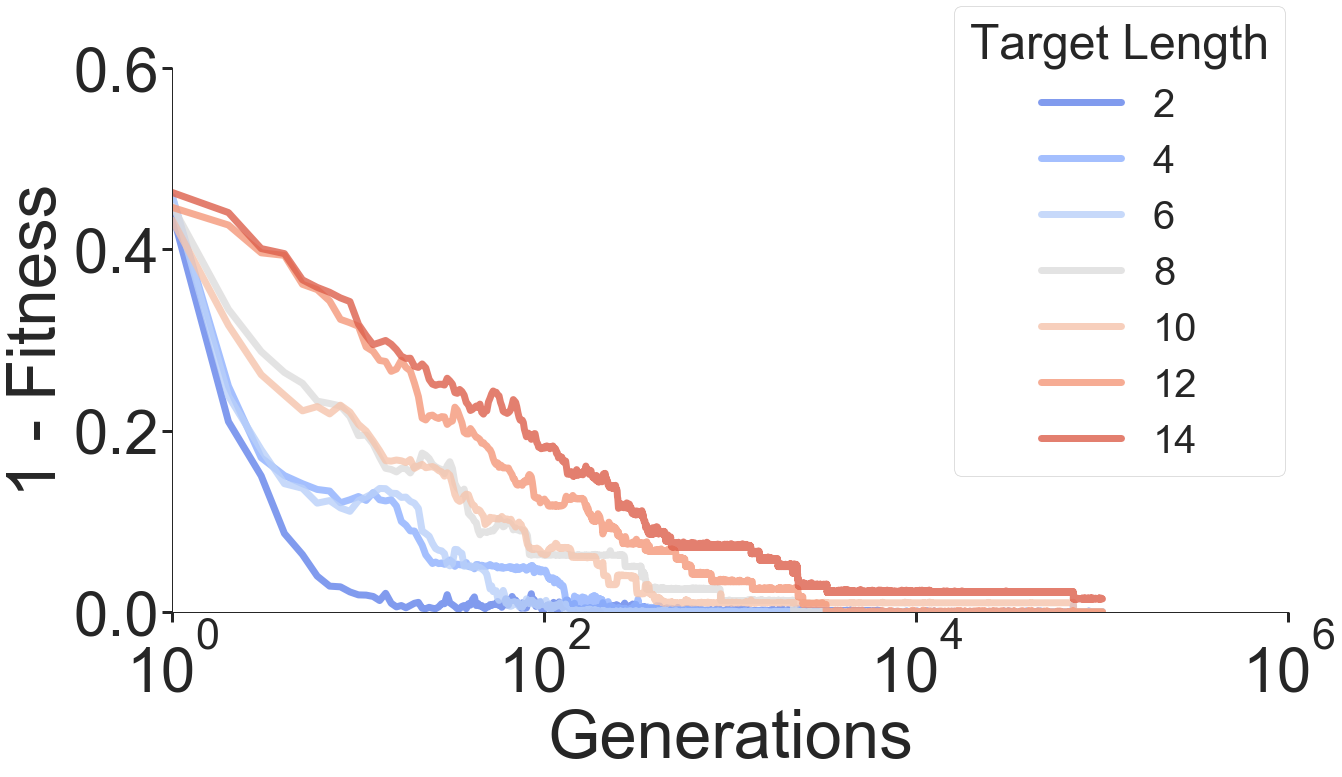

In [116]:
break_out_into_tracks(res[-1])
plt.xlim([1,10e5])
plt.savefig("/Users/samgoldman/Desktop/long_oscil_7_tracks.pdf", bbox_inches="tight")

In [11]:
streak = 0
longest_streak = 0
ctr = 0 
for i in res[0]['scores'].mean(0): 
    if i == 1: 
        streak += 1
    else: 
        if streak > longest_streak: 
            longest_streak = streak
        streak = 0 
    ctr += 1
longest_streak = streak

longest_streak

37889

/Users/samgoldman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


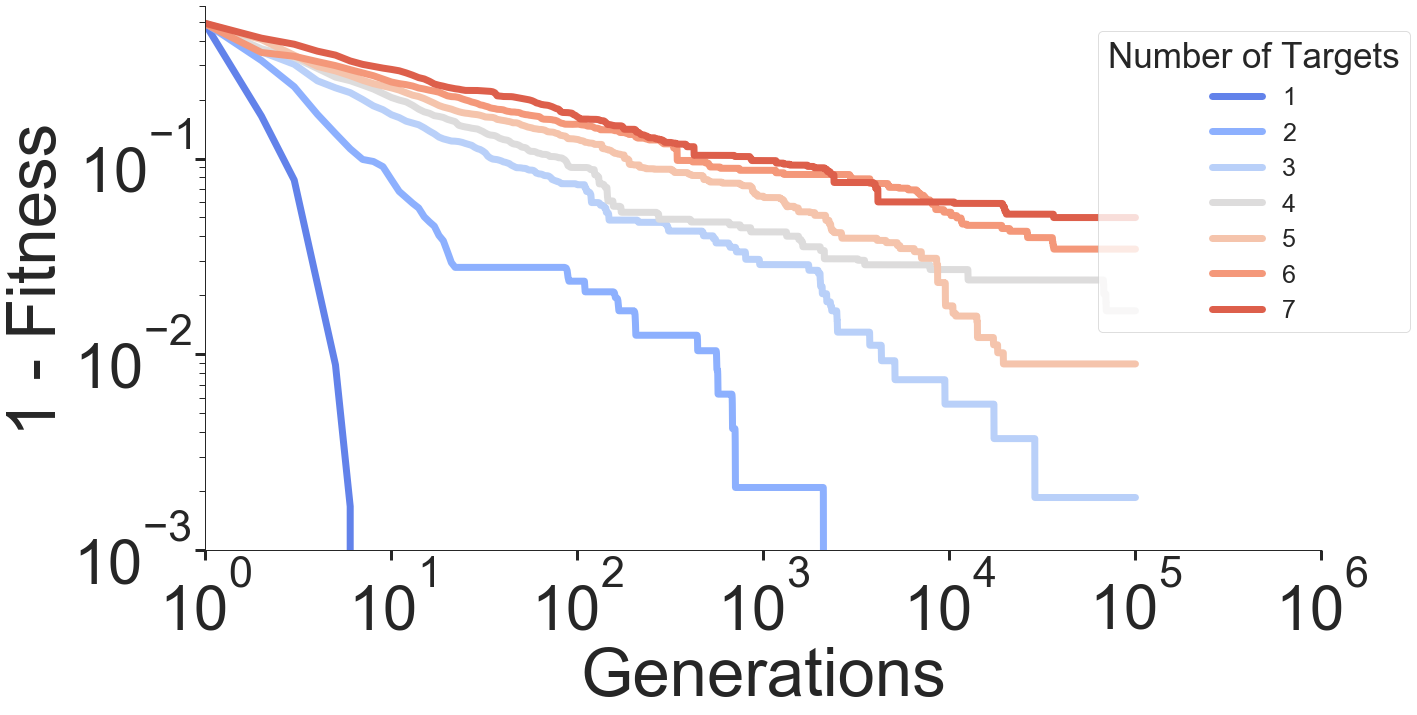

In [117]:
prefix = "../../Results/NetworkEvolutions/long_ev_runs/"
files = [f"long_fixed_multiplex_{i}_target_free.p" for i in range(1,num_files)]
res = [] 
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))


cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,num_files)
for index, q in enumerate(res):
    x,y = convert_to_avg(q)
    # Semilog
#     plt.semilogx(x,y, label=num_targets[index], c = cols[index])
    # loglog
    plt.loglog(x,y, label=num_targets[index], c = cols[index])
plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
# Semilog
# legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))

# Loglog
font_bump = 16
loc = (0.7, 0.4) # (0.8, 0.4)
legend = plt.legend(fontsize=25+font_bump, title="Number of Targets", loc=loc,
                   ncol=2) 
legend.get_title().set_fontsize(35 + font_bump)

# Semilog
plt.ylim([0,0.6])
## Loglog
plt.ylim([0.001,0.6])
plt.xlim([1,10e5])
plt.xticks([10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6])


# Semilog
# plt.savefig("/Users/samgoldman/Desktop/long_fixed_learning.pdf", bbox_inches="tight")

# loglog
plt.savefig("/Users/samgoldman/Desktop/long_fixed_learning_log_log_free.pdf", bbox_inches="tight")





plt.show()


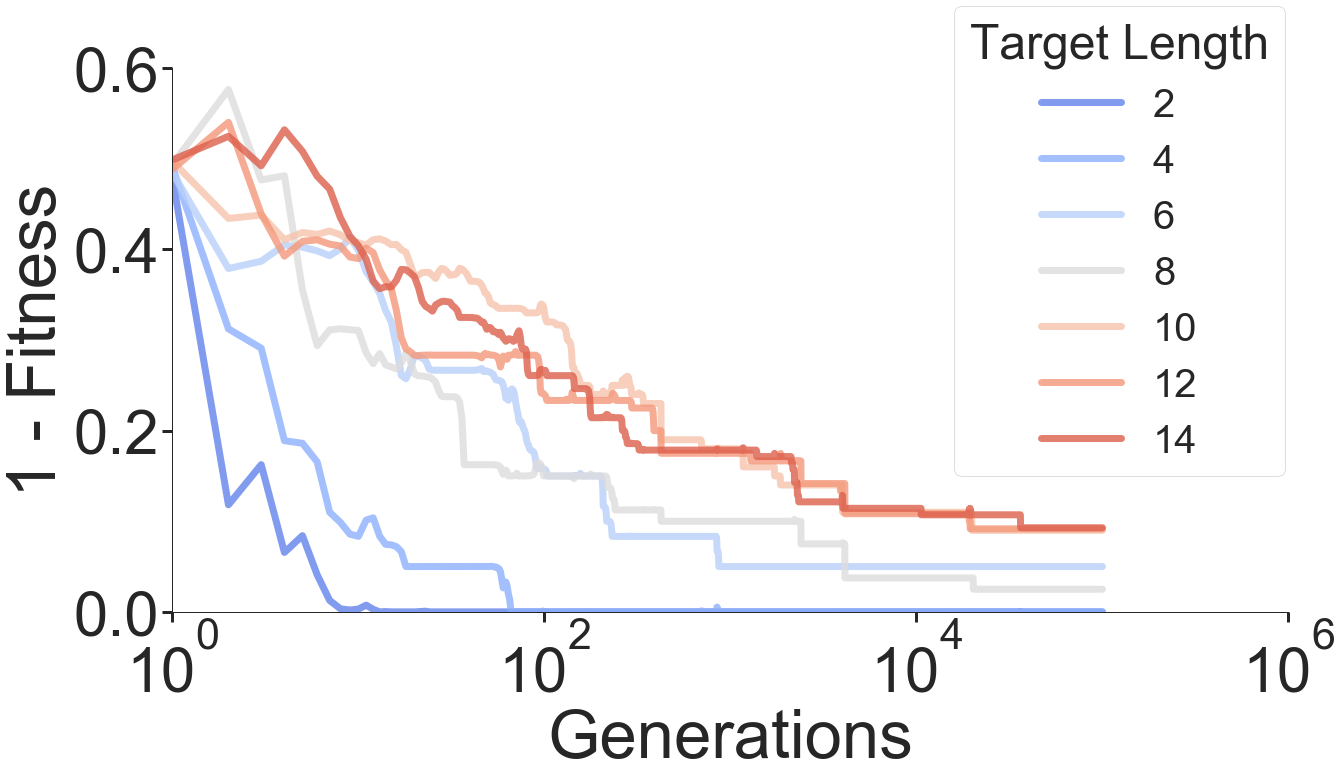

In [118]:
break_out_into_tracks(res[-1])
plt.xlim([1,10e5])
plt.savefig("/Users/samgoldman/Desktop/long_fixed_free_7_tracks.pdf", bbox_inches="tight")

In [24]:
num_files = 7
num_files += 1
prefix = "../../Results/NetworkEvolutions/long_ev_runs/"
files = [f"long_fixed_multiplex_{i}_target_const.p" for i in range(1,num_files)]
res = [] 
res_avged = []
for i in files:
    temp_file = prefix + i
    res.append(get_results(temp_file))
    x,y = convert_to_avg(res[-1])
    res_avged.append((x,y))


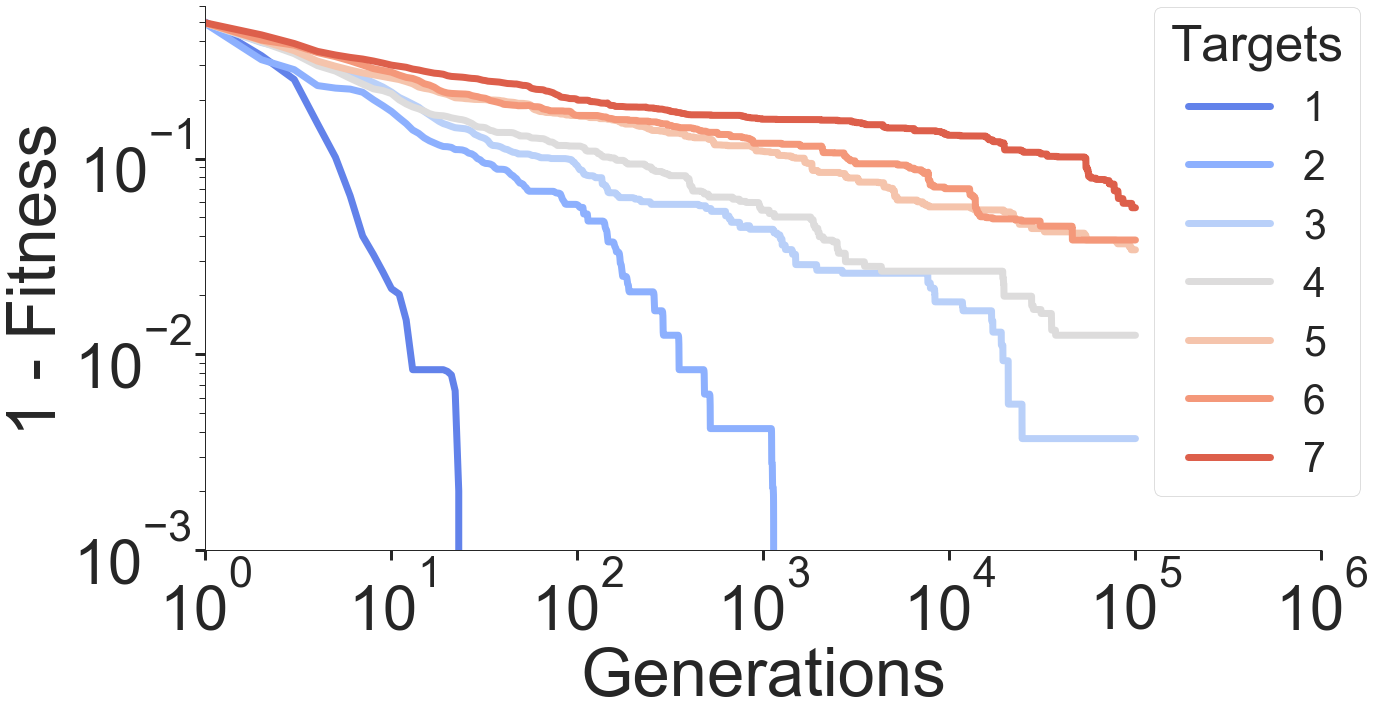

In [28]:


cols = sns.color_palette("coolwarm", len(res)) #plt.cm.jet(np.linspace(0,1,len(res)))
num_targets = range(1,num_files)
for index, (x,y) in enumerate(res_avged):
#     plt.semilogx(x,y, label=num_targets[index], c = cols[index])
    plt.loglog(x,y, label=num_targets[index], c = cols[index])


plt.xlabel("Generations")
plt.ylabel("1 - Fitness")
# Semilog
# legend = plt.legend(fontsize=49, title="Number of Targets", loc=(0.6,0.25))

# Loglog
font_bump = 16
loc = (0.85, 0.1) # (0.8, 0.4)
legend = plt.legend(fontsize=25+font_bump, title="Targets", loc=loc,
                   #ncol=2
                   ) 
legend.get_title().set_fontsize(35 + font_bump)


# Semilog
# plt.ylim([0,0.6])
# plt.xlim([1,10e5])


## Loglog
plt.ylim([0.001,0.6])
plt.xlim([1,10e5])
plt.xticks([10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6])


# Semilog
# plt.savefig("/Users/samgoldman/Desktop/long_fixed_const_learning.pdf", bbox_inches="tight")

# loglog
plt.savefig("/Users/samgoldman/Desktop/long_fixed_const_learning_loglog.pdf", bbox_inches="tight")


plt.show()



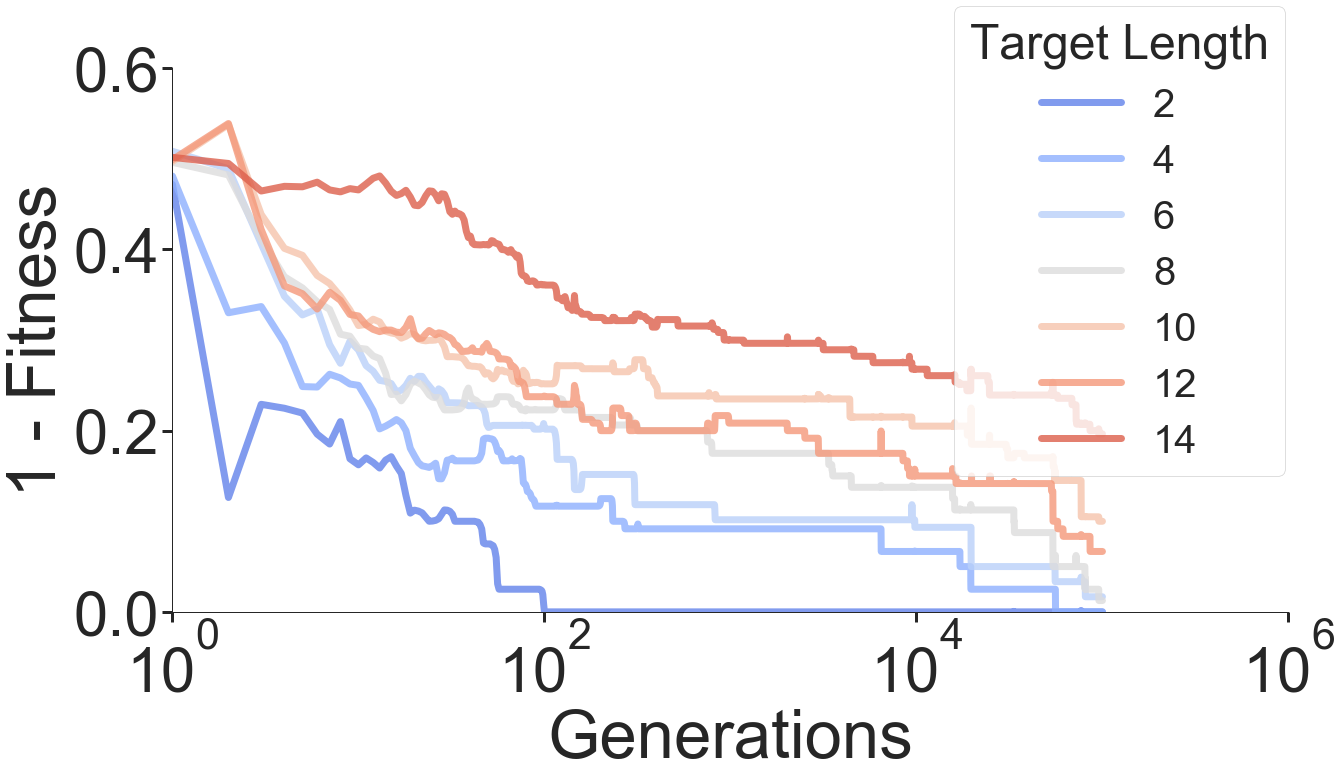

In [120]:
break_out_into_tracks(res[-1])
plt.xlim([1,10e5])
plt.savefig("/Users/samgoldman/Desktop/long_fixed_const_7_tracks.pdf", bbox_inches="tight")

### Summary Plotting

Plot the summary of many different plots... As a first step, let's pick a time point, and just bar plot them next to eachother 

In [31]:
### Note: This used to be hidden and tucked away in select delay
num_files = 7
num_files += 1

prefix = "../../Results/NetworkEvolutions/long_ev_runs/"
files = [f"long_oscil_multiplex_{i}_target.p" for i in range(1,num_files)]
oscil_res = [] 
for i in files:
    temp_file = prefix + i
    oscil_res.append(get_results(temp_file))

    
files = [f"long_fixed_multiplex_{i}_target_const.p" for i in range(1,num_files)]
const_res = [] 
for i in files:
    temp_file = prefix + i
    const_res.append(get_results(temp_file))


files = [f"long_fixed_multiplex_{i}_target_free.p" for i in range(1,num_files)]
free_res = [] 
for i in files:
    temp_file = prefix + i
    free_res.append(get_results(temp_file))




In [4]:
# time = int(10e3)
# num_targets = 7
# num_trials=10
# ars = [oscil_res, free_res, const_res]
# ar_labels = ["Resonant", "Fixed Start\nFree hub", "Fixed Start\nConstant hub"]
# #for ind, ar in enumerate(ars): 
# plot_vals = [convert_to_avg(ar[num_targets-1])[1][time - 1] for ar in ars]

# plot_vars = [convert_to_var(ar[num_targets-1])[1][time - 1] / num_trials  for ar in ars]
# plt.bar(ar_labels, plot_vals, yerr=np.sqrt(plot_vars), label=r"g = " + (f"{time:.0e}") + f"\ntargets = {num_targets}",
#        capsize=30, error_kw=dict(capthick=4), edgecolor="black", fill=False)
# plt.xticks(rotation=50, fontsize="40")
# plt.ylabel("1 - Fitness")
# plt.legend(loc="upper left")






In [32]:
## Get a standard error and standard deviation for each set of trials run 


colnames = ["Targets", "1 - Fitness", "SE", "Time", "Label"]


times = [int(1e0), int(1e1), int(1e2), int(1e3), int(1e4), int(1e5)]
num_targets = [1,2,3, 4,5,6,7]
num_trials=10
ars = [oscil_res, free_res, const_res]
ar_labels = ["Resonant", "Fixed Start\nFree hub", "Fixed Start\nConstant hub"]
#for ind, ar in enumerate(ars): 

mylist = []
for num_target in num_targets:
    # For oscil res, free_res, const res
    for ar_num, ar in enumerate(ars):
        ## Note this is hacky indexing by num targets
        num_trials = ar[num_target -1]['trials']
        avgs = convert_to_avg(ar[num_target-1])[1]
        # get standard error
        SD = convert_to_std(ar[num_target-1])[1]
        SE = SD / np.sqrt(num_trials)
        CV = np.divide(SD,(avgs + 0.0001))

        for time in times: 
            mylist.append([num_target, avgs[time - 1], SE[time - 1], CV[time - 1],
                       f"{time:.0e}", ar_labels[ar_num]])

            
colnames = ["Targets", "1 - Fitness", "SE", "CV", "Time", "Label"]





In [33]:
colnames = ["Targets", "1 - Fitness", "SE", "CV", "Time", "Label"]
df = pd.DataFrame(mylist, columns=colnames)

In [34]:
## Get full data into df 
## This is for when we use seaborn fn that doesn't let us define our own error bars
colnames = ["Targets", "1 - Fitness", "Generation", "Label"]
times = [int(1e0), int(1e1), int(1e2), int(1e3), int(1e4), int(1e5)]
num_targets = [1,2,3, 4,5,6,7]
ars = [oscil_res, free_res, const_res]
ar_labels = ["Resonant", "Fixed Start\nFree hub", "Fixed Start\nConstant hub"]

mylist2 = []
for num_target in num_targets:
    for ar_num, ar in enumerate(ars):  
        num_trials = ar[num_target -1]['trials']
        avgs = convert_to_horiz_avg((ar[num_target-1]))[1]
        for time in times: 
            for row_avg in avgs: 
                mylist2.append([num_target, row_avg[time - 1], 
                           f"{time:.0e}", ar_labels[ar_num]] )



In [35]:
colnames = ["Targets", "1 - Fitness", "Generation", "Label"]
df2 = pd.DataFrame(mylist2, columns=colnames)

In [36]:
## Get a standard error and standard deviation for each set of trials run 
def get_first_times(horiz, fitness_cutoff):
    ''' Get the first time at which the ar < fitness cutoff'''
    ret = []
    for j in horiz: 
        val = np.argmax(j < fitness_cutoff)
        if val == 0:
            val = len(horiz[0])
        ret.append(val)
        
    return ret


num_targets = [1,2,3, 4,5,6,7]
num_trials=10
ars = [oscil_res, free_res, const_res]
fitness_cutoffs = [1e-1, 1e-2, 1e-3]
ar_labels = ["Resonant", "Fixed Start\nFree hub", "Fixed Start\nConstant hub"]
#for ind, ar in enumerate(ars): 

mylist3 = []
for num_target in num_targets:
    # For oscil res, free_res, const res
    for ar_num, ar in enumerate(ars):
        
        for fitness_cutoff in fitness_cutoffs:        
            num_trials = ar[num_target -1]['trials']
            horiz_ar = convert_to_horiz_avg(ar[num_target - 1])[1]
            first_times = get_first_times(horiz_ar, fitness_cutoff=fitness_cutoff)
            SD = np.std(first_times, ddof=1)
            avg_time = np.average(first_times)
            SE = SD / np.sqrt(num_trials)
            CV = np.divide(SD, (avg_time))
            mylist3.append([num_target, f"{fitness_cutoff:.0e}", avg_time, SE, 
                           CV, ar_labels[ar_num]])
            
colnames = ["Targets", "1 - Fitness", "Avg Time", "SD", "CV", "Label"]

df3 = pd.DataFrame(mylist3, columns=colnames)

In [37]:
sns.set(style="white", font_scale=2)


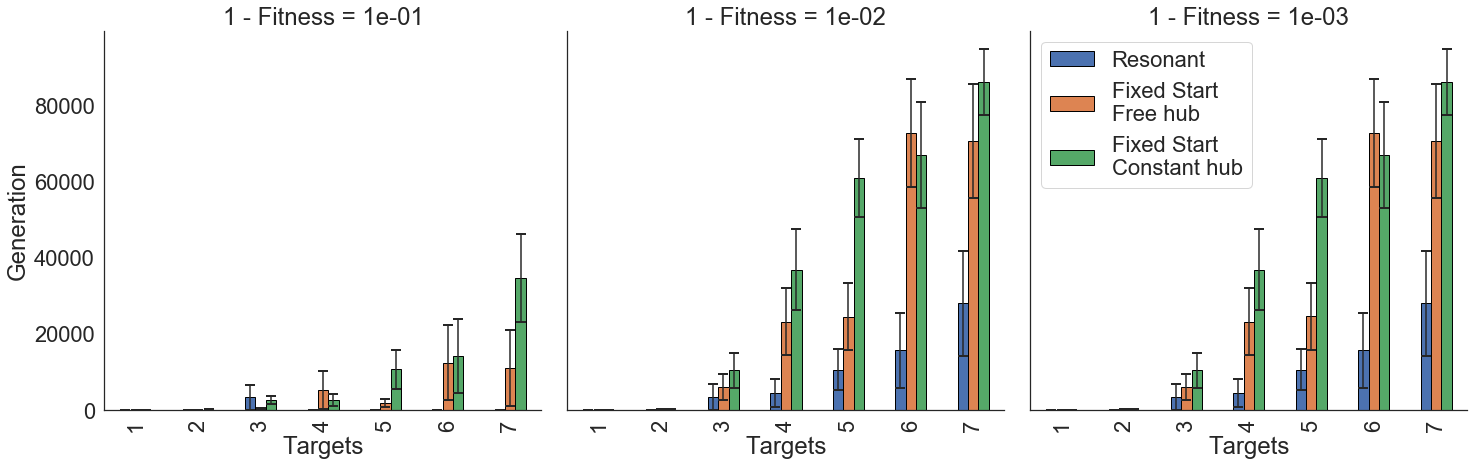

In [10]:
### Coefficient of variance plots

my_ordering = ["Resonant", "Fixed Start\nFree hub", "Fixed Start\nConstant hub"]

df3["Generation"] = df3["Avg Time"]
df3["SD_BOTTOM"] = 0



def errplot(x, y, yerr,**kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    plot = (data.pivot(index='Targets',columns='Label',
                       values='Avg Time')[my_ordering]
                .plot(ax=ax, kind='bar', error_kw=dict(capthick=2), capsize=4, edgecolor="black",
                      yerr=(data.pivot(index='Targets',  
                                      columns='Label',values='SD')[my_ordering]        
                     )))
    for ch in plot.get_children():
        if str(ch).startswith('Line2D'): # this is silly, but it appears that the first Line in the children are the caplines...
            ch.set_marker('_')
            ch.set_markersize(10) # to change its size

g = sns.FacetGrid(df3, col="1 - Fitness", height = 7)
g.map_dataframe(errplot, "Targets", "Generation", "SE")
plt.legend(loc="upper left")

plt.savefig("/Users/samgoldman/Desktop/time_to_fitness.pdf", bbox_inches="tight")

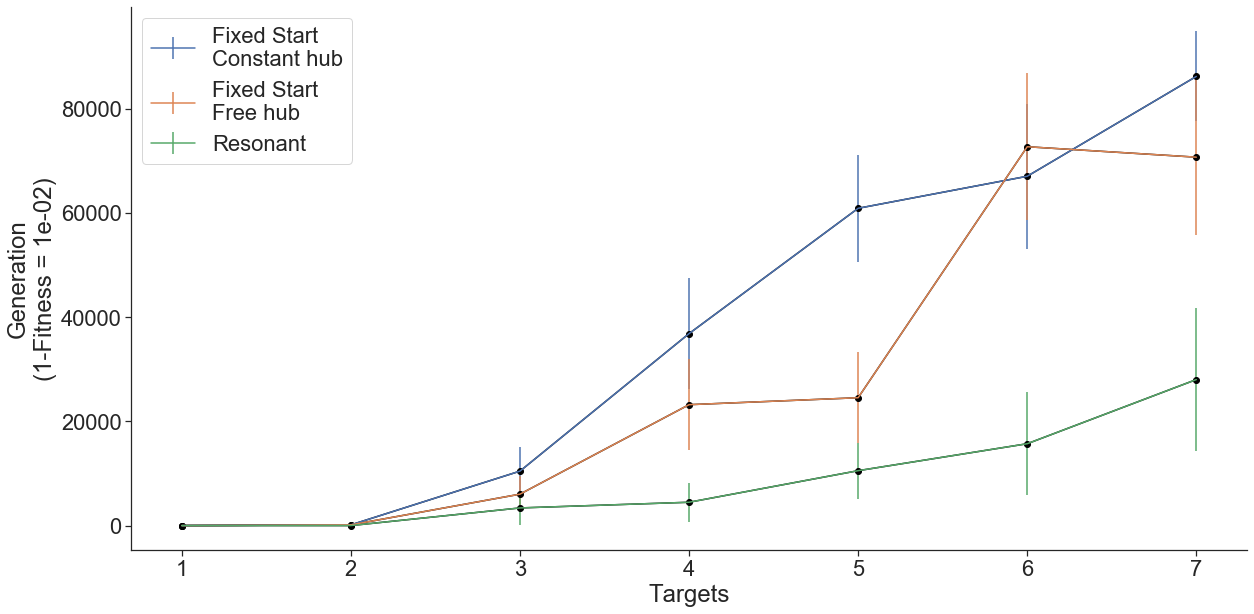

In [68]:
### Switching to a barplot

indices = (df3['1 - Fitness'] == '1e-02')
df3_temp = df3[indices]
for j in df3_temp.groupby("Label"): 
    temp_df = j[1]
    label_= j[0]
#     print(temp_df.columns, temp_df['CV'], temp_df['Generation'])
    targets = temp_df['Targets']
    SD = temp_df['SD']
    time = temp_df["Avg Time"]
    plt.errorbar(targets, time, yerr=SD, label=label_)
    plt.plot(targets, time, marker='o', color="black")

ax = plt.gca()
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.legend(loc="upper left")
plt.ylabel("Generation\n(1-Fitness = 1e-02)")
plt.xlabel("Targets")
plt.savefig("/Users/samgoldman/Desktop/time_to_fitness_lineplot.pdf", bbox_inches="tight")

plt.show()
    

In [126]:
# df_temp = df[df["Time"] == "1e+00"]
# df_temp.pivot(index='Targets',columns='Label',
#                    values='1 - Fitness').plot(kind='bar',
#                                               yerr=df_temp.pivot(index='Targets',
#                                                             columns='Label',values='SE'))


In [143]:
SD.shape

(100000,)

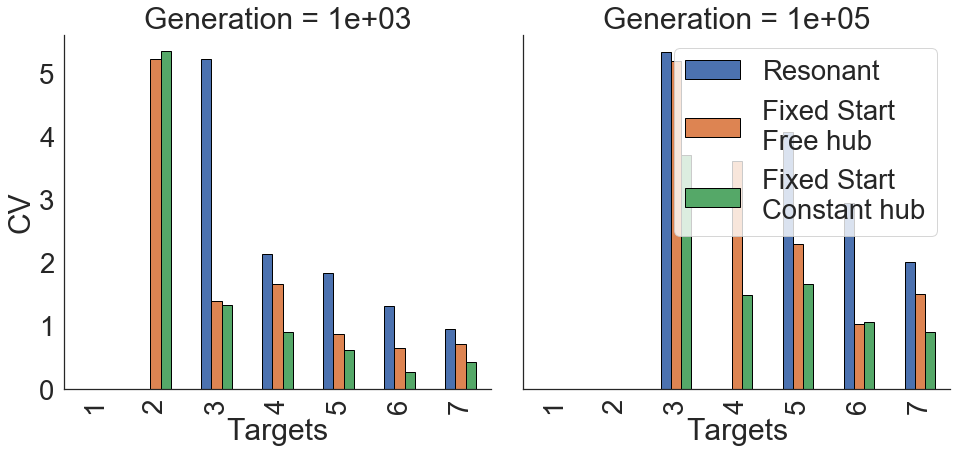

In [38]:
### Coefficient of variance plots

my_ordering = ["Resonant", "Fixed Start\nFree hub", "Fixed Start\nConstant hub"]

sns.set(style="white", font_scale=2.5) # = 2.0
df["Generation"] = df["Time"]
logical = (df['Generation'] == "1e+02")
logical = np.logical_or(logical, df["Generation"] == "1e+03")
logical = np.logical_or(logical, df["Generation"] == "1e+04")
logical = np.logical_or(logical, df["Generation"] == "1e+05")

logical = (df['Generation'] == "1e+03")
logical = np.logical_or(logical, df["Generation"] == "1e+05")


def errplot(x, y, yerr,**kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    (data.pivot(index='Targets',columns='Label',
                       values='CV')[my_ordering]
                .plot(ax=ax, kind='bar', edgecolor="black")
    )

g = sns.FacetGrid(df[logical], col="Generation", height = 7)
g.map_dataframe(errplot, "Targets", "CV", "SE")
plt.legend()

plt.savefig("/Users/samgoldman/Desktop/summary_plots_CV.pdf", bbox_inches="tight")

Targets  1 - Fitness        SE        CV   Time     Label
0        1     0.448724  0.011280  0.137653  1e+00  Resonant
1        1     0.004222  0.001235  1.564639  1e+01  Resonant
2        1     0.000333  0.000333  4.213250  1e+02  Resonant
3        1     0.000000  0.000000  0.000000  1e+03  Resonant
4        1     0.000000  0.000000  0.000000  1e+04  Resonant

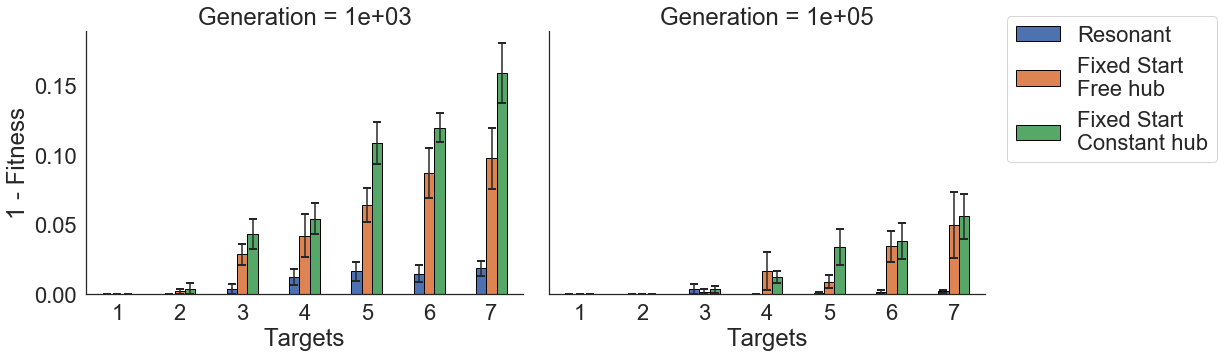

In [52]:
## my_ordering = ["Resonant", "Fixed Start\nFree hub", "Fixed Start\nConstant hub"]

sns.set(style="white", font_scale=2)
df["Generation"] = df["Time"]
logical = np.array([False for i in df['Generation']])
# logical = np.logical_or(logical, df["Generation"] == "1e+02")
logical = np.logical_or(logical, df["Generation"] == "1e+03")
# logical = np.logical_or(logical, df["Generation"] == "1e+04")
logical = np.logical_or(logical, df["Generation"] == "1e+05")


def errplot(x, y, yerr,**kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    (data.pivot(index='Targets',columns='Label',
                       values='1 - Fitness')[my_ordering]
                .plot(ax=ax, kind='bar', error_kw=dict(capthick=2), capsize=4, edgecolor="black",
                      rot = 0,
                      yerr=data.pivot(index='Targets',
                                      columns='Label',values='SE')[my_ordering])
    )

# height = 7 , aspect = 1
g = sns.FacetGrid(df[logical], col="Generation", height = 5.5, aspect=1.3)
g.map_dataframe(errplot, "Targets", "1 - Fitness", "SE")
plt.legend(loc = (1.05, 0.5))

plt.savefig("/Users/samgoldman/Desktop/summary_plots_stderror2.pdf", bbox_inches="tight")

In [52]:
df['1 - Fitness'].min()

0.0

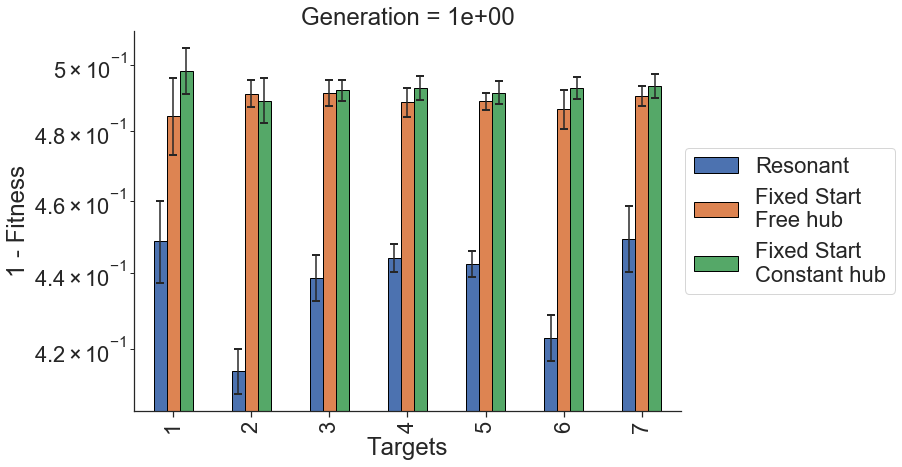

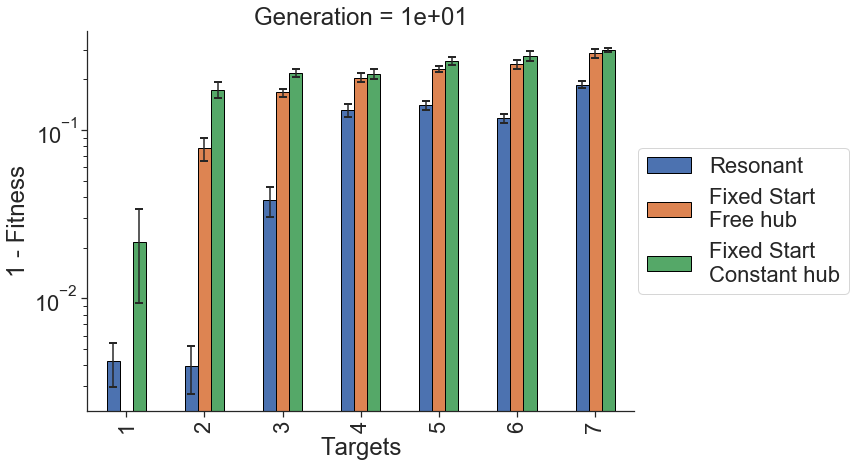

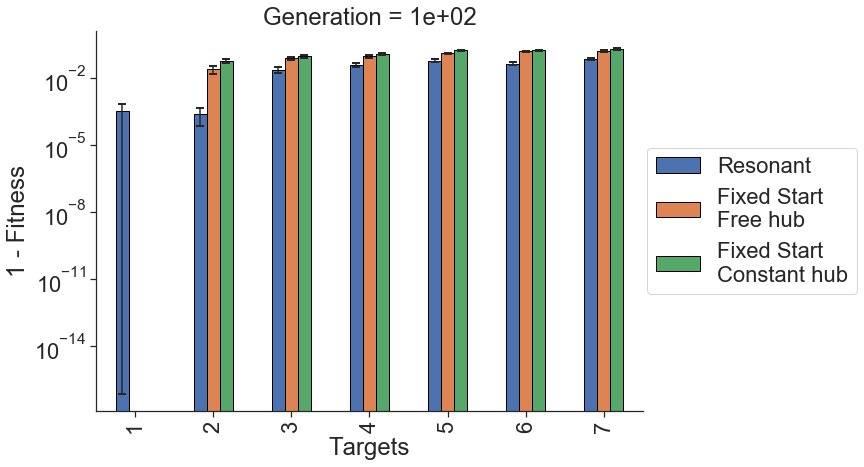

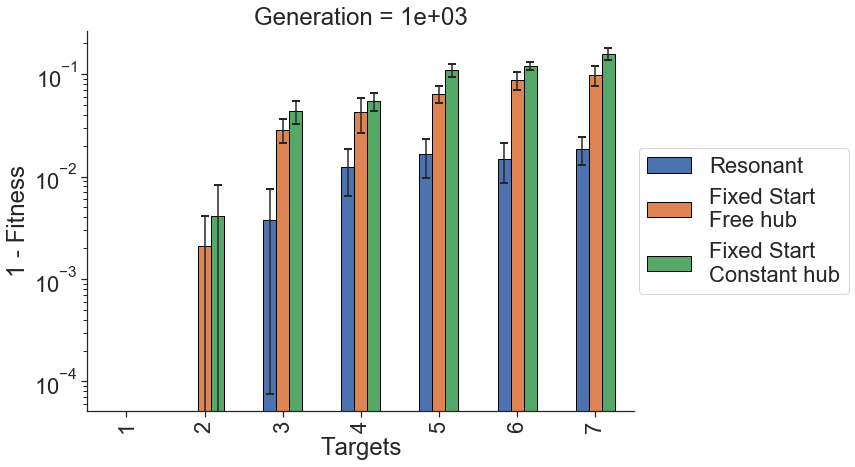

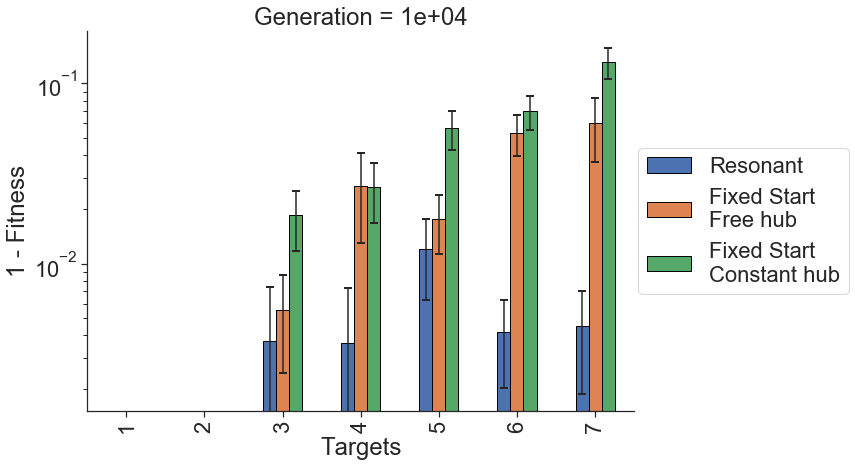

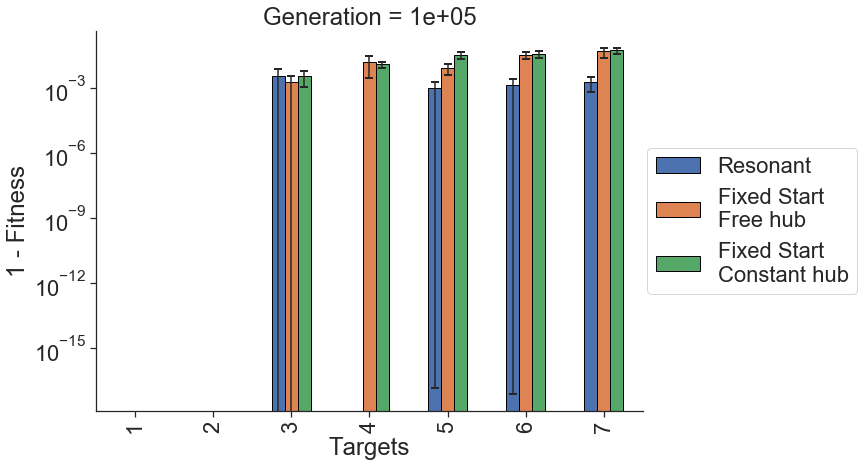

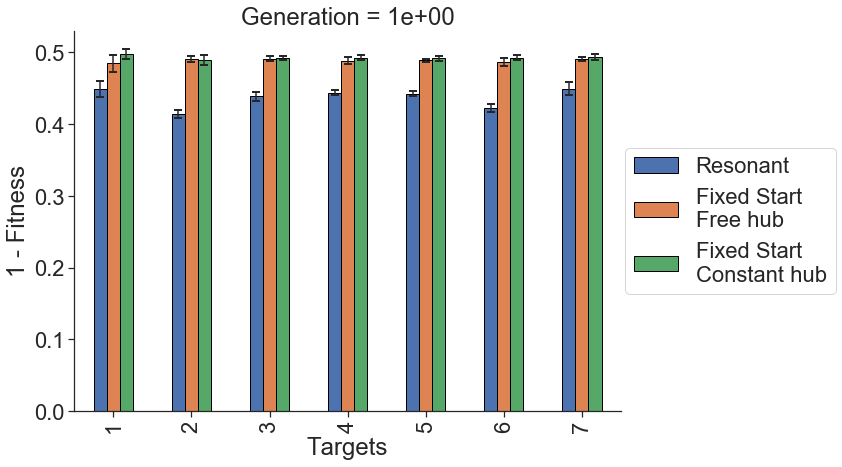

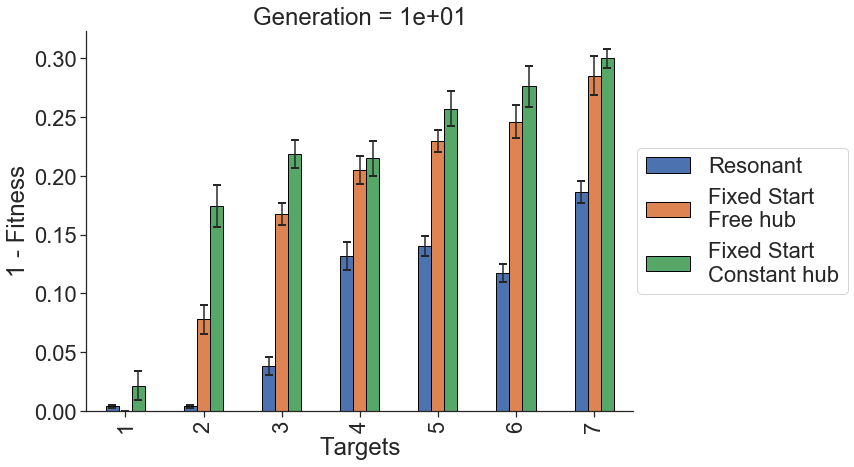

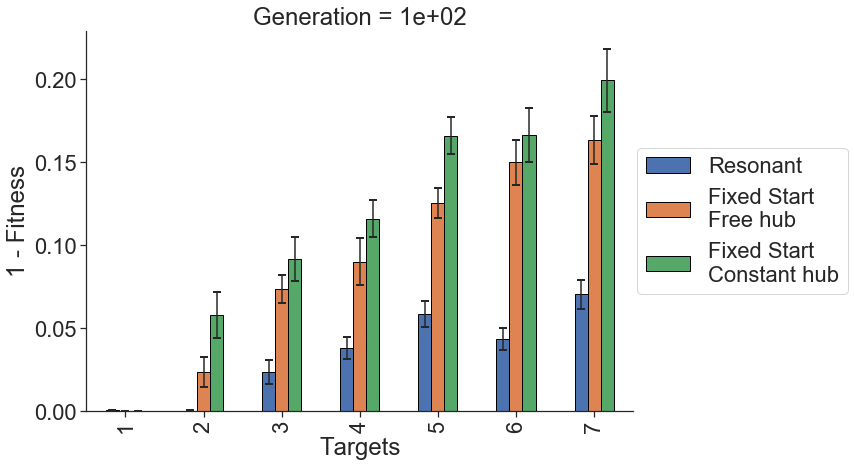

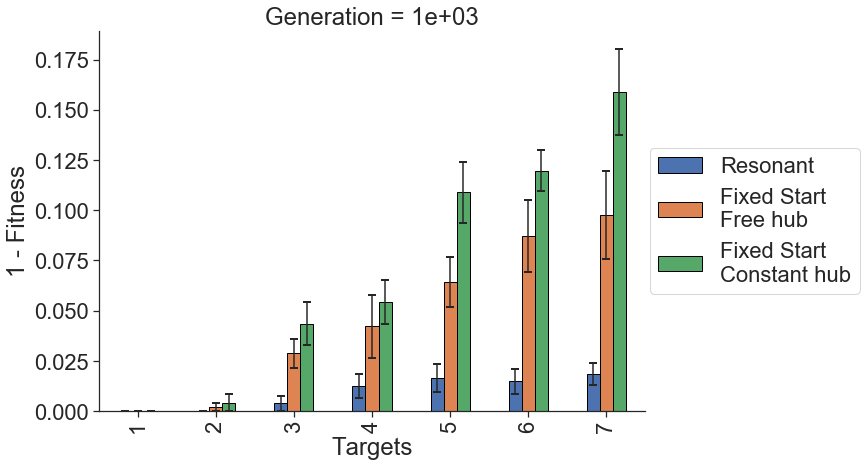

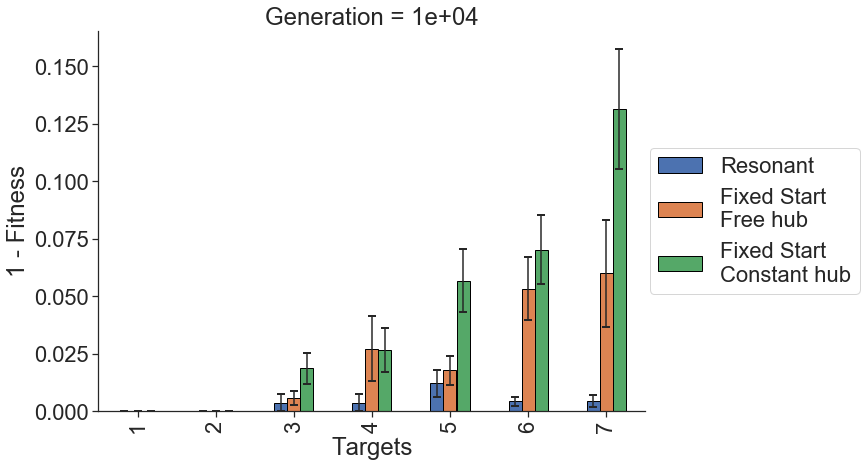

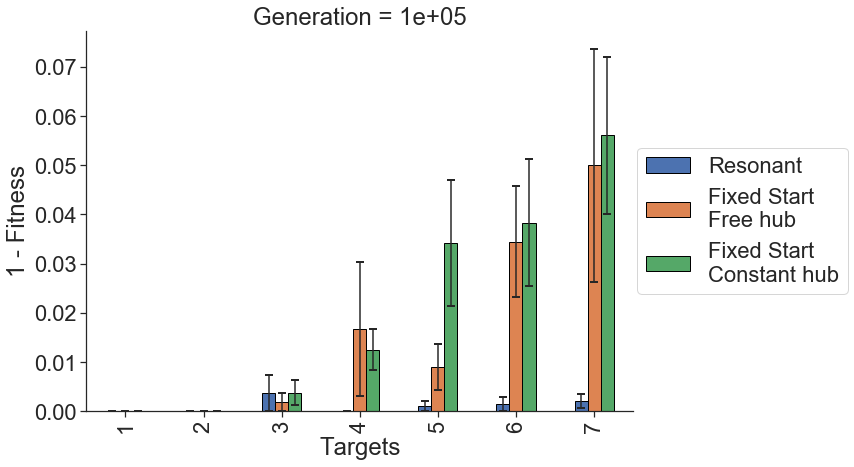

In [69]:
## 09/08/21: Replotting the above for each generation cutoff and using a log scale as per philippe's request
my_ordering = ["Resonant", "Fixed Start\nFree hub", "Fixed Start\nConstant hub"]

sns.set(style="white", font_scale=2)
df["Generation"] = df["Time"]
uniq_generations = pd.unique(df['Generation'])
for use_log in [True, False]:
    for uniq_generation in uniq_generations: 
        df_temp = df[df['Generation'] == uniq_generation]
        plt.figure(figsize=(7*1.4,5*1.4))
        ax = plt.gca()
        (df_temp.pivot(index='Targets',columns='Label',
                      values='1 - Fitness')[my_ordering]
        .plot(ax = ax, kind='bar', error_kw=dict(capthick=2), capsize=4, edgecolor="black",
              yerr=df_temp.pivot(index='Targets',columns='Label',values='SE')[my_ordering])
        )
        plt.legend(bbox_to_anchor=(1.2, 0.5), loc="center")
        plt.xlabel("Targets")
        plt.ylabel("1 - Fitness")
        if use_log:
            plt.yscale("log")
        plt.title(f"Generation = {uniq_generation}")
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        plt.savefig(f"/Users/samgoldman/Desktop/Generation_{uniq_generation}_log_{use_log}.pdf", 
                    bbox_inches="tight")
    
    #     plt.ylim([0,0.7])
    




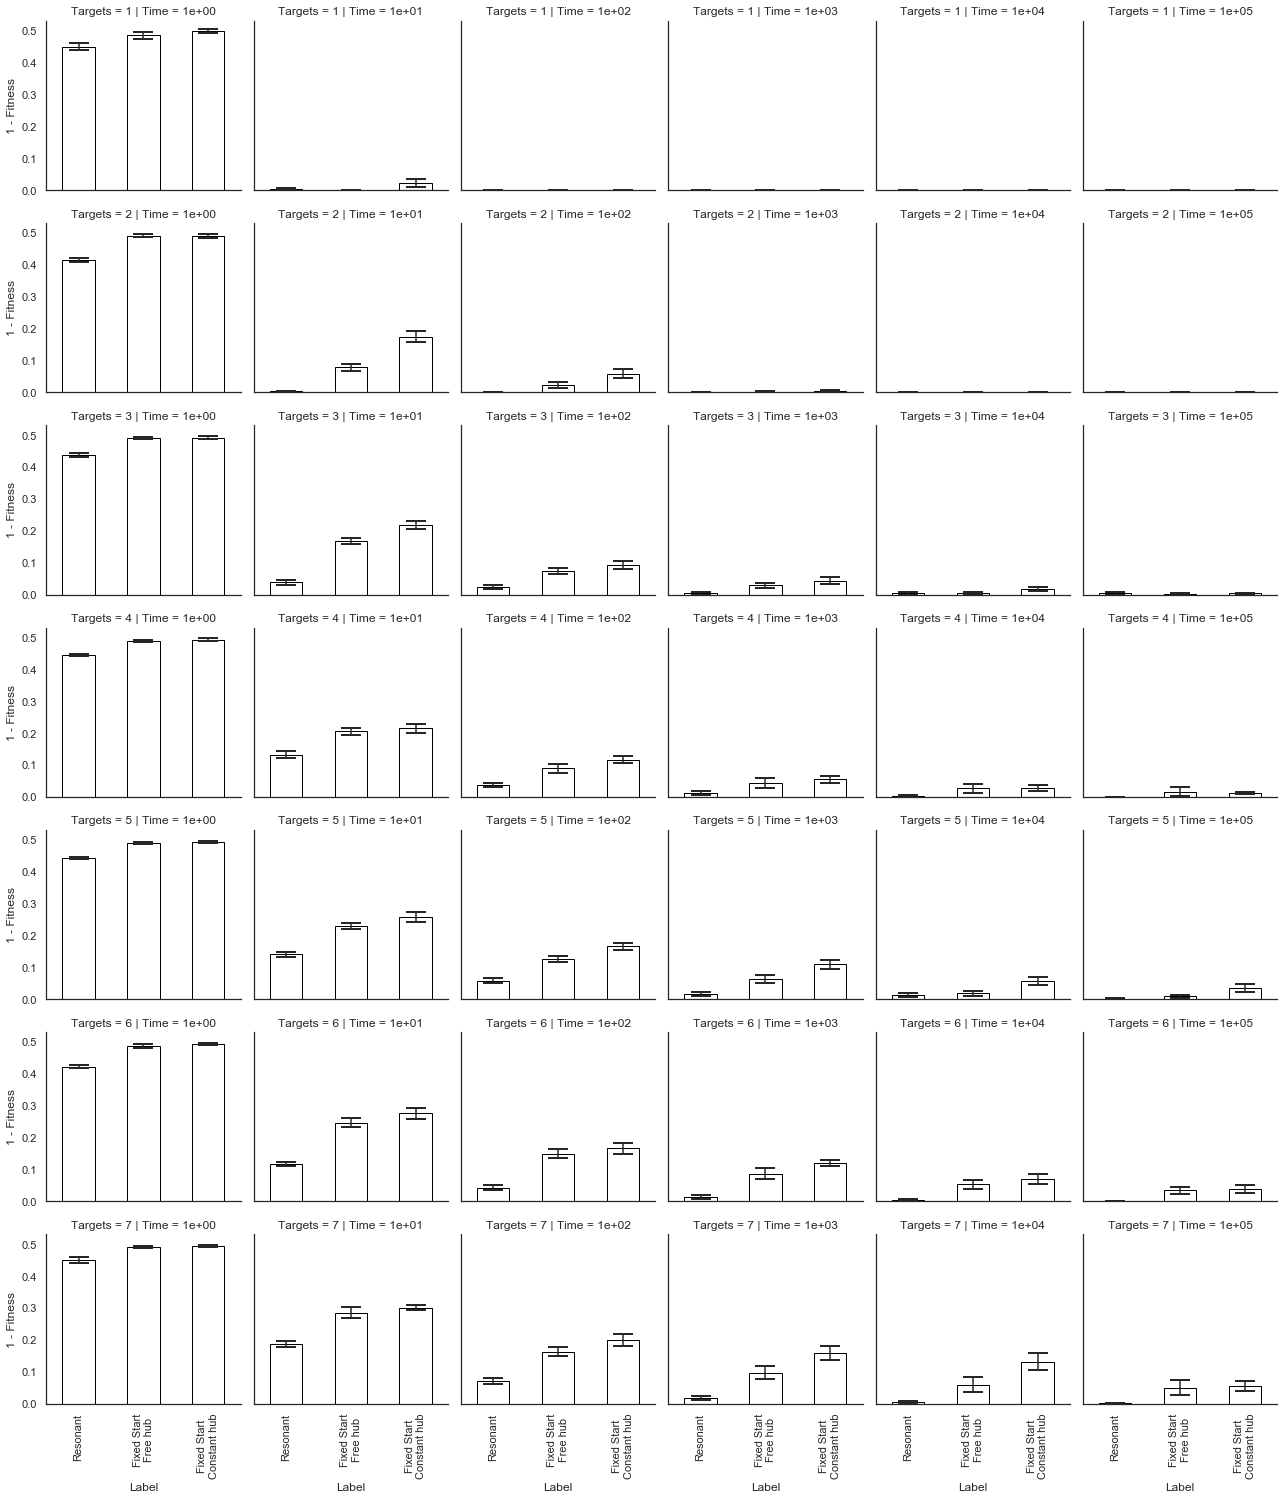

In [123]:
sns.set(style="white")
def errplot(x, y, yerr,**kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)

g = sns.FacetGrid(df, col="Time", row="Targets")
g.map_dataframe(errplot, "Label", "1 - Fitness", "SE", 
                capsize=10, error_kw=dict(capthick=2), edgecolor="black", fill=False)
plt.savefig("/Users/samgoldman/Desktop/initial_summary_plots.pdf", bbox_inches="tight")
plt.show()


<Figure size 1440x720 with 0 Axes>

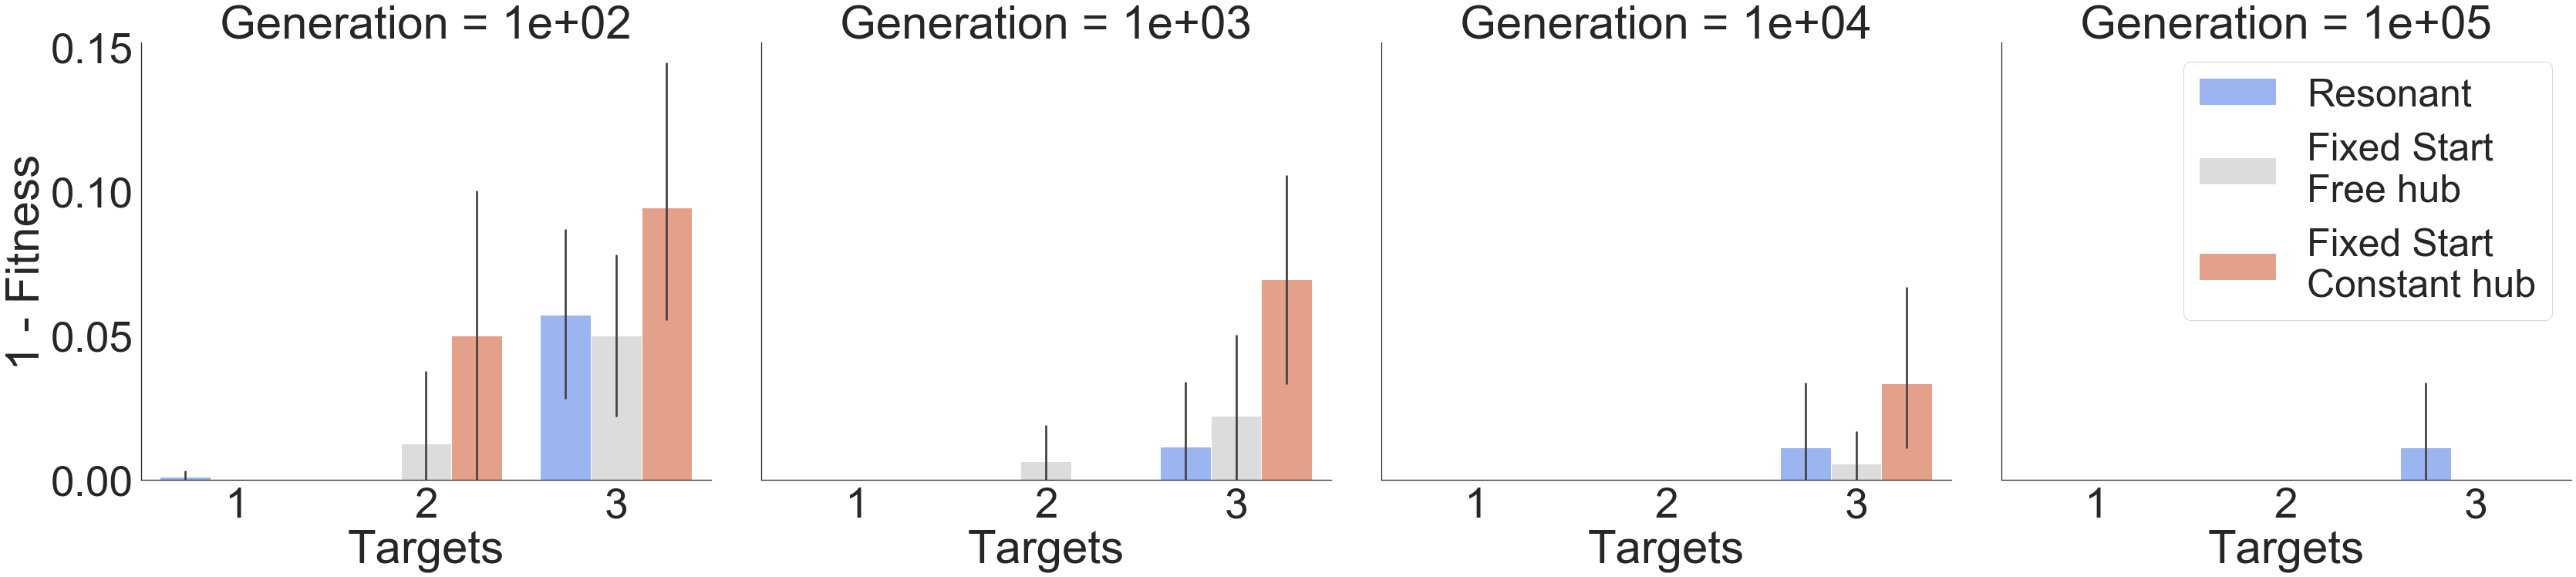

In [18]:
logical = (df2['Generation'] == "1e+02")
logical = np.logical_or(logical, df2["Generation"] == "1e+03")
logical = np.logical_or(logical, df2["Generation"] == "1e+04")
logical = np.logical_or(logical, df2["Generation"] == "1e+05")
logical = np.logical_and(logical, df2["Targets"] >= 1)

colors = sns.color_palette("coolwarm", 3)#plt.cm.jet(np.linspace(0,1,len(target_lengths)))


sns.set(font_scale=5, style="white")
g = sns.FacetGrid(df2[logical], col="Generation", height=12, aspect=1)
g.map_dataframe(sns.barplot, "Targets", "1 - Fitness",  hue="Label", ci=95, palette=colors)
plt.legend(fontsize=50)
plt.savefig("/Users/samgoldman/Desktop/initial_summary_plots_filtered.pdf", bbox_inches="tight")



                        

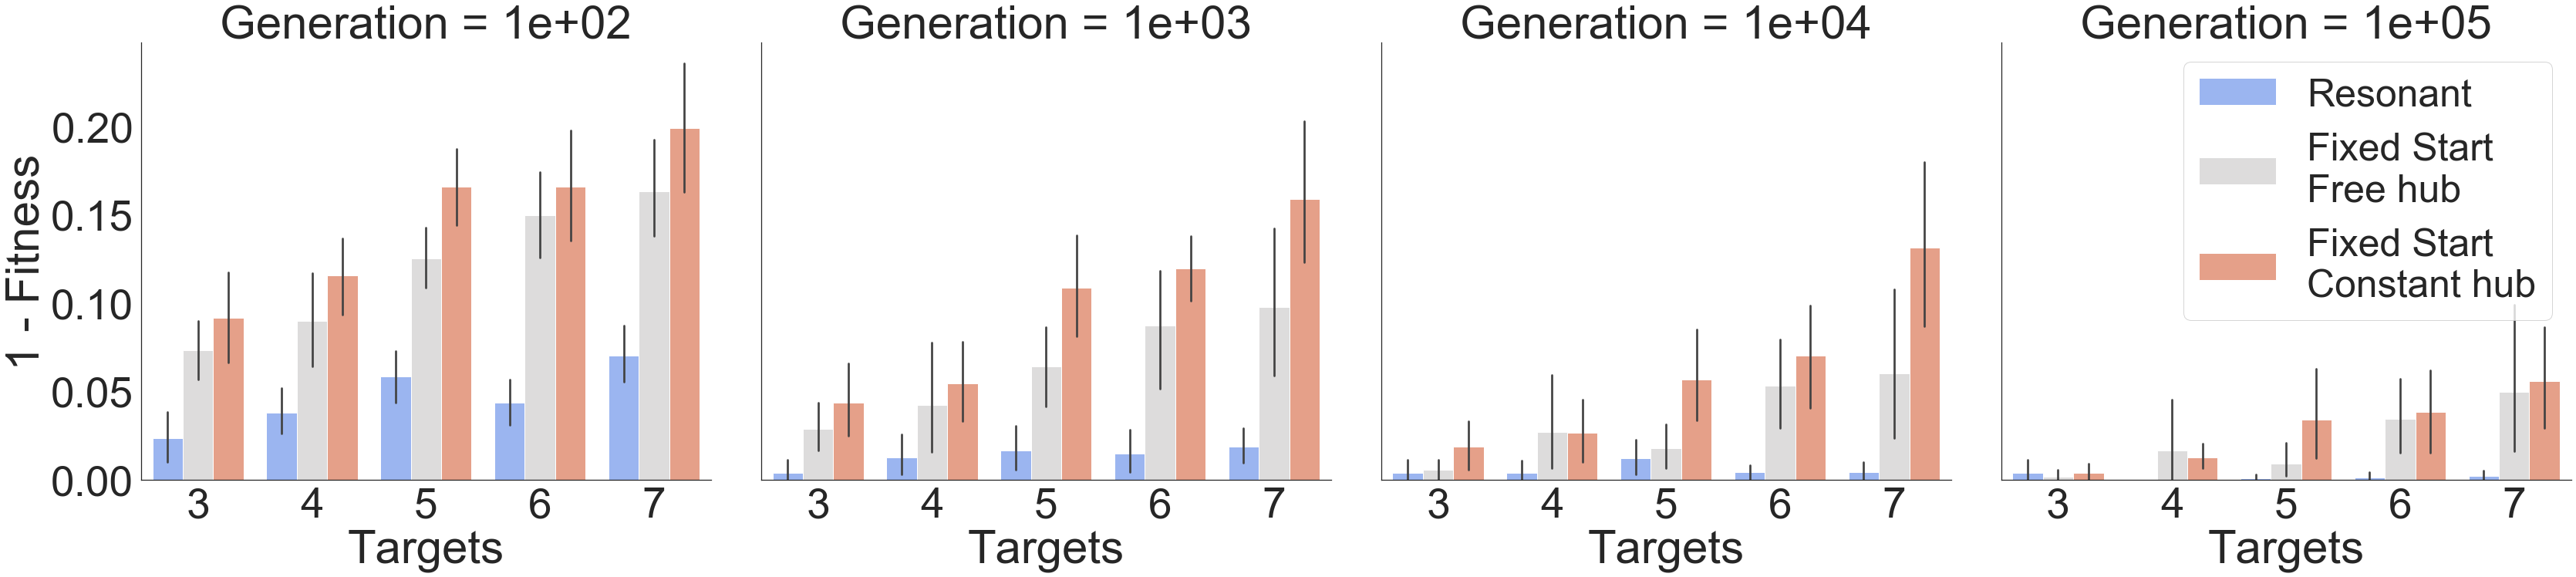

In [19]:
logical = (df2['Generation'] == "1e+02")
logical = np.logical_or(logical, df2["Generation"] == "1e+03")
logical = np.logical_or(logical, df2["Generation"] == "1e+04")
logical = np.logical_or(logical, df2["Generation"] == "1e+05")
logical = np.logical_and(logical, df2["Targets"] >= 3)

colors = sns.color_palette("coolwarm", 3)#plt.cm.jet(np.linspace(0,1,len(target_lengths)))


sns.set(font_scale=5, style="white")
g = sns.FacetGrid(df2[logical], col="Generation", height=12, aspect=1)
g.map_dataframe(sns.barplot, "Targets", "1 - Fitness",  hue="Label", ci=95, palette=colors)
plt.legend(fontsize=50)
plt.savefig("/Users/samgoldman/Desktop/initial_summary_plots_filtered.pdf", bbox_inches="tight")



                        

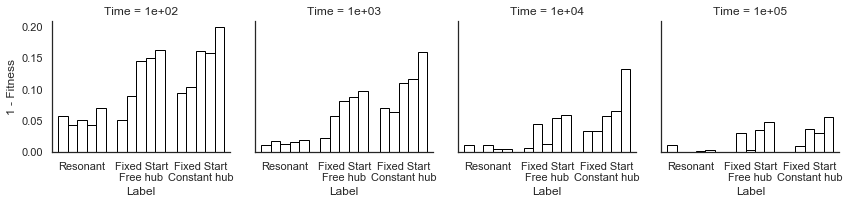

In [209]:
g = sns.FacetGrid(df[logical], col="Time", hue="")
g.map_dataframe(sns.barplot, "Label", "1 - Fitness", hue="Targets",
                capsize=10, error_kw=dict(capthick=2,  yerr="SD"), edgecolor="black", fill=False)

# plt.savefig("/Users/samgoldman/Desktop/initial_summary_plots_filtered.pdf", bbox_inches="tight")




Targets
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
7    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

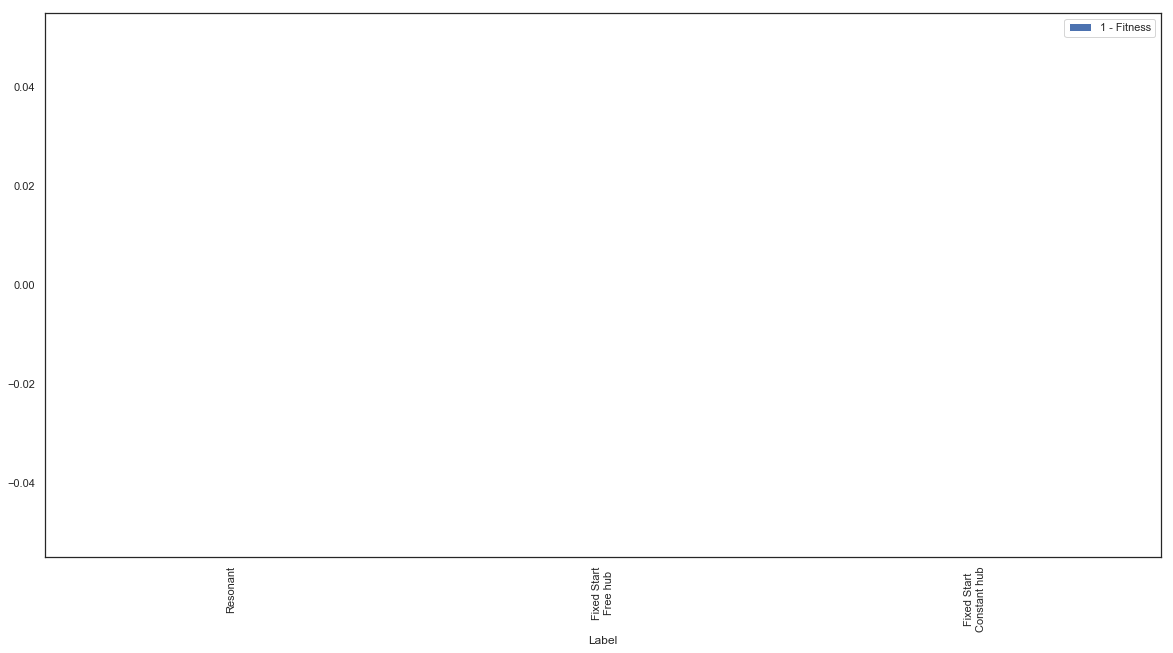

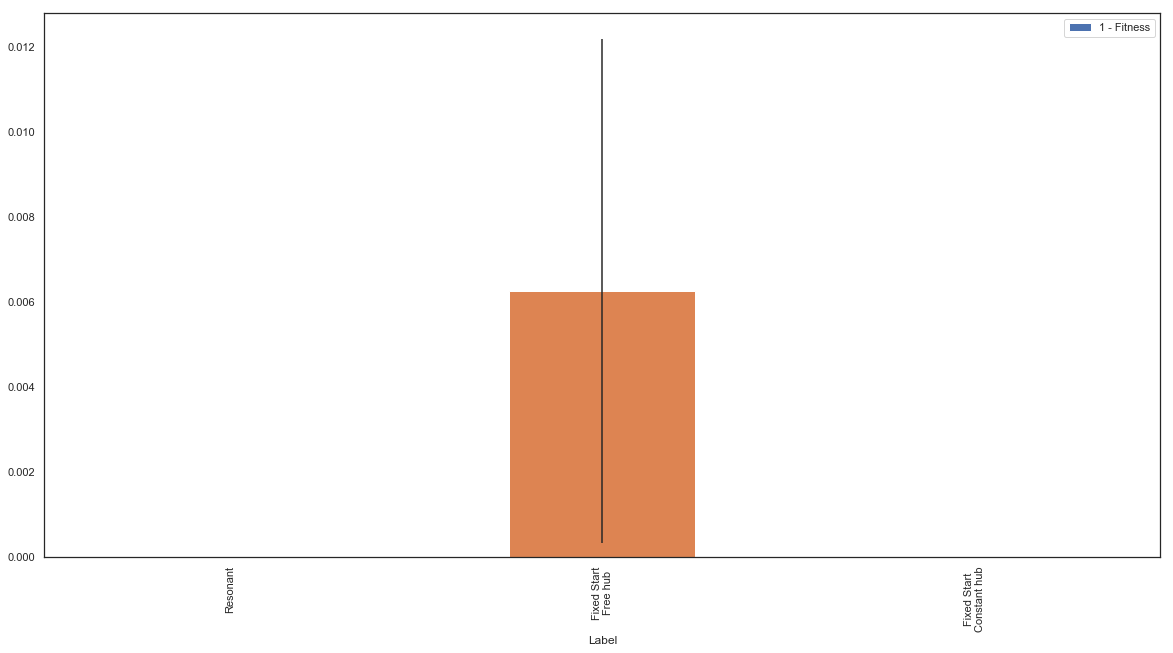

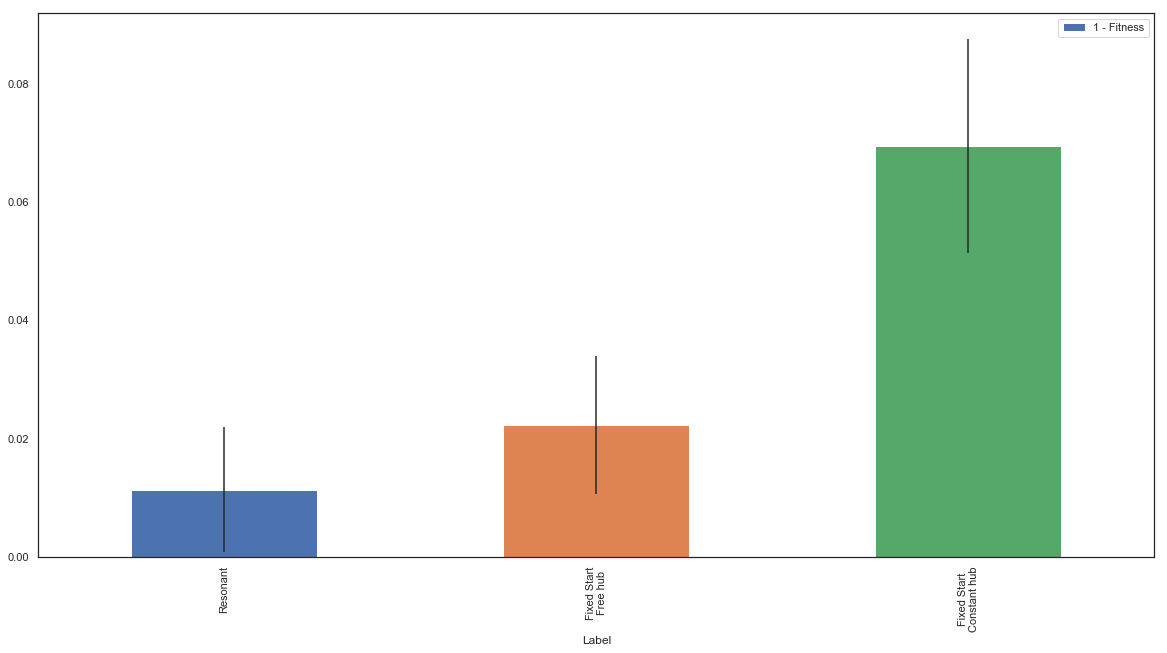

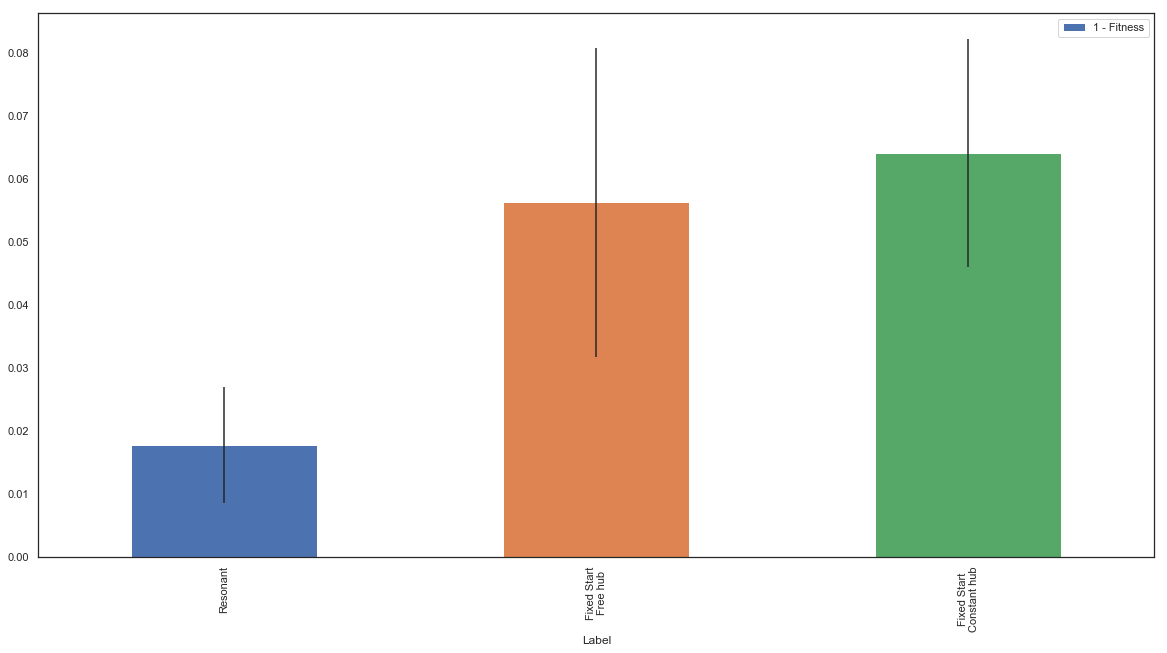

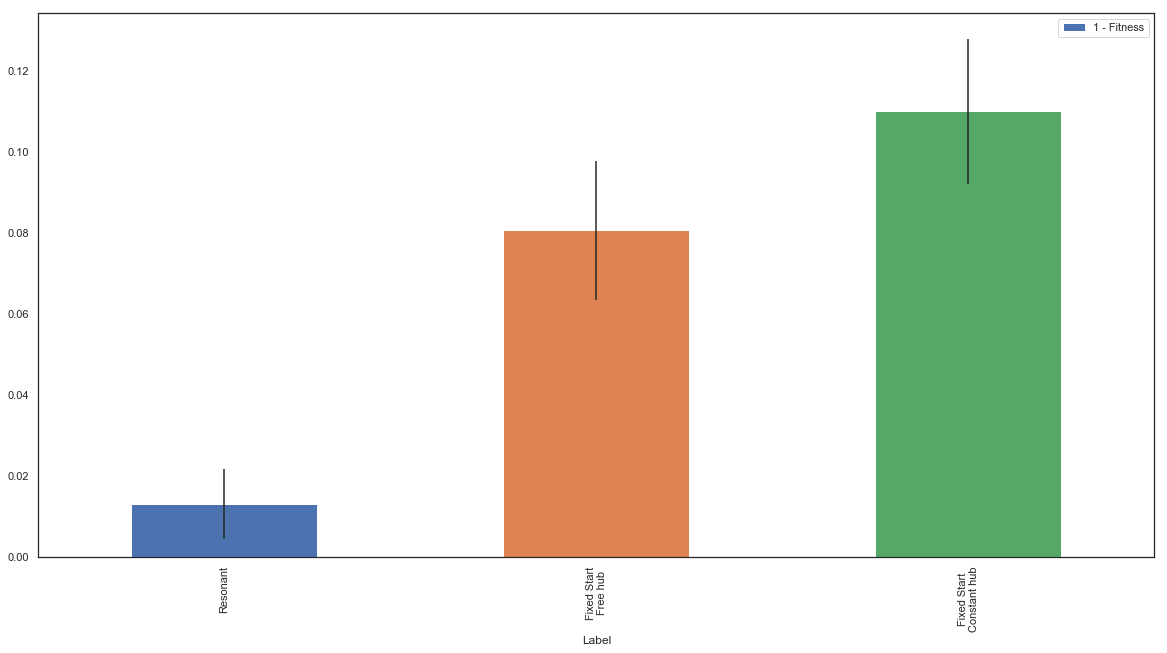

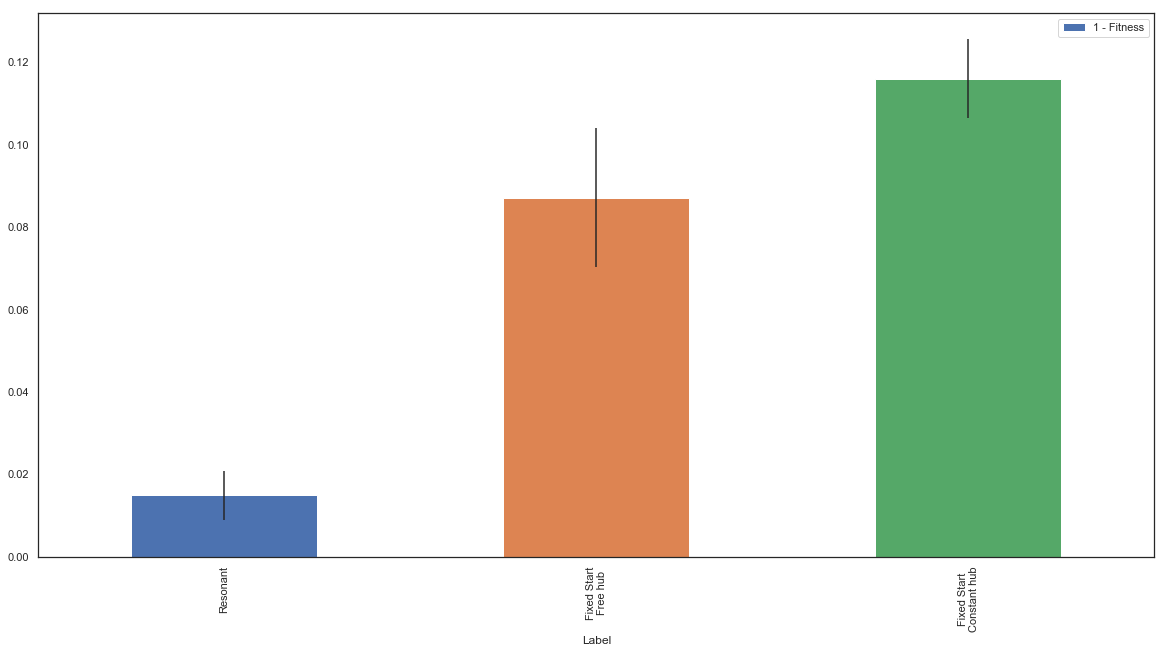

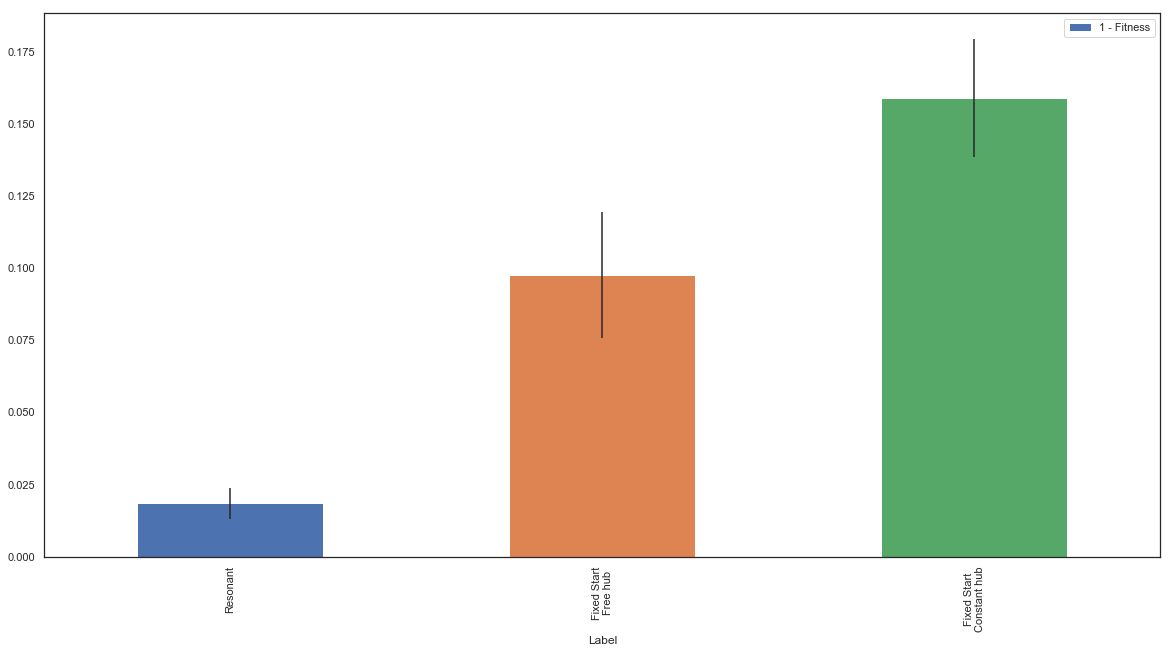

In [200]:
df[df["Time"] == "1e+03"].groupby("Targets").plot("Label", "1 - Fitness", yerr="SE", kind="bar")

In [203]:
df.groupby(by=["Label", "Targets",])

Targets  1 - Fitness        SE   Time                      Label
0          1     0.506771  0.017657  1e+00                   Resonant
1          1     0.005000  0.002550  1e+01                   Resonant
2          1     0.001000  0.000949  1e+02                   Resonant
3          1     0.000000  0.000000  1e+03                   Resonant
4          1     0.000000  0.000000  1e+04                   Resonant
5          1     0.000000  0.000000  1e+05                   Resonant
6          1     0.459128  0.017825  1e+00      Fixed Start\nFree hub
7          1     0.000000  0.000000  1e+01      Fixed Start\nFree hub
8          1     0.000000  0.000000  1e+02      Fixed Start\nFree hub
9          1     0.000000  0.000000  1e+03      Fixed Start\nFree hub
10         1     0.000000  0.000000  1e+04      Fixed Start\nFree hub
11         1     0.000000  0.000000  1e+05      Fixed Start\nFree hub
12         1     0.506771  0.017657  1e+00  Fixed Start\nConstant hub
13         1     0.005000  0.002550  1e+01  Fixed Start\nConstant hub
14         1     0.001000  0.000949  1e+02  Fixed Start\nConstant hub
15         1     0.000000  0.000000  1e+03  Fixed Start\nConstant hub
16         1     0.000000  0.000000  1e+04  Fixed Start\nConstant hub
17         1     0.000000  0.000000  1e+05  Fixed Start\nConstant hub
18         2     0.417486  0.005967  1e+00                   Resonant
19         2     0.005823  0.002622  1e+01                   Resonant
20         2     0.000000  0.000000  1e+02                   Resonant
21         2     0.000000  0.000000  1e+03                   Resonant
22         2     0.000000  0.000000  1e+04                   Resonant
23         2     0.000000  0.000000  1e+05                   Resonant
24         2     0.488127  0.010223  1e+00      Fixed Start\nFree hub
25         2     0.069525  0.017482  1e+01      Fixed Start\nFree hub
26         2     0.012500  0.011859  1e+02      Fixed Start\nFree hub
27         2     0.006250  0.005929  1e+03      Fixed Start\nFree hub
28         2     0.000000  0.000000  1e+04      Fixed Start\nFree hub
29         2     0.000000  0.000000  1e+05      Fixed Start\nFree hub
..       ...          ...       ...    ...                        ...
96         6     0.486559  0.005516  1e+00      Fixed Start\nFree hub
97         6     0.246085  0.013230  1e+01      Fixed Start\nFree hub
98         6     0.149884  0.012935  1e+02      Fixed Start\nFree hub
99         6     0.087083  0.016845  1e+03      Fixed Start\nFree hub
100        6     0.053194  0.013054  1e+04      Fixed Start\nFree hub
101        6     0.034444  0.010708  1e+05      Fixed Start\nFree hub
102        6     0.492982  0.003403  1e+00  Fixed Start\nConstant hub
103        6     0.277564  0.017396  1e+01  Fixed Start\nConstant hub
104        6     0.156790  0.013367  1e+02  Fixed Start\nConstant hub
105        6     0.116049  0.009609  1e+03  Fixed Start\nConstant hub
106        6     0.065586  0.014355  1e+04  Fixed Start\nConstant hub
107        6     0.030247  0.009978  1e+05  Fixed Start\nConstant hub
108        7     0.449352  0.008564  1e+00                   Resonant
109        7     0.186153  0.008743  1e+01                   Resonant
110        7     0.070351  0.008353  1e+02                   Resonant
111        7     0.018544  0.005328  1e+03                   Resonant
112        7     0.004490  0.002463  1e+04                   Resonant
113        7     0.002041  0.001291  1e+05                   Resonant
114        7     0.490103  0.003019  1e+00      Fixed Start\nFree hub
115        7     0.288170  0.016211  1e+01      Fixed Start\nFree hub
116        7     0.161738  0.014522  1e+02      Fixed Start\nFree hub
117        7     0.097543  0.021875  1e+03      Fixed Start\nFree hub
118        7     0.057993  0.023208  1e+04      Fixed Start\nFree hub
119        7     0.046788  0.023549  1e+05      Fixed Start\nFree hub
120        7     0.493616  0.003409  1e+00  Fixed Start\nConstant hub
121        7   

## Analyze the network...

In [12]:
def load_network_file(file_name): 
    ''' 
        Load the file output that we make! 
    '''
    with open(file_name, encoding='utf-8') as data_file:
        data = json.loads(data_file.read())
    return data

In [3]:
prefix = "../../Results/NetworkEvolutions/saved_output_networks/"
my_file = prefix + "Multiplex_Evolution_2018-07-17_23:24:39.json"

In [4]:
data = load_network_file(my_file)

In [5]:
mat = csr_matrix(np.array(data['network']))

In [6]:
my_graph = HomGraph(500, 2)
my_graph.npgraph = mat

In [7]:
hub_node = data['hub_node']
target_node = data['target_node']

In [8]:
period = 12
my_graph.random_config()
tbl = my_graph.oscillate_update(time = 1000, force_start_on=False, period=period, node_index=hub_node)
start, stop = Graph.find_attractor_in_oscillations(tbl, period=period)
tbl[start:stop, target_node]

array([1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.])

In [9]:
## In degree of target and hub node
my_graph.in_degree()[[target_node,hub_node]], my_graph.out_degree()[[target_node,hub_node]]

(array([7, 7]), array([  2, 498]))

In [10]:
attr_graph = AttractorGraph(graph=my_graph, oscil_node=hub_node)


In [11]:
attr_graph.explore_periods(explore_null=True, periods=[4, 6, 8, 10, 12], t=1000, trials=10)

In [12]:
attr_graph.pretty_print()

Periods explored:  ['0', '4', '6', '8', '10', '12']
Period:  0
Number of attractors explored:  13
Size of each attractor:  [6, 8, 6, 8, 2, 8, 8, 8, 8, 8, 2, 8, 8]
Number of nodes in each basin:  [24, 43, 307, 321, 126, 66, 17, 22, 18, 22, 14, 14, 16]
-----------------
Period:  4
Number of attractors explored:  1
Size of each attractor:  [8]
Number of nodes in each basin:  [111]
-----------------
Period:  6
Number of attractors explored:  2
Size of each attractor:  [6, 6]
Number of nodes in each basin:  [112, 17]
-----------------
Period:  8
Number of attractors explored:  1
Size of each attractor:  [8]
Number of nodes in each basin:  [121]
-----------------
Period:  10
Number of attractors explored:  1
Size of each attractor:  [10]
Number of nodes in each basin:  [164]
-----------------
Period:  12
Number of attractors explored:  1
Size of each attractor:  [12]
Number of nodes in each basin:  [155]
-----------------


In [13]:
attr_graph.export_graph("/Users/samgoldman/Desktop/test_network")

In [ ]:
for i in [4,6,8,10,12]:
    print("avg depth of attractors to old attr: ", attr_graph.avg_depth_period(i))